In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import argparse
from prophet import Prophet

In [2]:
parser = argparse.ArgumentParser()

parser.add_argument('strings', metavar='STRING', nargs='*', help='String for searching')
parser.add_argument('-f', '--file', help='Path for input file. First line should contain number of lines to search in')
parser.add_argument('--predict_periods', help="How many periods to the future to predict.", type=int, default=365)
parser.add_argument('--data_file', help="File name with dataset.", type=str, default='accidents_daily_temp.csv')

args = parser.parse_args()

periods_to_predict = int(args.predict_periods)
data_file = args.data_file

In [3]:
dataset_df = pd.read_csv(data_file, index_col='date', parse_dates=True)

dataset_df

y  temp
date                 
2016-01-01  450  -0.6
2016-01-02  148  -0.3
2016-01-03   99  -4.4
2016-01-04  344  -5.9
2016-01-05  271  -4.7
...         ...   ...
2022-12-27  169   2.7
2022-12-28  157   3.6
2022-12-29  151   8.1
2022-12-30  157   6.7
2022-12-31  111  12.6

[2557 rows x 2 columns]

In [4]:
# split the data to training set and test set

column_names = ['ds', 'y', 'temp']  # ds = date, y = number of accidents in that day/month

# train set = years 2016-2021, test set = year 2022
dataset_train = dataset_df[:len(dataset_df) - periods_to_predict].reset_index()  # reserve last 12 observation as test set
dataset_train.columns = column_names
dataset_test = dataset_df[len(dataset_df) - periods_to_predict:].reset_index()
dataset_test.columns = column_names

print(dataset_train)
print(dataset_test)

             ds    y  temp
0    2016-01-01  450  -0.6
1    2016-01-02  148  -0.3
2    2016-01-03   99  -4.4
3    2016-01-04  344  -5.9
4    2016-01-05  271  -4.7
...         ...  ...   ...
2187 2021-12-27  214  -2.4
2188 2021-12-28  199  -0.4
2189 2021-12-29  181   3.6
2190 2021-12-30  198   9.1
2191 2021-12-31  141  11.2

[2192 rows x 3 columns]
            ds    y  temp
0   2022-01-01  543   9.7
1   2022-01-02  123   6.7
2   2022-01-03  234   7.8
3   2022-01-04  246   7.7
4   2022-01-05  219   2.8
..         ...  ...   ...
360 2022-12-27  169   2.7
361 2022-12-28  157   3.6
362 2022-12-29  151   8.1
363 2022-12-30  157   6.7
364 2022-12-31  111  12.6

[365 rows x 3 columns]


In [5]:
dataset_df.reset_index(inplace=True)
dataset_df.columns = column_names

print(dataset_df)

             ds    y  temp
0    2016-01-01  450  -0.6
1    2016-01-02  148  -0.3
2    2016-01-03   99  -4.4
3    2016-01-04  344  -5.9
4    2016-01-05  271  -4.7
...         ...  ...   ...
2552 2022-12-27  169   2.7
2553 2022-12-28  157   3.6
2554 2022-12-29  151   8.1
2555 2022-12-30  157   6.7
2556 2022-12-31  111  12.6

[2557 rows x 3 columns]


In [6]:
# create a dataframe that will contain forecasts from all applied algorithms
predict_df = pd.DataFrame(dataset_df['ds'])

# add new dates to the predict_df in the length of months from the arguments
last_date = dataset_df['ds'].max()
next_dates = pd.date_range(start=last_date, periods=periods_to_predict + 1, freq='1d')
new_rows = pd.DataFrame(next_dates, columns=['ds'])
new_rows = new_rows.iloc[1:]

predict_df = pd.concat([predict_df, new_rows])

# add original values to the predict_df dataframe
predict_df['original'] = list(dataset_train['y']) + list(dataset_test['y']) + [None] * periods_to_predict
predict_df['temp'] = list(dataset_train['temp']) + list(dataset_test['temp']) + [None] * periods_to_predict
predict_df.set_index('ds', inplace=True)

predict_df['temp'] = predict_df['temp'].fillna(10)
predict_df

original  temp
ds                        
2016-01-01     450.0  -0.6
2016-01-02     148.0  -0.3
2016-01-03      99.0  -4.4
2016-01-04     344.0  -5.9
2016-01-05     271.0  -4.7
...              ...   ...
2023-12-27       NaN  10.0
2023-12-28       NaN  10.0
2023-12-29       NaN  10.0
2023-12-30       NaN  10.0
2023-12-31       NaN  10.0

[2922 rows x 2 columns]

In [7]:
# Prophet

prophet_model = Prophet()  # create new object for forecasting
prophet_model.add_regressor('temp', standardize=False)
prophet_model.fit(dataset_train)  # fit the training data
#future = prophet_model.make_future_dataframe(periods=periods_to_predict + periods_to_predict, freq='1d')  # set length of forecast

forecast = prophet_model.predict(predict_df.reset_index().tail(periods_to_predict + periods_to_predict)[['ds', 'temp']])  # predict for the number of observations set in the previous step

00:21:37 - cmdstanpy - INFO - Chain [1] start processing
00:21:38 - cmdstanpy - INFO - Chain [1] done processing


Text(83.09722222222221, 0.5, 'number of accidents')

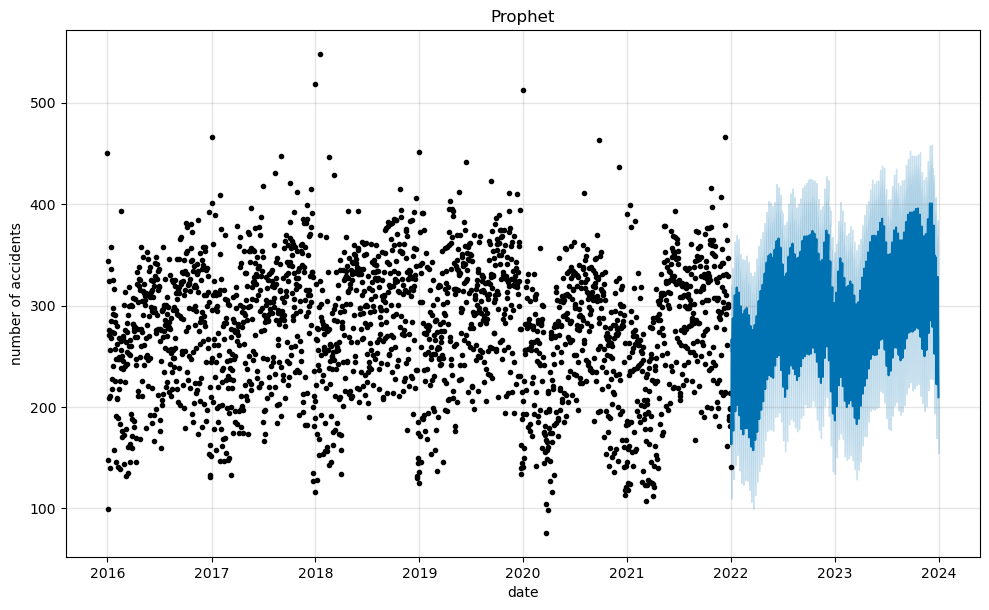

In [8]:
fig1 = prophet_model.plot(forecast)  # plot the forecast
plt.title("Prophet")
plt.xlabel("date")
plt.ylabel("number of accidents")

Text(0, 0.5, 'number of accidents')

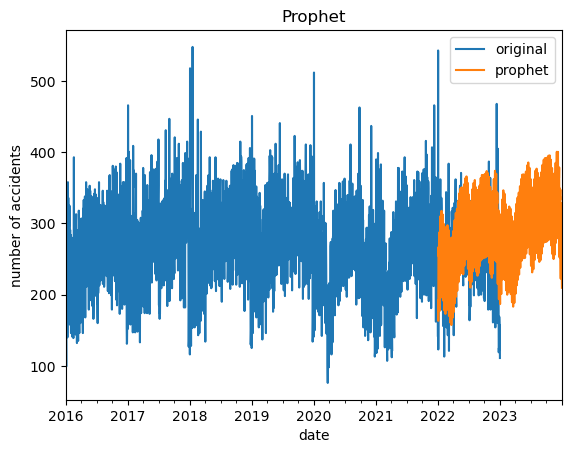

In [9]:
predict_df['prophet'] = [None]*len(dataset_train) + list(forecast['yhat'].tail(periods_to_predict + periods_to_predict))  # add the forecast to predict_df

predict_df[['original', 'prophet']].plot()
plt.title("Prophet")
plt.xlabel("date")
plt.ylabel("number of accidents")

In [10]:
prophet_model.params

OrderedDict([('lp__', array([[4578.68]])),
             ('k', array([[0.0854409]])),
             ('m', array([[0.483901]])),
             ('delta',
              array([[ 8.40557e-08,  3.35985e-08, -1.55718e-08,  1.62900e-07,
                      -6.21398e-08, -2.53261e-08,  2.56317e-08, -6.39173e-07,
                      -2.58289e-07, -3.96179e-03, -1.89568e-07, -4.97259e-07,
                      -6.33271e-08, -4.02484e-08, -4.27858e-08, -1.38216e-07,
                      -2.31501e-01, -1.49368e-01, -9.82796e-03, -3.92596e-07,
                      -5.00135e-08,  2.67661e-05,  4.75199e-08,  8.09854e-08,
                       5.62810e-01]])),
             ('sigma_obs', array([[0.074455]])),
             ('beta',
              array([[-0.0392401 , -0.0214072 , -0.0243213 ,  0.00116554,  0.0148318 ,
                       0.00387533, -0.00086484, -0.00887523, -0.00506351, -0.0077441 ,
                      -0.00488326, -0.0137472 ,  0.00789228, -0.00498445,  0.00228971,
           

In [11]:
# # use grid search to find the most optimal hyperparameters for SVR model
# param_grid = {
#     'kernel': ['rbf', 'sigmoid'],
#     'C': [0.1, 1, 10],
#     'epsilon': [0.01, 0.1, 1],
#     'gamma': ['scale', 'auto', 0.1, 1]
# }

# cv = TimeSeriesSplit(n_splits=5)

# svr = SVR()

# grid_search = GridSearchCV(svr, param_grid, cv=cv)
# grid_search.fit(dataset_train['ds'].values.reshape(-1, 1), dataset_train['y'].values)  # fit the training data

# print("Best parameters: ", grid_search.best_params_)  # print the most optimal hyperparameter values
# print("Best score: ", grid_search.best_score_)

In [12]:
# # SVR
# svr_model = SVR(kernel='rbf', gamma='auto', C=10, epsilon=1)  # create model with values from the GridSearchCV
# svr_model.fit(dataset_train.index.values.reshape(-1, 1), dataset_train['y'].values)  # fit the training data

# y_pred = svr_model.predict(dataset_test.index.values.reshape(-1, 1))

# y_pred

In [13]:
# # plot the whole dataset + add predicted values for 2022
# svr_predict_df = pd.DataFrame(dataset_df)
# svr_predict_df['forecast_value'] = [None]*len(dataset_train) + list(y_pred)

# svr_predict_df.set_index('ds', inplace=True)
# svr_predict_df.columns = ["original", "predicted"]
# svr_predict_df.plot()
# plt.title("SVR by month")
# plt.xlabel("month")
# plt.ylabel("number of accidents")

In [14]:
from scalecast.Forecaster import Forecaster

In [15]:
# create a Forecaster object that will make forecasts from multiple models
f_model = Forecaster(
    y=np.array(dataset_df.reset_index()['y']),
    current_dates=np.array(dataset_df.reset_index()['ds'])
)
f_model

Forecaster(
    DateStartActuals=2016-01-01T00:00:00.000000000
    DateEndActuals=2022-12-31T00:00:00.000000000
    Freq=D
    N_actuals=2557
    ForecastLength=0
    Xvars=[]
    TestLength=0
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    CurrentEstimator=mlr
    GridsFile=Grids
)

In [16]:
f_model.set_test_length(periods_to_predict)  # reserve last n observations as a test set
f_model.generate_future_dates(periods_to_predict)  # predict 12 months into the future
f_model.set_validation_length(f_model.test_length)
f_model.add_series(predict_df['temp'], called='temp')  # add regressor with temperatures
f_model.auto_Xvar_select()
f_model

Forecaster(
    DateStartActuals=2016-01-01T00:00:00.000000000
    DateEndActuals=2022-12-31T00:00:00.000000000
    Freq=D
    N_actuals=2557
    ForecastLength=365
    Xvars=['temp', 'lnt', 'AR1', 'AR2', 'AR3', 'AR4', 'AR5', 'AR6', 'AR7', 'AR8', 'AR9', 'AR10', 'AR11', 'AR12', 'AR13', 'AR14', 'AR15', 'AR16', 'AR17', 'AR18', 'AR19', 'AR20', 'AR21', 'AR22', 'AR23', 'AR24', 'AR25', 'AR26', 'AR27', 'AR28', 'AR29', 'AR30', 'AR31', 'AR32', 'AR33', 'AR34', 'AR35', 'AR36', 'AR37', 'AR38', 'AR39', 'AR40', 'AR41', 'AR42', 'AR43', 'AR44', 'AR45', 'AR46', 'AR47', 'AR48', 'AR49', 'AR50', 'AR51', 'AR52', 'AR53']
    TestLength=365
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    CurrentEstimator=mlr
    GridsFile=Grids
)

In [17]:
forecaster_estimators = ['arima', 'svr', 'xgboost', 'catboost', 'rnn', 'lstm']  # models that will by predicted by Forecaster
for estimator in forecaster_estimators:
    f_model.set_estimator(estimator)
    f_model.tune()  # find optimal hyperparameters for selected method
    f_model.auto_forecast()  # predict future values using hyperparameters from the previous step
    print(f'Hyperparameter values for {estimator}:')
    print(f_model.best_params)  # print the most optimal hyperparameters

Hyperparameter values for arima:
{'order': (2, 0, 0), 'seasonal_order': (0, 1, 1, 7)}
Hyperparameter values for svr:
{'kernel': 'linear', 'C': 3, 'epsilon': 0.01, 'gamma': 'scale'}
Hyperparameter values for xgboost:
{'n_estimators': 150, 'scale_pos_weight': 5, 'learning_rate': 0.1, 'gamma': 5, 'subsample': 0.9}
Hyperparameter values for catboost:
{'iterations': 300, 'learning_rate': 0.05, 'depth': 8, 'l2_leaf_reg': 5, 'verbose': 0}
67/67 [==============================] - 2s 31ms/step
Hyperparameter values for rnn:
{'layers_struct': [('LSTM', {'units': 50, 'activation': 'relu', 'return_sequences': True}), ('LSTM', {'units': 50, 'activation': 'relu', 'return_sequences': True}), ('LSTM', {'units': 50, 'activation': 'relu', 'return_sequences': False})], 'epochs': 25, 'verbose': 0}
69/69 [==============================] - 1s 8ms/step
Hyperparameter values for lstm:
{'lstm_layer_sizes': (50, 50, 50), 'activation': 'tanh', 'dropout': (0, 0, 0), 'lags': 10, 'verbose': 0, 'epochs': 5}


Text(0, 0.5, 'number of accidents')

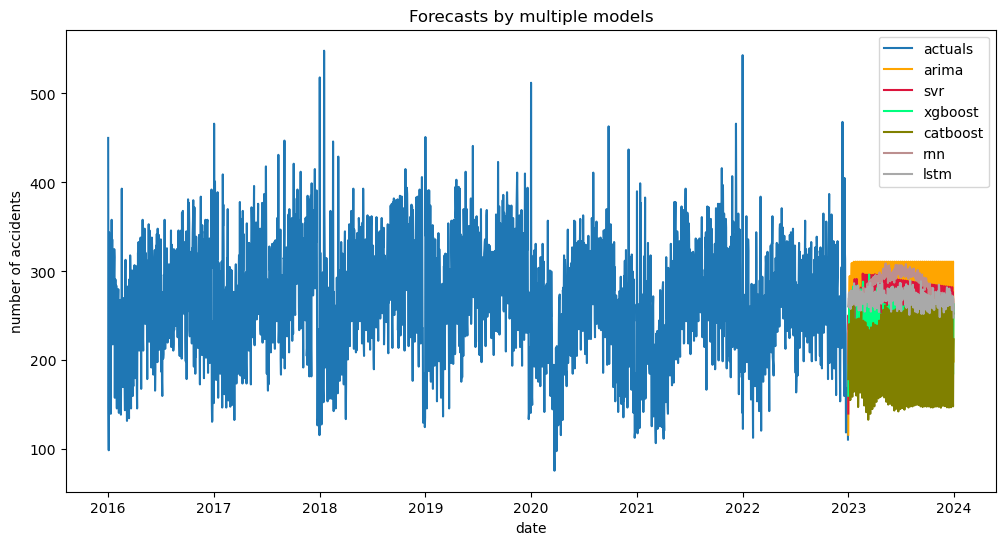

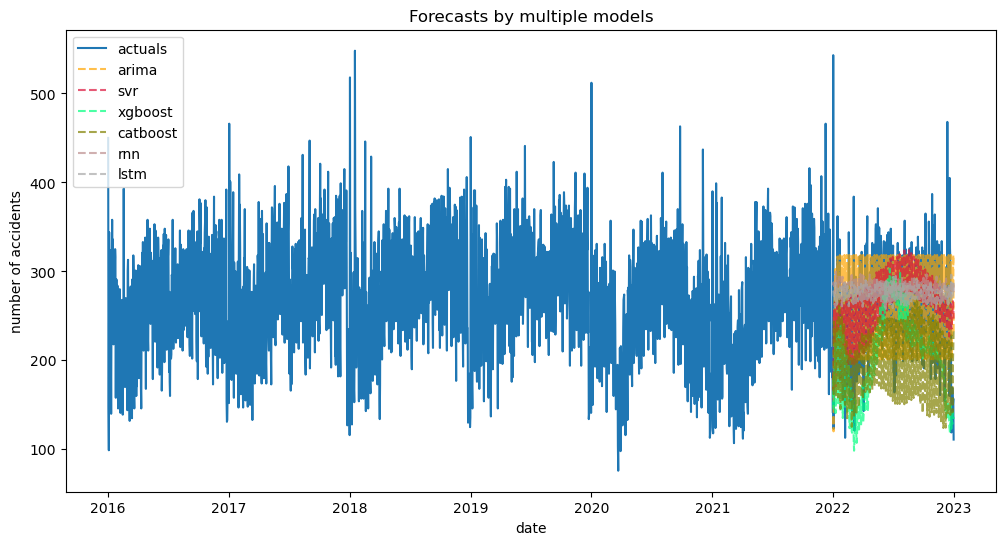

In [18]:
f_model.plot()  # plots future values
plt.title("Forecasts by multiple models")
plt.xlabel("date")
plt.ylabel("number of accidents")
f_model.plot_test_set()  # plots values from test set
plt.title("Forecasts by multiple models")
plt.xlabel("date")
plt.ylabel("number of accidents")

In [19]:
# add forecasts from models in Forecaster to predict_df
for method in forecaster_estimators:
    result = f_model.export_fitted_vals(method)
    predict_df[method] = [None] * len(dataset_train) + list(result.tail(periods_to_predict + periods_to_predict)['FittedVals'])

In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn_genetic import GASearchCV
from sklearn_genetic import ExponentialAdapter
from sklearn_genetic.space import Continuous, Categorical, Integer
from sklearn_genetic.plots import plot_fitness_evolution
from sklearn.metrics import accuracy_score

In [21]:
# split datetime to day, month, and year parts for models with GA
dataset_ga = dataset_df
dataset_ga['day'] = dataset_df['ds'].dt.day
dataset_ga['month'] = dataset_df['ds'].dt.month
dataset_ga['year'] = dataset_df['ds'].dt.year
dataset_ga['temp'] = dataset_df['temp']
dataset_ga

ds    y  temp  day  month  year
0    2016-01-01  450  -0.6    1      1  2016
1    2016-01-02  148  -0.3    2      1  2016
2    2016-01-03   99  -4.4    3      1  2016
3    2016-01-04  344  -5.9    4      1  2016
4    2016-01-05  271  -4.7    5      1  2016
...         ...  ...   ...  ...    ...   ...
2552 2022-12-27  169   2.7   27     12  2022
2553 2022-12-28  157   3.6   28     12  2022
2554 2022-12-29  151   8.1   29     12  2022
2555 2022-12-30  157   6.7   30     12  2022
2556 2022-12-31  111  12.6   31     12  2022

[2557 rows x 6 columns]

In [22]:
# split data to training and testing sets
X = dataset_ga[['day', 'month', 'year', 'temp']]
y = dataset_ga['y']
X_train_ga = X[:len(X) - periods_to_predict]
X_test_ga = X[len(X) - periods_to_predict:]
y_train_ga = y[:len(y) - periods_to_predict]  # test set = observations from the last year
y_test_ga = y[len(y) - periods_to_predict:]
X_train_ga.shape, X_test_ga.shape, y_train_ga.shape, y_test_ga.shape

((2192, 4), (365, 4), (2192,), (365,))

In [23]:
rf = RandomForestRegressor(random_state=111)

In [24]:
# adapters used in GA Search
mutation_adapter = ExponentialAdapter(initial_value=0.9, end_value=0.1, adaptive_rate=0.1)
crossover_adapter = ExponentialAdapter(initial_value=0.1, end_value=0.9, adaptive_rate=0.1)

In [25]:
# grid with attributes for random forest, for genetic algorithm
rf_grid_ga = {
    'n_estimators': Integer(100, 600),
    'max_features': Categorical(['auto', 'sqrt', 'log2']),
    'max_depth': Integer(2,20),
    'criterion': Categorical(['poisson', 'squared_error', 'absolute_error', 'friedman_mse']),
    'min_samples_split': Continuous(0.1, 0.9),
    'bootstrap': Categorical([True, False])
}

In [26]:
rf_estimator_ga = GASearchCV(estimator=rf,
                             scoring='r2',
                             population_size=100,
                             generations=12,
                             mutation_probability=mutation_adapter,
                             crossover_probability=crossover_adapter,
                             param_grid=rf_grid_ga,
                             n_jobs=-1,
                             error_score='raise'
                            )

In [27]:
rf_estimator_ga.fit(X_train_ga, y_train_ga)  # fit the training data

gen	nevals	fitness   	fitness_std	fitness_max	fitness_min
0  	100   	-0.0638615	0.168374   	0.00382714 	-1.57865   
1  	200   	-0.0159607	0.0213886  	0.00382714 	-0.106602  
2  	200   	-0.00388706	0.00877086 	0.00422686 	-0.0436928 
3  	200   	0.000542915	0.00408773 	0.00422686 	-0.0141848 
4  	200   	0.00231983 	0.0026191  	0.00422686 	-0.0172726 
5  	200   	0.00332613 	0.000772367	0.00422686 	-0.0005504 
6  	200   	0.00372454 	0.000650117	0.00422686 	-0.0005504 
7  	200   	0.00396242 	0.000312988	0.00422686 	0.00247582 
8  	200   	0.0041163  	0.000224205	0.00422686 	0.00281275 
9  	200   	0.00422081 	6.01149e-05	0.00422686 	0.00362268 
10 	200   	0.00421018 	0.00016594 	0.00422686 	0.0025591  
11 	200   	0.00422686 	0          	0.00422686 	0.00422686 
12 	200   	0.00422686 	0          	0.00422686 	0.00422686 


GASearchCV(crossover_probability=<sklearn_genetic.schedules.schedulers.ExponentialAdapter object at 0x000001EC2D506B80>,
           error_score='raise',
           estimator=RandomForestRegressor(bootstrap=False, max_depth=16,
                                           max_features='log2',
                                           min_samples_split=0.8032555441799499,
                                           n_estimators=108, random_state=111),
           generations=12,
           mutation_probability=<sklearn_genetic.schedul...
                       'max_depth': <sklearn_genetic.space.space.Integer object at 0x000001EC04023130>,
                       'max_features': <sklearn_genetic.space.space.Categorical object at 0x000001EC04023550>,
                       'min_samples_split': <sklearn_genetic.space.space.Continuous object at 0x000001EC04023A30>,
                       'n_estimators': <sklearn_genetic.space.space.Integer object at 0x000001EC040233A0>},
           population_size=100, return_train_score=True, scoring='r2')

In [28]:
rf_estimator_ga.best_params_

{'n_estimators': 108,
 'max_features': 'log2',
 'max_depth': 16,
 'criterion': 'squared_error',
 'min_samples_split': 0.8032555441799499,
 'bootstrap': False}

In [29]:
# prepare testing data with future dates in the length of argument months_to_predict
last_date = dataset_ga.ds.max()
future_dates = pd.date_range(start=last_date, periods=periods_to_predict + 1, freq='1d')
new_rows = pd.DataFrame(future_dates, columns=['ds'])
new_rows = new_rows.iloc[1:]
new_rows['day'] = new_rows['ds'].dt.day
new_rows['month'] = new_rows['ds'].dt.month
new_rows['year'] = new_rows['ds'].dt.year
new_rows['temp'] = [10] * len(new_rows)
X_test_ga = pd.concat([X_test_ga, new_rows])

In [30]:
X_test_ga = X_test_ga[['day', 'month', 'year', 'temp']]
X_test_ga

day  month  year  temp
2192    1      1  2022   9.7
2193    2      1  2022   6.7
2194    3      1  2022   7.8
2195    4      1  2022   7.7
2196    5      1  2022   2.8
...   ...    ...   ...   ...
361    27     12  2023  10.0
362    28     12  2023  10.0
363    29     12  2023  10.0
364    30     12  2023  10.0
365    31     12  2023  10.0

[730 rows x 4 columns]

In [31]:
y_predict_rf_ga = rf_estimator_ga.predict(X_test_ga)  # predict future dates

In [32]:
y_predict_rf_ga

array([257.66341417, 257.66341417, 257.66341417, 257.66341417,
       257.66341417, 257.66341417, 257.66341417, 257.66341417,
       257.66341417, 257.66341417, 257.66341417, 257.66341417,
       257.66341417, 257.66341417, 257.66341417, 257.66341417,
       257.66341417, 257.66341417, 257.66341417, 257.66341417,
       257.66341417, 257.66341417, 257.66341417, 257.66341417,
       257.66341417, 257.66341417, 257.66341417, 257.66341417,
       257.66341417, 257.66341417, 257.66341417, 257.66341417,
       257.66341417, 257.66341417, 257.66341417, 257.66341417,
       257.66341417, 257.66341417, 257.66341417, 257.66341417,
       257.66341417, 257.66341417, 257.66341417, 257.66341417,
       257.66341417, 257.66341417, 257.66341417, 257.66341417,
       257.66341417, 257.66341417, 257.66341417, 257.66341417,
       257.66341417, 257.66341417, 257.66341417, 257.66341417,
       257.66341417, 257.66341417, 257.66341417, 257.66341417,
       257.66341417, 257.66341417, 257.66341417, 257.66

C:\Users\katka\anaconda3\lib\site-packages\sklearn_genetic\plots.py:48: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(x=range(len(estimator)), y=fitness_history, markers=True, palette=palette)


<Axes: title={'center': 'Fitness average evolution over generations'}, xlabel='generations', ylabel='fitness (score)'>

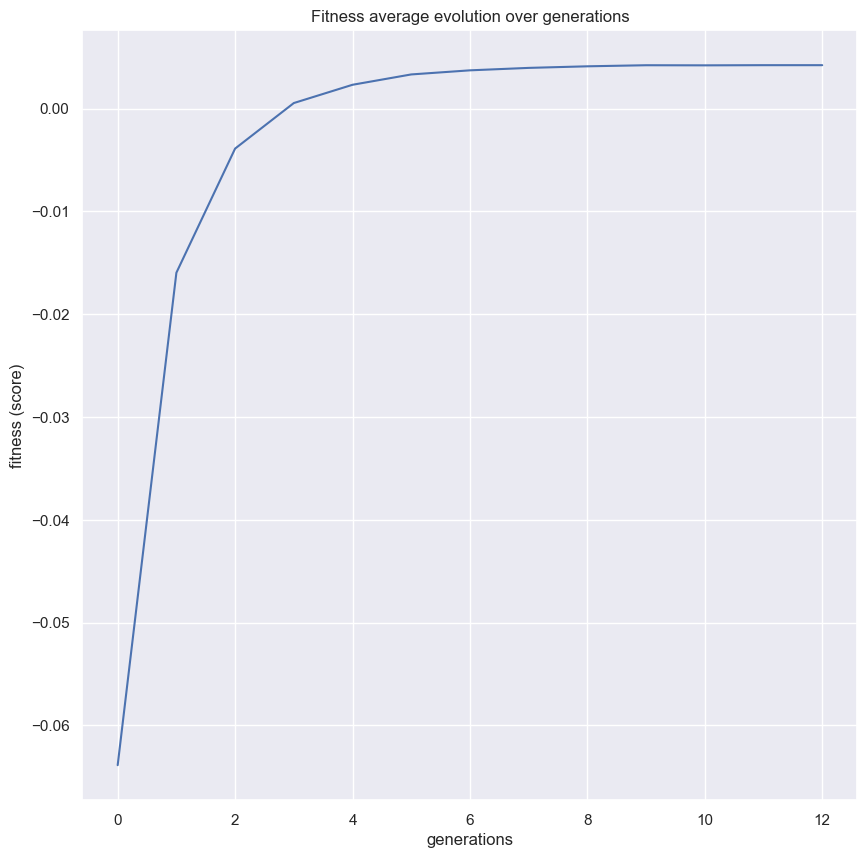

In [33]:
plot_fitness_evolution(rf_estimator_ga)

In [34]:
# prepare dataframe with forecast values (predict_df will contain all hyperparameter optimization techniques)
rf_predict_df = dataset_df[['ds']]

last_date = rf_predict_df.ds.max()
future_dates = pd.date_range(start=last_date, periods=periods_to_predict + 1, freq='1d')
new_rows = pd.DataFrame(future_dates, columns=['ds'])
new_rows = new_rows.iloc[1:]

rf_predict_df = pd.concat([rf_predict_df, new_rows])

rf_predict_df['original'] = list(y_train_ga) + list(y_test_ga) + [None] * periods_to_predict
rf_predict_df['predicted - GA'] = [None] * len(X_train_ga) + list(y_predict_rf_ga)
rf_predict_df.set_index('ds', inplace=True)

Text(0, 0.5, 'number of accidents')

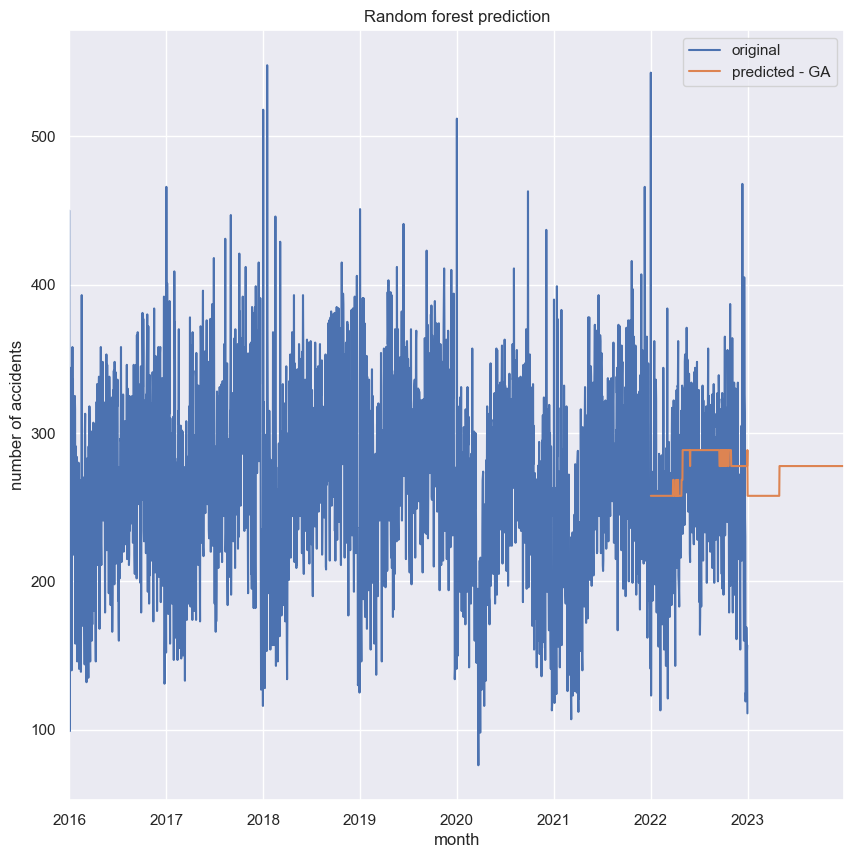

In [35]:
# plot results with random forest and GA
rf_predict_df.plot()
plt.title("Random forest prediction")
plt.xlabel("month")
plt.ylabel("number of accidents")

In [36]:
# create grid for randomized searach cv
rf_grid_randomized = {
    'n_estimators': [100, 600],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [2, 20],
    'criterion': ['poisson', 'squared_error', 'absolute_error', 'friedman_mse'],
    'min_samples_split': [0.1, 0.9],
    'bootstrap': [True, False]
}

In [37]:
from sklearn.model_selection import RandomizedSearchCV

In [38]:
rf = RandomForestRegressor(random_state=111)
rf_estimator_randomized = RandomizedSearchCV(estimator=rf,
                                             scoring='r2',
                                             param_distributions = rf_grid_randomized,
                                             n_jobs=-1,
                                             error_score='raise',
                                             random_state=111
                                            )

In [39]:
rf_estimator_randomized.fit(X_train_ga, y_train_ga)

RandomizedSearchCV(error_score='raise',
                   estimator=RandomForestRegressor(random_state=111), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['poisson',
                                                      'squared_error',
                                                      'absolute_error',
                                                      'friedman_mse'],
                                        'max_depth': [2, 20],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_split': [0.1, 0.9],
                                        'n_estimators': [100, 600]},
                   random_state=111, scoring='r2')

In [40]:
rf_estimator_randomized.best_params_

{'n_estimators': 100,
 'min_samples_split': 0.1,
 'max_features': 'sqrt',
 'max_depth': 20,
 'criterion': 'absolute_error',
 'bootstrap': False}

In [41]:
y_predict_rf_randomized = rf_estimator_randomized.predict(X_test_ga)

In [42]:
rf_predict_df['predicted - randomized'] = [None] * len(X_train_ga) + list(y_predict_rf_randomized)

Text(0, 0.5, 'number of accidents')

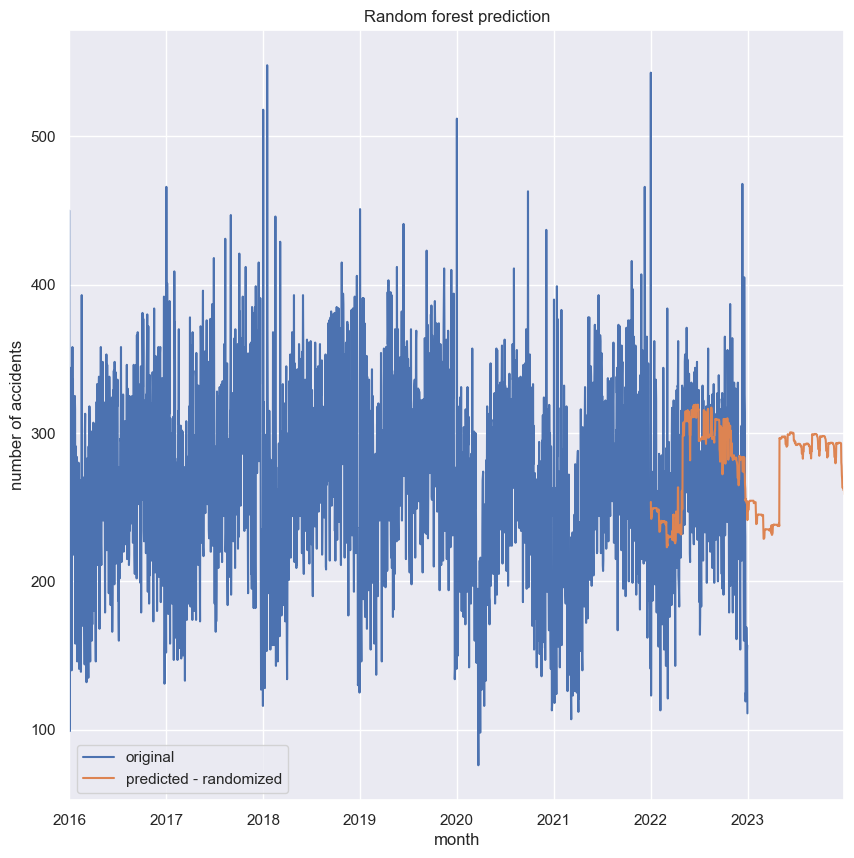

In [43]:
# plot results with random forest and randomized search cv
rf_predict_df[['original', 'predicted - randomized']].plot()
plt.title("Random forest prediction")
plt.xlabel("month")
plt.ylabel("number of accidents")

In [44]:
# grid for grid search cv
rf_grid_grid = {
    'n_estimators': [100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [2, 10, 20],
    'criterion': ['poisson', 'squared_error', 'absolute_error', 'friedman_mse'],
    'min_samples_split': [0.1, 0.5, 0.9],
    'bootstrap': [True, False]
}

In [45]:
from sklearn.model_selection import GridSearchCV

In [46]:
from sklearn.model_selection import GridSearchCV
rf_estimator_grid = GridSearchCV(estimator=rf,
                                 scoring='r2',
                                 param_grid = rf_grid_grid,
                                 n_jobs=-1,
                                 error_score='raise'
                                )

In [47]:
y_predict_rf_grid = rf_estimator_grid.fit(X_train_ga, y_train_ga)

In [48]:
rf_estimator_grid.best_params_

{'bootstrap': False,
 'criterion': 'poisson',
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_split': 0.1,
 'n_estimators': 200}

In [49]:
y_predict_rf_grid = rf_estimator_grid.predict(X_test_ga)

In [50]:
y_predict_rf_grid

array([265.69384055, 238.84435775, 238.96495924, 238.96495924,
       238.98705044, 241.42381584, 241.42381584, 242.54129905,
       239.67914418, 240.20604791, 242.54129905, 242.54129905,
       239.67914418, 240.20604791, 240.13372014, 242.54129905,
       240.48246489, 239.67914418, 240.13372014, 240.13372014,
       242.54129905, 240.13372014, 240.27121268, 240.44838545,
       240.44838545, 240.44838545, 240.44838545, 240.44838545,
       240.73921088, 241.12438346, 240.73921088, 260.91276239,
       234.13173367, 234.13173367, 234.23213404, 234.27442636,
       234.91826525, 234.68881345, 234.56541866, 234.78072821,
       234.78072821, 234.68032785, 234.3315831 , 234.3315831 ,
       234.68032785, 234.60800008, 234.70840044, 234.85372978,
       234.64067482, 234.64067482, 234.64067482, 234.64067482,
       234.76972625, 234.42942262, 235.43490135, 234.82666977,
       234.82666977, 234.82666977, 235.74433184, 255.05296308,
       226.56890681, 226.56890681, 226.91149582, 226.56

In [51]:
rf_predict_df['predicted - grid'] = [None] * len(X_train_ga) + list(y_predict_rf_grid)

Text(0, 0.5, 'number of accidents')

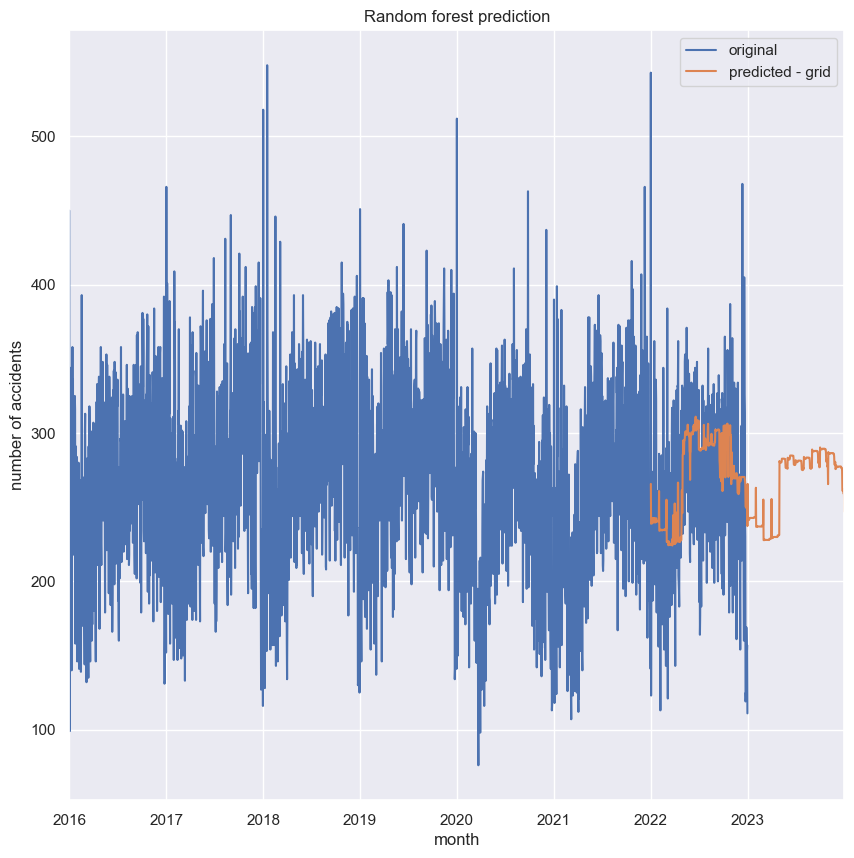

In [52]:
# plot results with random forest and grid search cv
rf_predict_df[['original', 'predicted - grid']].plot()
plt.title("Random forest prediction")
plt.xlabel("month")
plt.ylabel("number of accidents")

In [53]:
# r2 score with GA search cv
rf_estimator_ga.score(X_test_ga[:periods_to_predict], y_test_ga)

0.043436008845624596

In [54]:
# r2 score with randomized search cv
rf_estimator_randomized.score(X_test_ga[:periods_to_predict], y_test_ga)

0.0492908547376375

In [55]:
# r2 score with grid search cv
rf_estimator_grid.score(X_test_ga[:periods_to_predict], y_test_ga)

0.08843554424787392

Text(0, 0.5, 'number of accidents')

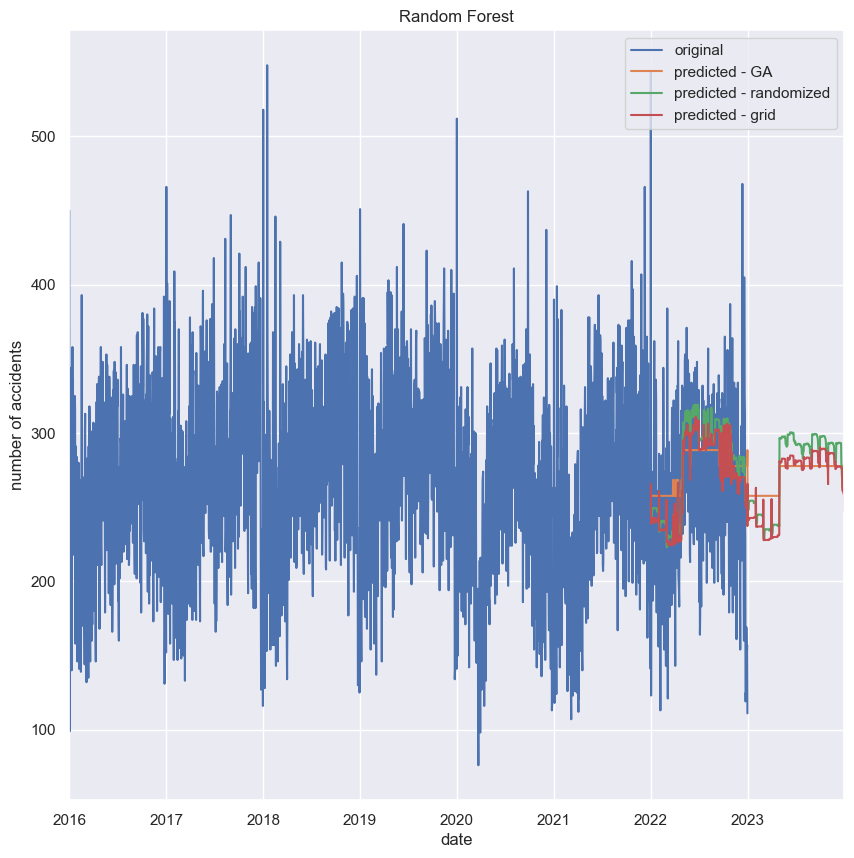

In [56]:
# plot all 3 techniques for random forest on one plot
rf_predict_df.plot()
plt.title("Random Forest")
plt.xlabel("date")
plt.ylabel("number of accidents")

In [57]:
predict_df['random forest + GA'] = list(rf_predict_df['predicted - GA'])
predict_df['random forest + randomized'] = list(rf_predict_df['predicted - randomized'])
predict_df['random forest + grid'] = list(rf_predict_df['predicted - grid'])

predict_df

original  temp     prophet       arima         svr     xgboost  \
ds                                                                           
2016-01-01     450.0  -0.6         NaN         NaN         NaN         NaN   
2016-01-02     148.0  -0.3         NaN         NaN         NaN         NaN   
2016-01-03      99.0  -4.4         NaN         NaN         NaN         NaN   
2016-01-04     344.0  -5.9         NaN         NaN         NaN         NaN   
2016-01-05     271.0  -4.7         NaN         NaN         NaN         NaN   
...              ...   ...         ...         ...         ...         ...   
2023-12-27       NaN  10.0  313.486752  201.620251  248.666615  168.264496   
2023-12-28       NaN  10.0  310.874906  204.317464  234.969947  151.167664   
2023-12-29       NaN  10.0  328.197688  217.440162  226.118038  154.053253   
2023-12-30       NaN  10.0  237.712232  225.309309  240.963728  153.283981   
2023-12-31       NaN  10.0  209.610036  136.078315  153.172227  115.143616   

              catboost         rnn        lstm  random forest + GA  \
ds                                                                   
2016-01-01         NaN         NaN         NaN                 NaN   
2016-01-02         NaN         NaN         NaN                 NaN   
2016-01-03         NaN         NaN         NaN                 NaN   
2016-01-04         NaN         NaN         NaN                 NaN   
2016-01-05         NaN         NaN         NaN                 NaN   
...                ...         ...         ...                 ...   
2023-12-27  170.111394  299.471075  273.301703          277.745586   
2023-12-28  165.140365  295.662348  277.616409          277.745586   
2023-12-29  157.369136  292.170178  275.650250          277.745586   
2023-12-30  151.179452  287.492735  275.454822          277.745586   
2023-12-31  123.111052  285.296501  257.715719          277.745586   

            random forest + randomized  random forest + grid  
ds                                                            
2016-01-01                         NaN                   NaN  
2016-01-02                         NaN                   NaN  
2016-01-03                         NaN                   NaN  
2016-01-04                         NaN                   NaN  
2016-01-05                         NaN                   NaN  
...                                ...                   ...  
2023-12-27                     263.605            262.122698  
2023-12-28                     261.560            259.269975  
2023-12-29                     261.560            259.269975  
2023-12-30                     261.560            259.269975  
2023-12-31                     258.785            247.097244  

[2922 rows x 12 columns]

In [58]:
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import MinMaxScaler

In [59]:
# # pipeline with data scaling and random forest
# steps = [
#     ('scaler', MinMaxScaler()),  # Data preprocessing step
#     ('rf', RandomForestRegressor(random_state=111))  # Random Forest Regressor step
# ]

In [60]:
# pipeline = Pipeline(steps)

In [61]:
# # GA search cv with pipeline
# rf_grid_ga = {
#     'rf__n_estimators': Integer(100, 600),
#     'rf__max_features': Categorical(['auto', 'sqrt', 'log2']),
#     'rf__max_depth': Integer(2,20),
#     'rf__criterion': Categorical(['poisson', 'squared_error', 'absolute_error', 'friedman_mse']),
#     'rf__min_samples_split': Continuous(0.1, 0.9),
#     'rf__bootstrap': Categorical([True, False])
# }

# rf_estimator_ga = GASearchCV(estimator=pipeline,
#                              scoring='r2',
#                              population_size=100,
#                              generations=12,
#                              mutation_probability=mutation_adapter,
#                              crossover_probability=crossover_adapter,
#                              param_grid=rf_grid_ga,
#                              n_jobs=-1,
#                              error_score='raise'
#                             )

In [62]:
# rf_estimator_ga.fit(X_train_ga, y_train_ga)

In [63]:
# y_predict_rf_ga = rf_estimator_ga.predict(X_test_ga)

In [64]:
# y_predict_rf_ga

In [65]:
# # r2 score for random forest with GA and pipeline
# rf_estimator_ga.score(X_test_ga[:periods_to_predict], y_test_ga)

In [66]:
# rf_predict_df['predicted - GA - pipe'] = [None] * len(X_train_ga) + list(y_predict_rf_ga)

In [67]:
# # plot results of random forest regressor with pipeline and GA search cv
# rf_predict_df[['original', 'predicted - GA - pipe']].plot()
# plt.title("Random forest prediction")
# plt.xlabel("month")
# plt.ylabel("number of accidents")

In [68]:
from sklearn.neural_network import MLPRegressor
from sklearn import preprocessing

In [69]:
mlp = MLPRegressor(random_state=111)

In [70]:
# adapters for MLP with GA search cv
mutation_adapter = ExponentialAdapter(initial_value=0.9, end_value=0.1, adaptive_rate=0.1)
crossover_adapter = ExponentialAdapter(initial_value=0.1, end_value=0.9, adaptive_rate=0.1)

In [71]:
# prepare data for MLP
scaler = StandardScaler()
scaler.fit(dataset_ga[['day', 'month', 'year', 'y', 'temp']].head(len(dataset_ga) - periods_to_predict))  # fit the scaler with training data

# generate new dates
new_rows['day'] = new_rows['ds'].dt.day
new_rows['month'] = new_rows['ds'].dt.month
new_rows['year'] = new_rows['ds'].dt.year
new_rows['temp'] = [10] * len(new_rows)
scaled_data = dataset_df[['day', 'month', 'year', 'y', 'temp']]
scaled_data = pd.concat([scaled_data, new_rows[['day', 'month', 'year', 'temp']]])
scaled_data = pd.DataFrame(scaler.transform(scaled_data[['day', 'month', 'year', 'y', 'temp']]), columns=['day', 'month', 'year', 'y', 'temp'])

X = scaled_data[['day', 'month', 'year', 'temp']]
y = scaled_data['y']

# split the scaled data to train and test set
X_train_scale = X.head(len(X) - periods_to_predict - periods_to_predict)
X_test_scale = X.tail(periods_to_predict + periods_to_predict)
y_train_scale = y.head(len(X) - periods_to_predict - periods_to_predict)
y_test_scale = y.tail(periods_to_predict + periods_to_predict)
X_train_scale.shape, X_test_scale.shape, y_train_scale.shape, y_test_scale.shape

((2192, 4), (730, 4), (2192,), (730,))

In [72]:
# hyperparameters in MLP model with GA
mlp_grid_ga = {
    "hidden_layer_sizes": Integer(5, 200), 
    "activation": Categorical(["identity", "logistic", "tanh", "relu"]), 
    "solver": Categorical(["lbfgs", "sgd", "adam"]), 
    "alpha": Continuous(0.00005, 0.05),
    "learning_rate": Categorical(["constant", "invscaling", "adaptive"]),
    "max_iter": Integer(150, 300)
}

In [73]:
mlp_estimator_ga = GASearchCV(estimator=mlp,
                             scoring='r2',
                             population_size=200,
                             generations=12,
                             mutation_probability=mutation_adapter,
                             crossover_probability=crossover_adapter,
                             param_grid=mlp_grid_ga,
                             n_jobs=-1,
                             error_score='raise'
                            )

In [74]:
mlp_estimator_ga.fit(X_train_scale, y_train_scale)

gen	nevals	fitness  	fitness_std	fitness_max	fitness_min
0  	200   	-0.334605	0.568729   	0.00349597 	-4.58837   
1  	400   	-0.102394	0.066581   	-0.0155517 	-0.75755   
2  	400   	-0.0663131	0.0307978  	0.0037508  	-0.136431  
3  	400   	-0.044261 	0.0216879  	0.00824804 	-0.111757  
4  	400   	-0.0320548	0.0164278  	0.0151766  	-0.101412  
5  	400   	-0.0248682	0.0192702  	0.0151766  	-0.139095  
6  	400   	-0.0165608	0.0135849  	0.0151766  	-0.0546478 
7  	400   	-0.0081106	0.0179392  	0.0151766  	-0.12112   
8  	400   	0.00234515	0.0159085  	0.0151766  	-0.128444  
9  	400   	0.010878  	0.00721629 	0.0151766  	-0.0332323 
10 	400   	0.0135935 	0.00749794 	0.0151766  	-0.0867384 
11 	400   	0.0151    	0.00051374 	0.0151766  	0.00971856 
12 	400   	0.015152  	0.00024453 	0.0151766  	0.0127189  


GASearchCV(crossover_probability=<sklearn_genetic.schedules.schedulers.ExponentialAdapter object at 0x000001EC03FAFEE0>,
           error_score='raise',
           estimator=MLPRegressor(activation='tanh', alpha=0.039394309441885926,
                                  hidden_layer_sizes=50,
                                  learning_rate='invscaling', max_iter=254,
                                  random_state=111, solver='sgd'),
           generations=12,
           mutation_probability=<sklearn_genetic...
                       'hidden_layer_sizes': <sklearn_genetic.space.space.Integer object at 0x000001EC03F7DD90>,
                       'learning_rate': <sklearn_genetic.space.space.Categorical object at 0x000001EC03F7D580>,
                       'max_iter': <sklearn_genetic.space.space.Integer object at 0x000001EC03F7DE80>,
                       'solver': <sklearn_genetic.space.space.Categorical object at 0x000001EC03F7DE20>},
           population_size=200, return_train_score=True, scoring='r2')

In [75]:
mlp_estimator_ga.best_params_

{'hidden_layer_sizes': 50,
 'activation': 'tanh',
 'solver': 'sgd',
 'alpha': 0.039394309441885926,
 'learning_rate': 'invscaling',
 'max_iter': 254}

In [76]:
y_predict_mlp_ga = mlp_estimator_ga.predict(X_test_scale)
y_predict_mlp_ga

array([-4.41171586e-01, -5.31631344e-01, -4.94710388e-01, -4.95404003e-01,
       -6.40154586e-01, -7.23964598e-01, -7.61607637e-01, -7.16926372e-01,
       -7.13916557e-01, -6.73374338e-01, -7.70167947e-01, -7.70478363e-01,
       -7.12936146e-01, -6.60222735e-01, -6.78201023e-01, -7.52194151e-01,
       -6.62840594e-01, -7.17963915e-01, -7.04568988e-01, -7.14494162e-01,
       -7.94950791e-01, -7.01140010e-01, -6.77356377e-01, -6.71864195e-01,
       -6.92732118e-01, -7.27633079e-01, -7.31900899e-01, -6.83398106e-01,
       -6.74612507e-01, -6.43821690e-01, -7.12692319e-01, -6.74260667e-01,
       -6.00207575e-01, -6.02276407e-01, -5.40096535e-01, -6.04830926e-01,
       -5.58465077e-01, -6.00364774e-01, -5.63563841e-01, -4.89748060e-01,
       -4.73356644e-01, -5.60714496e-01, -6.49411927e-01, -6.18530143e-01,
       -6.04545589e-01, -5.58547894e-01, -5.02389084e-01, -4.44957064e-01,
       -4.95862285e-01, -5.21711169e-01, -5.14381092e-01, -5.01084763e-01,
       -5.59582218e-01, -

In [77]:
# r2 score for MLP with GA
mlp_estimator_ga.score(X_test_scale.head(periods_to_predict), y_test_scale.head(periods_to_predict))

0.031232205071561103

In [78]:
# create dataframe with forecast (MLP + GA)
predictions_unscaled = X_test_scale
predictions_unscaled['y'] = y_predict_mlp_ga.tolist()
predictions_unscaled = pd.DataFrame(scaler.inverse_transform(predictions_unscaled), columns=['day', 'month', 'year', 'y', 'temp'])
predictions_unscaled

C:\Users\katka\AppData\Local\Temp\ipykernel_12800\1264332695.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions_unscaled['y'] = y_predict_mlp_ga.tolist()


day  month    year           y       temp
0     1.0    1.0  2022.0  278.002395   6.166164
1     2.0    1.0  2022.0  253.829874   5.444255
2     3.0    1.0  2022.0  262.693132   5.738901
3     4.0    1.0  2022.0  261.887381   5.733366
4     5.0    1.0  2022.0  222.405597   4.578192
..    ...    ...     ...         ...        ...
725  27.0   12.0  2023.0  280.419647  11.207714
726  28.0   12.0  2023.0  280.419647  11.198793
727  29.0   12.0  2023.0  280.419647  11.188293
728  30.0   12.0  2023.0  280.419647  11.176513
729  31.0   12.0  2023.0  280.419647  11.163747

[730 rows x 5 columns]

Text(0, 0.5, 'number of accidents')

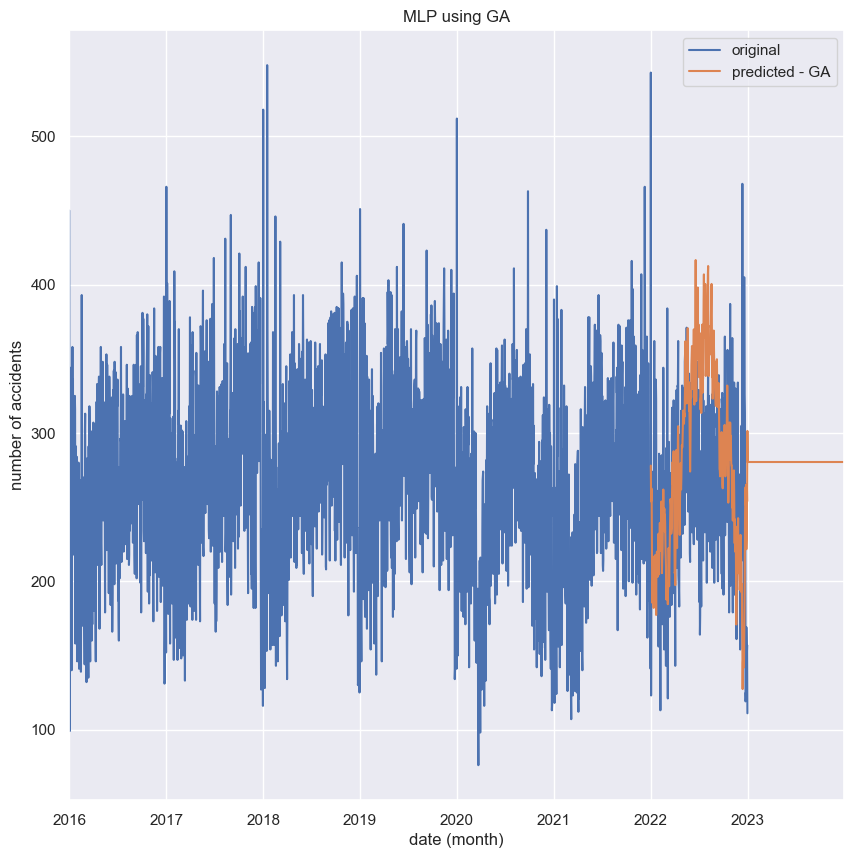

In [79]:
mlp_predict_df = pd.concat([dataset_df[['ds']], new_rows[['ds']]], ignore_index=True)  # add results to predict_df

mlp_predict_df['original'] = list(dataset_df['y']) + [None] * periods_to_predict
mlp_predict_df['predicted - GA'] = [None] * (len(mlp_predict_df) - periods_to_predict - periods_to_predict) + list(predictions_unscaled['y'])
mlp_predict_df.set_index('ds', inplace=True)
mlp_predict_df.plot()  # plot results of MLP with GA
plt.title("MLP using GA")
plt.xlabel("date (month)")
plt.ylabel("number of accidents")

C:\Users\katka\anaconda3\lib\site-packages\sklearn_genetic\plots.py:48: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(x=range(len(estimator)), y=fitness_history, markers=True, palette=palette)


<Axes: title={'center': 'Fitness average evolution over generations'}, xlabel='generations', ylabel='fitness (score)'>

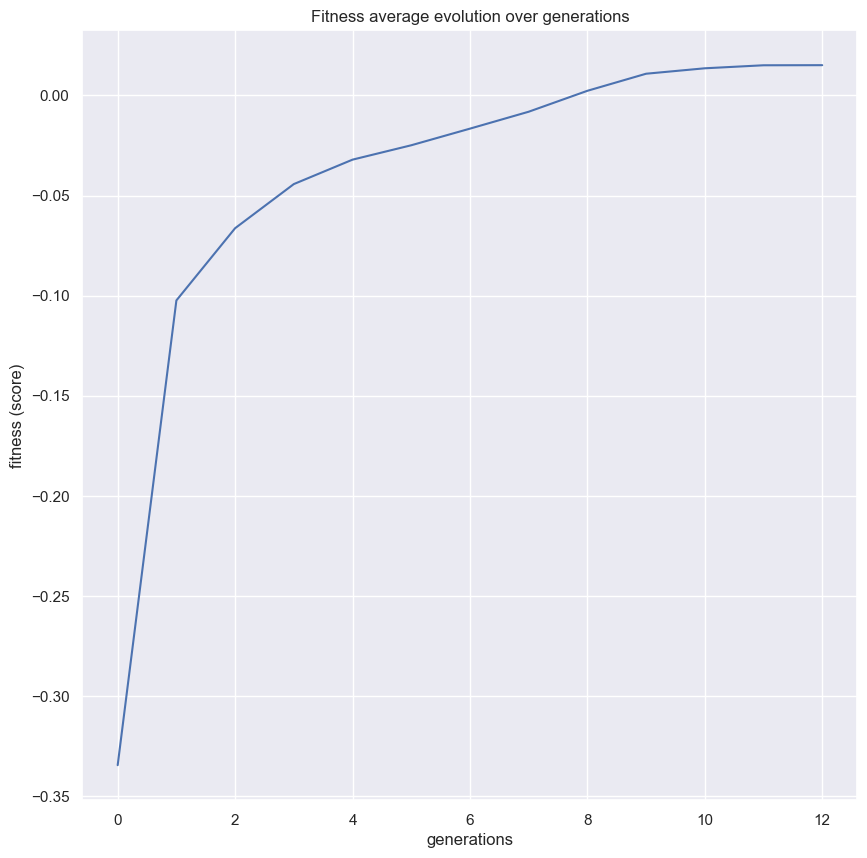

In [80]:
plot_fitness_evolution(mlp_estimator_ga)

In [81]:
# grid for MLP and Randomized search CV
mlp_grid_randomized = {
    "hidden_layer_sizes": [10, 500], 
    "activation": ["identity", "logistic", "tanh", "relu"], 
    "solver": ["lbfgs", "sgd", "adam"], 
    "alpha": [0.00005, 0.05],
    "learning_rate": ["constant", "invscaling", "adaptive"],
    "max_iter": [150, 300]
}


In [82]:
from sklearn.model_selection import RandomizedSearchCV

In [83]:
mlp_estimator_randomized = RandomizedSearchCV(estimator=mlp,
                                             scoring='neg_root_mean_squared_error',
                                             param_distributions = mlp_grid_randomized,
                                             n_jobs=-1,
                                             error_score='raise',
                                             random_state=111
                                            )

In [84]:
mlp_estimator_randomized.fit(X_train_scale, y_train_scale)

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(


RandomizedSearchCV(error_score='raise',
                   estimator=MLPRegressor(activation='tanh',
                                          alpha=0.039394309441885926,
                                          hidden_layer_sizes=50,
                                          learning_rate='invscaling',
                                          max_iter=254, random_state=111,
                                          solver='sgd'),
                   n_jobs=-1,
                   param_distributions={'activation': ['identity', 'logistic',
                                                       'tanh', 'relu'],
                                        'alpha': [5e-05, 0.05],
                                        'hidden_layer_sizes': [10, 500],
                                        'learning_rate': ['constant',
                                                          'invscaling',
                                                          'adaptive'],
                                        'max_iter': [150, 300],
                                        'solver': ['lbfgs', 'sgd', 'adam']},
                   random_state=111, scoring='neg_root_mean_squared_error')

In [85]:
mlp_estimator_randomized.best_params_

{'solver': 'sgd',
 'max_iter': 150,
 'learning_rate': 'adaptive',
 'hidden_layer_sizes': 500,
 'alpha': 0.05,
 'activation': 'relu'}

In [86]:
y_predict_mlp_randomized = mlp_estimator_randomized.predict(X_test_scale[['day', 'month', 'year', 'temp']])
y_predict_mlp_randomized

array([-7.31273842e-01, -7.93573430e-01, -7.68815878e-01, -7.67628009e-01,
       -8.52998999e-01, -8.84741713e-01, -8.95765586e-01, -8.79817612e-01,
       -8.78154528e-01, -8.55308818e-01, -9.15003248e-01, -9.20523532e-01,
       -8.81452218e-01, -8.40805449e-01, -8.56934850e-01, -9.35823064e-01,
       -8.47583008e-01, -9.12834135e-01, -9.01494103e-01, -9.17749317e-01,
       -1.02531845e+00, -8.98279582e-01, -8.59727708e-01, -8.44651006e-01,
       -8.74313655e-01, -9.33088732e-01, -9.40874824e-01, -8.43593888e-01,
       -8.24582566e-01, -7.60887608e-01, -8.95631814e-01, -8.08383581e-01,
       -7.93677939e-01, -7.97843259e-01, -7.67651008e-01, -8.04480926e-01,
       -7.77391925e-01, -8.00213080e-01, -7.77177763e-01, -7.21516495e-01,
       -7.03127608e-01, -7.70442795e-01, -8.35506184e-01, -8.18659708e-01,
       -8.11161929e-01, -7.68955684e-01, -7.01913522e-01, -6.21749368e-01,
       -6.83838665e-01, -7.15911388e-01, -7.01502744e-01, -6.74756878e-01,
       -7.62086378e-01, -

In [87]:
# r2 score for MLP regressor with randomized search cv
mlp_estimator_randomized.score(X_test_scale[['day', 'month', 'year', 'temp']].head(periods_to_predict), y_test_scale.head(periods_to_predict))

-0.8967828910147679

In [88]:
# add forecasted values to a dataframe
predictions_unscaled = X_test_scale
predictions_unscaled['y'] = y_predict_mlp_randomized.tolist()
predictions_unscaled = pd.DataFrame(scaler.inverse_transform(predictions_unscaled), columns=['day', 'month', 'year', 'y', 'temp'])
predictions_unscaled

C:\Users\katka\AppData\Local\Temp\ipykernel_12800\253082811.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions_unscaled['y'] = y_predict_mlp_randomized.tolist()


day  month    year           y      temp
0     1.0    1.0  2022.0  278.002395  3.851021
1     2.0    1.0  2022.0  253.829874  3.353843
2     3.0    1.0  2022.0  262.693132  3.551419
3     4.0    1.0  2022.0  261.887381  3.560898
4     5.0    1.0  2022.0  222.405597  2.879600
..    ...    ...     ...         ...       ...
725  27.0   12.0  2023.0  280.419647  6.638104
726  28.0   12.0  2023.0  280.419647  6.500709
727  29.0   12.0  2023.0  280.419647  6.359945
728  30.0   12.0  2023.0  280.419647  6.217884
729  31.0   12.0  2023.0  280.419647  6.073780

[730 rows x 5 columns]

Text(0, 0.5, 'number of accidents')

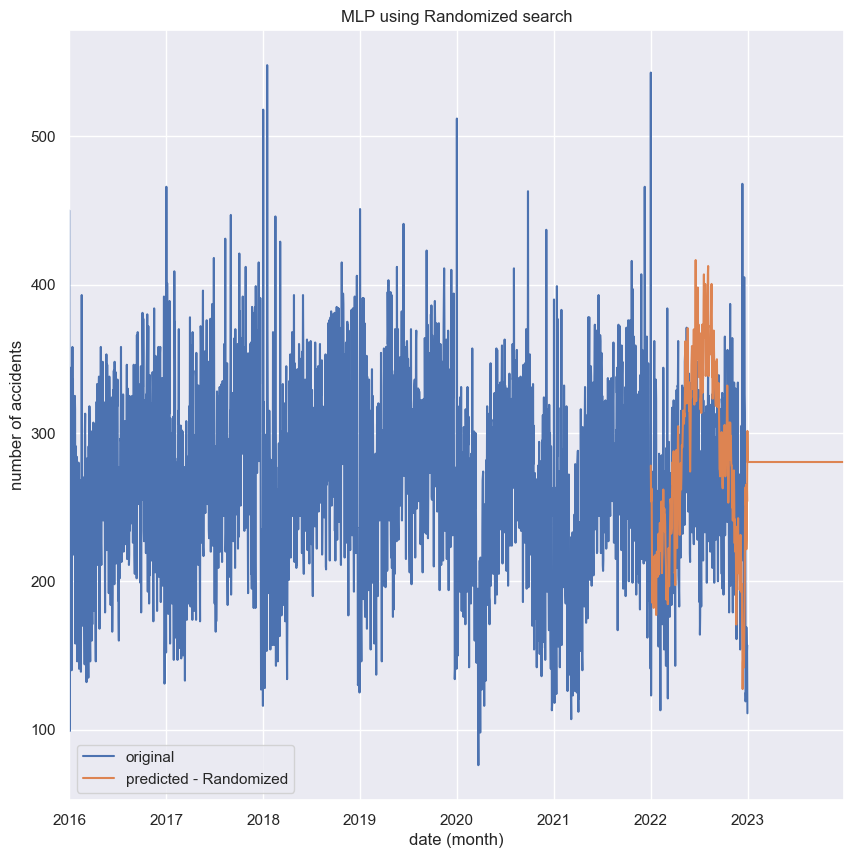

In [89]:
# plot predicted values from MLP model with randomized search cv
mlp_predict_df['predicted - Randomized'] = [None] * (len(mlp_predict_df) - periods_to_predict - periods_to_predict) + list(predictions_unscaled['y'])
mlp_predict_df[['original', 'predicted - Randomized']].plot()
plt.title("MLP using Randomized search")
plt.xlabel("date (month)")
plt.ylabel("number of accidents")

In [90]:
# grid for MLP and Grid search CV
mlp_grid = {
    "hidden_layer_sizes": [10, 250, 500], 
    "activation": ["identity", "logistic", "tanh", "relu"], 
    "solver": ["lbfgs", "sgd", "adam"], 
    "alpha": [0.00005, 0.005, 0.05],
    "learning_rate": ["constant", "invscaling", "adaptive"],
    "max_iter": [150, 300]
}

In [91]:
mlp_estimator_grid = GridSearchCV(estimator=mlp,
                                  scoring='neg_root_mean_squared_error',
                                  param_grid = mlp_grid_randomized,
                                  n_jobs=-1,
                                  error_score='raise'
                                 )

In [92]:
mlp_estimator_grid.fit(X_train_scale, y_train_scale)

GridSearchCV(error_score='raise',
             estimator=MLPRegressor(activation='tanh',
                                    alpha=0.039394309441885926,
                                    hidden_layer_sizes=50,
                                    learning_rate='invscaling', max_iter=254,
                                    random_state=111, solver='sgd'),
             n_jobs=-1,
             param_grid={'activation': ['identity', 'logistic', 'tanh', 'relu'],
                         'alpha': [5e-05, 0.05],
                         'hidden_layer_sizes': [10, 500],
                         'learning_rate': ['constant', 'invscaling',
                                           'adaptive'],
                         'max_iter': [150, 300],
                         'solver': ['lbfgs', 'sgd', 'adam']},
             scoring='neg_root_mean_squared_error')

In [93]:
mlp_estimator_grid.best_params_

{'activation': 'relu',
 'alpha': 5e-05,
 'hidden_layer_sizes': 500,
 'learning_rate': 'adaptive',
 'max_iter': 300,
 'solver': 'sgd'}

In [94]:
y_predict_mlp_grid = mlp_estimator_grid.predict(X_test_scale[['day', 'month', 'year', 'temp']])
y_predict_mlp_grid

array([-0.73387176, -0.79609451, -0.77133907, -0.77007954, -0.85497707,
       -0.88643145, -0.89722001, -0.88140961, -0.87960955, -0.85695376,
       -0.91637513, -0.92194005, -0.88306591, -0.84259304, -0.85872056,
       -0.93772968, -0.84961603, -0.91491347, -0.90357171, -0.91983192,
       -1.02737043, -0.90028395, -0.86165977, -0.84655127, -0.87625347,
       -0.93514327, -0.94286072, -0.8453277 , -0.82624561, -0.76237829,
       -0.89741556, -0.81032752, -0.79588846, -0.8000162 , -0.76996511,
       -0.80661064, -0.77963208, -0.80226106, -0.77926881, -0.72385711,
       -0.70533215, -0.77240619, -0.83725616, -0.82049172, -0.81311401,
       -0.77111826, -0.70400772, -0.62375908, -0.68591134, -0.71788021,
       -0.70338556, -0.67654833, -0.76406371, -0.69360466, -0.72960762,
       -0.8106749 , -0.85089741, -0.89470512, -1.02638387, -0.73241663,
       -0.73944623, -0.74671234, -0.75786618, -0.76250804, -0.77966992,
       -0.77898793, -0.76242974, -0.74296419, -0.7654146 , -0.80

In [95]:
# r2 score for MLP regressor with grid search cv
mlp_estimator_grid.score(X_test_scale[['day', 'month', 'year', 'temp']].head(periods_to_predict), y_test_scale.head(periods_to_predict))

-0.8970264070875678

In [96]:
# add forecasted values to a dataframe
predictions_unscaled = X_test_scale
predictions_unscaled['y'] = y_predict_mlp_grid.tolist()
predictions_unscaled = pd.DataFrame(scaler.inverse_transform(predictions_unscaled), columns=['day', 'month', 'year', 'y', 'temp'])
predictions_unscaled

C:\Users\katka\AppData\Local\Temp\ipykernel_12800\333026508.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions_unscaled['y'] = y_predict_mlp_grid.tolist()


day  month    year           y      temp
0     1.0    1.0  2022.0  278.002395  3.830288
1     2.0    1.0  2022.0  253.829874  3.333723
2     3.0    1.0  2022.0  262.693132  3.531283
3     4.0    1.0  2022.0  261.887381  3.541334
4     5.0    1.0  2022.0  222.405597  2.863815
..    ...    ...     ...         ...       ...
725  27.0   12.0  2023.0  280.419647  6.615813
726  28.0   12.0  2023.0  280.419647  6.478385
727  29.0   12.0  2023.0  280.419647  6.337208
728  30.0   12.0  2023.0  280.419647  6.195387
729  31.0   12.0  2023.0  280.419647  6.050795

[730 rows x 5 columns]

Text(0, 0.5, 'number of accidents')

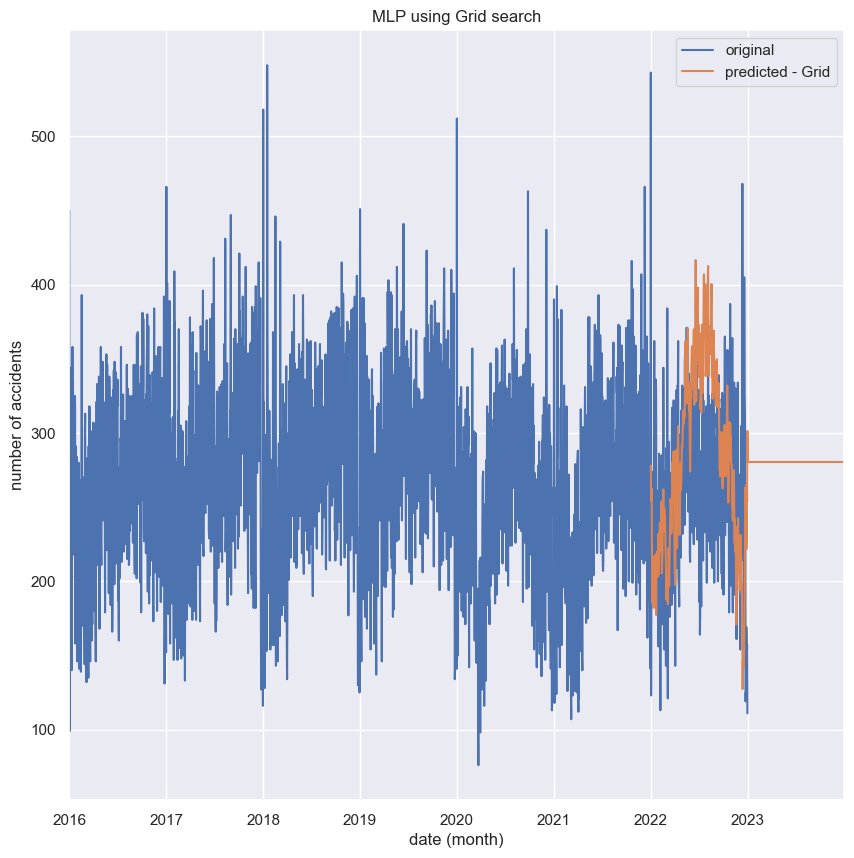

In [97]:
# plot predicted values from MLP model with grid search cv
mlp_predict_df['predicted - Grid'] = [None] * (len(mlp_predict_df) - periods_to_predict - periods_to_predict) + list(predictions_unscaled['y'])
mlp_predict_df[['original', 'predicted - Grid']].plot()
plt.title("MLP using Grid search")
plt.xlabel("date (month)")
plt.ylabel("number of accidents")

In [98]:
predict_df['MLP + GA'] = list(mlp_predict_df['predicted - GA'])
predict_df['MLP + randomized'] = list(mlp_predict_df['predicted - Randomized'])
predict_df['MLP + grid'] = list(mlp_predict_df['predicted - Grid'])

predict_df

original  temp     prophet       arima         svr     xgboost  \
ds                                                                           
2016-01-01     450.0  -0.6         NaN         NaN         NaN         NaN   
2016-01-02     148.0  -0.3         NaN         NaN         NaN         NaN   
2016-01-03      99.0  -4.4         NaN         NaN         NaN         NaN   
2016-01-04     344.0  -5.9         NaN         NaN         NaN         NaN   
2016-01-05     271.0  -4.7         NaN         NaN         NaN         NaN   
...              ...   ...         ...         ...         ...         ...   
2023-12-27       NaN  10.0  313.486752  201.620251  248.666615  168.264496   
2023-12-28       NaN  10.0  310.874906  204.317464  234.969947  151.167664   
2023-12-29       NaN  10.0  328.197688  217.440162  226.118038  154.053253   
2023-12-30       NaN  10.0  237.712232  225.309309  240.963728  153.283981   
2023-12-31       NaN  10.0  209.610036  136.078315  153.172227  115.143616   

              catboost         rnn        lstm  random forest + GA  \
ds                                                                   
2016-01-01         NaN         NaN         NaN                 NaN   
2016-01-02         NaN         NaN         NaN                 NaN   
2016-01-03         NaN         NaN         NaN                 NaN   
2016-01-04         NaN         NaN         NaN                 NaN   
2016-01-05         NaN         NaN         NaN                 NaN   
...                ...         ...         ...                 ...   
2023-12-27  170.111394  299.471075  273.301703          277.745586   
2023-12-28  165.140365  295.662348  277.616409          277.745586   
2023-12-29  157.369136  292.170178  275.650250          277.745586   
2023-12-30  151.179452  287.492735  275.454822          277.745586   
2023-12-31  123.111052  285.296501  257.715719          277.745586   

            random forest + randomized  random forest + grid    MLP + GA  \
ds                                                                         
2016-01-01                         NaN                   NaN         NaN   
2016-01-02                         NaN                   NaN         NaN   
2016-01-03                         NaN                   NaN         NaN   
2016-01-04                         NaN                   NaN         NaN   
2016-01-05                         NaN                   NaN         NaN   
...                                ...                   ...         ...   
2023-12-27                     263.605            262.122698  280.419647   
2023-12-28                     261.560            259.269975  280.419647   
2023-12-29                     261.560            259.269975  280.419647   
2023-12-30                     261.560            259.269975  280.419647   
2023-12-31                     258.785            247.097244  280.419647   

            MLP + randomized  MLP + grid  
ds                                        
2016-01-01               NaN         NaN  
2016-01-02               NaN         NaN  
2016-01-03               NaN         NaN  
2016-01-04               NaN         NaN  
2016-01-05               NaN         NaN  
...                      ...         ...  
2023-12-27        280.419647  280.419647  
2023-12-28        280.419647  280.419647  
2023-12-29        280.419647  280.419647  
2023-12-30        280.419647  280.419647  
2023-12-31        280.419647  280.419647  

[2922 rows x 15 columns]

In [99]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv

In [100]:
def create_graph_dataset(dataframe, num_neighbors=21):
    ds_values = pd.to_datetime(dataframe['ds']).values.astype(float)
    y_values = dataframe['y'].values.astype(float)
    temp_values = dataframe['temp'].values.astype(float)

    x = torch.tensor(np.column_stack((y_values, temp_values)), dtype=torch.float32)
    edge_index = torch.zeros((2, 0), dtype=torch.long)

    for i in range(len(ds_values)):
        # num_neighbors nearest timestamps will be edges
        start = max(0, i - num_neighbors)
        end = min(len(ds_values), i + num_neighbors + 1)
        neighbors = list(range(start, i)) + list(range(i + 1, end))
        edges = torch.tensor([[i] * len(neighbors), neighbors], dtype=torch.long)
        edge_index = torch.cat([edge_index, edges], dim=1)

    return Data(x=x, edge_index=edge_index)

# create a graph dataset from the DataFrame with train and test data
train_dataset_gnn = create_graph_dataset(dataset_train)
new_rows = predict_df.reset_index()[['ds']].tail(periods_to_predict)
new_rows['y'] = (dataset_test['y'].to_list() * ((len(new_rows) // len(dataset_test)) + 1))[:len(new_rows)]
new_rows['temp'] = [10] * len(new_rows)
test_dataset_gnn = create_graph_dataset(pd.concat([dataset_test, new_rows]))  # concaternanting with new_rows to add future dates

# create data loaders for training and testing
train_loader = DataLoader([train_dataset_gnn], batch_size=64)
test_loader = DataLoader([test_dataset_gnn], batch_size=64)

In [101]:
# define the GNN model
class TimeSeriesGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(TimeSeriesGNN, self).__init__()
        torch.manual_seed(111)
        self.conv1 = GCNConv(in_channels, hidden_channels)  # first layer
        self.conv2 = GCNConv(hidden_channels, out_channels)  # second layer

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # first GCN layer
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)

        # second GCN layer
        x = self.conv2(x, edge_index)
        
        return x

# dimensions used for the GNN
input_dim = 2  # dimension of features (number of accidents and temperature)
hidden_dim = 64
output_dim = 2  # dimension of the predicted output

gnn_model = TimeSeriesGNN(input_dim, hidden_dim, output_dim)  # create the GNN model

loss_fn = nn.MSELoss()  # loss function used for regression

optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.01)  # optimizer used for regression

# train the model using the DataLoader object
num_epochs = 500
for epoch in range(num_epochs):
    gnn_model.train()
    for data in train_loader:
        optimizer.zero_grad()
        output = gnn_model(data)
        loss = loss_fn(output, data.x)
        loss.backward()
        optimizer.step()

# make predictions
gnn_model.eval()
for data in test_loader:
    output = gnn_model(data)
    y_pred, temp_pred = torch.split(output, 1, dim=1)
    print(y_pred)
    predict_df['GNN'] = [None] * len(dataset_train) + y_pred.flatten().tolist()

tensor([[201.0618],
        [204.6760],
        [208.3067],
        [211.8521],
        [215.2996],
        [218.7374],
        [222.1061],
        [225.3612],
        [228.5248],
        [231.6497],
        [234.6710],
        [237.6385],
        [240.5599],
        [243.4052],
        [246.0823],
        [248.6727],
        [251.2579],
        [253.8049],
        [256.3125],
        [258.7854],
        [261.2583],
        [263.6325],
        [261.8955],
        [260.3076],
        [258.7849],
        [257.3513],
        [256.0288],
        [254.7516],
        [253.4626],
        [252.2159],
        [251.1185],
        [250.0433],
        [248.9481],
        [247.8603],
        [246.8051],
        [245.7390],
        [244.7554],
        [243.9707],
        [243.1968],
        [242.5131],
        [241.8872],
        [241.2944],
        [240.6671],
        [240.0659],
        [239.8611],
        [239.5971],
        [239.3598],
        [239.1480],
        [238.8672],
        [238.5358],


In [102]:
from autots import AutoTS, create_regressor

In [103]:
autots_model = AutoTS(forecast_length=periods_to_predict,
                     model_list='fast',
                     max_generations=8)

future_regressor_train, future_regressor_forecast = create_regressor(
    predict_df[['temp']],
    forecast_length=periods_to_predict + periods_to_predict
)

autots_model = autots_model.fit(dataset_train, date_col='ds', value_col='y', id_col=None, future_regressor=future_regressor_train)

Inferred frequency is: D
future_regressor row count does not match length of training data
Model Number: 1 with model AverageValueNaive in generation 0 of 8
Model Number: 2 with model AverageValueNaive in generation 0 of 8
Model Number: 3 with model AverageValueNaive in generation 0 of 8
Model Number: 4 with model DatepartRegression in generation 0 of 8
Model Number: 5 with model DatepartRegression in generation 0 of 8


C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 6 with model DatepartRegression in generation 0 of 8


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 7 with model DatepartRegression in generation 0 of 8
Epoch 1/50
58/58 [==============================] - 8s 13ms/step - loss: 0.3642
Epoch 2/50
58/58 [==============================] - 0s 6ms/step - loss: 0.3136
Epoch 3/50
58/58 [==============================] - 0s 8ms/step - loss: 0.2947
Epoch 4/50
58/58 [==============================] - 0s 8ms/step - loss: 0.2834
Epoch 5/50
58/58 [==============================] - 0s 7ms/step - loss: 0.2740
Epoch 6/50
58/58 [==============================] - 0s 7ms/step - loss: 0.2636
Epoch 7/50
58/58 [==============================] - 0s 7ms/step - loss: 0.2593
Epoch 8/50
58/58 [==============================] - 0s 7ms/step - loss: 0.2661
Epoch 9/50
58/58 [==============================] - 0s 7ms/step - loss: 0.2536
Epoch 10/50
58/58 [==============================] - 0s 7ms/step - loss: 0.2548
Epoch 11/50
58/58 [==============================] - 0s 7ms/step - loss: 0.2519
Epoch 12/50
58/58 [==============================] - 0s 8ms/s

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 27 with model DatepartRegression in generation 0 of 8
Model Number: 28 with model SeasonalNaive in generation 0 of 8
Model Number: 29 with model DatepartRegression in generation 0 of 8
Model Number: 30 with model ETS in generation 0 of 8
Model Number: 31 with model VECM in generation 0 of 8
Template Eval Error: ValueError('Only gave one variable to VECM') in model 31 in generation 0: VECM
Model Number: 32 with model MultivariateMotif in generation 0 of 8
Model Number: 33 with model MultivariateMotif in generation 0 of 8
Model Number: 34 with model UnivariateMotif in generation 0 of 8
Model Number: 35 with model UnivariateMotif in generation 0 of 8
Model Number: 36 with model SectionalMotif in generation 0 of 8
Model Number: 37 with model SectionalMotif in generation 0 of 8
Model Number: 38 with model SeasonalNaive in generation 0 of 8
Model Number: 39 with model DatepartRegression in generation 0 of 8
Model Number: 40 with model NVAR in generation 0 of 8
Model Number: 41 

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


Model Number: 48 with model ETS in generation 0 of 8
Model Number: 49 with model VAR in generation 0 of 8
Template Eval Error: ValueError('Only gave one variable to VAR') in model 49 in generation 0: VAR
Model Number: 50 with model VECM in generation 0 of 8
Template Eval Error: ValueError('endog and exog matrices are different sizes') in model 50 in generation 0: VECM
Model Number: 51 with model WindowRegression in generation 0 of 8
Model Number: 52 with model DatepartRegression in generation 0 of 8


C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 53 with model UnivariateMotif in generation 0 of 8
Model Number: 54 with model MultivariateMotif in generation 0 of 8
Model Number: 55 with model SectionalMotif in generation 0 of 8
Model Number: 56 with model NVAR in generation 0 of 8
Model Number: 57 with model MAR in generation 0 of 8
Template Eval Error: ValueError('Shape of passed values is (98, 1), indices imply (365, 1)') in model 57 in generation 0: MAR
Model Number: 58 with model RRVAR in generation 0 of 8
Model Number: 59 with model KalmanStateSpace in generation 0 of 8
Model Number: 60 with model MetricMotif in generation 0 of 8
Model Number: 61 with model Cassandra in generation 0 of 8
Model Number: 62 with model SeasonalityMotif in generation 0 of 8
Model Number: 63 with model ConstantNaive in generation 0 of 8
Model Number: 64 with model AverageValueNaive in generation 0 of 8
Model Number: 65 with model ETS in generation 0 of 8
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in

C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 78 with model ETS in generation 0 of 8
Model Number: 79 with model ETS in generation 0 of 8
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 79 in generation 0: ETS
Model Number: 80 with model ConstantNaive in generation 0 of 8
Model Number: 81 with model GLM in generation 0 of 8
Model Number: 82 with model ETS in generation 0 of 8
Model Number: 83 with model LastValueNaive in generation 0 of 8
Model Number: 84 with model AverageValueNaive in generation 0 of 8
Model Number: 85 with model WindowRegression in generation 0 of 8
Model Number: 86 with model MultivariateMotif in generation 0 of 8
Model Number: 87 with model VECM in generation 0 of 8
Template Eval Error: ValueError('Only gave one variable to VECM') in model 87 in generation 0: VECM
Model Number: 88 with model LastValueNaive in generation 0 of 8
Model Number: 89 with model MetricMotif in generation 0 of 8
Model Number: 90 with model VECM in generation 0 of 8
Template Eval Er

C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 94 with model VAR in generation 0 of 8
Template Eval Error: ValueError('Only gave one variable to VAR') in model 94 in generation 0: VAR
Model Number: 95 with model RRVAR in generation 0 of 8
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 95 in generation 0: RRVAR
Model Number: 96 with model VAR in generation 0 of 8
Template Eval Error: ValueError('Only gave one variable to VAR') in model 96 in generation 0: VAR
Model Number: 97 with model ConstantNaive in generation 0 of 8
Model Number: 98 with model UnivariateMotif in generation 0 of 8
Model Number: 99 with model AverageValueNaive in generation 0 of 8
Model Number: 100 with model SeasonalNaive in generation 0 of 8
Model Number: 101 with model SeasonalNaive in generation 0 of 8
Model Number: 102 with model ConstantNaive in generation 0 of 8
Model Number: 103 with model MetricMotif in generation 0 of 8
Model Number: 104 with model LastValueNaive in generation 0 of 8
Model Number: 1

C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.84616e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 137 with model VAR in generation 0 of 8
Template Eval Error: ValueError('Only gave one variable to VAR') in model 137 in generation 0: VAR
Model Number: 138 with model MetricMotif in generation 0 of 8
Model Number: 139 with model AverageValueNaive in generation 0 of 8
Model Number: 140 with model RRVAR in generation 0 of 8


C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.84616e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 141 with model VAR in generation 0 of 8
Template Eval Error: ValueError('Only gave one variable to VAR') in model 141 in generation 0: VAR
Model Number: 142 with model MetricMotif in generation 0 of 8
Model Number: 143 with model WindowRegression in generation 0 of 8


C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 144 with model GLS in generation 0 of 8
Model Number: 145 with model SeasonalityMotif in generation 0 of 8
Model Number: 146 with model DatepartRegression in generation 0 of 8
New Generation: 1 of 8
Model Number: 147 with model NVAR in generation 1 of 8
Model Number: 148 with model ConstantNaive in generation 1 of 8
Model Number: 149 with model UnivariateMotif in generation 1 of 8
Model Number: 150 with model AverageValueNaive in generation 1 of 8
Model Number: 151 with model UnivariateMotif in generation 1 of 8
Model Number: 152 with model RRVAR in generation 1 of 8
Model Number: 153 with model AverageValueNaive in generation 1 of 8
Model Number: 154 with model GLS in generation 1 of 8
Model Number: 155 with model GLM in generation 1 of 8


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 156 with model SeasonalityMotif in generation 1 of 8
Model Number: 157 with model SeasonalNaive in generation 1 of 8
Model Number: 158 with model Cassandra in generation 1 of 8
Model Number: 159 with model SeasonalNaive in generation 1 of 8
Model Number: 160 with model RRVAR in generation 1 of 8
Model Number: 161 with model SeasonalityMotif in generation 1 of 8
Model Number: 162 with model Cassandra in generation 1 of 8
the following columns contain nan values: ['regr_temp', 'regr_day', 'regr_weekend', 'regr_epoch', 'regr_month_1', 'regr_month_2', 'regr_month_3', 'regr_month_4', 'regr_month_5', 'regr_month_6', 'regr_month_7', 'regr_month_8', 'regr_month_9', 'regr_month_10', 'regr_month_11', 'regr_month_12', 'regr_weekday_0', 'regr_weekday_1', 'regr_weekday_2', 'regr_weekday_3', 'regr_weekday_4', 'regr_weekday_5', 'regr_weekday_6', 'regr_HolidayFlag_US', 'regr_holiday_flag_US_future']
Template Eval Error: ValueError('nan values in predict_x_array') in model 162 in generati

C:\Users\katka\anaconda3\lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:551: RuntimeWarning: invalid value encountered in divide
  avg = avg_as_array = np.multiply(a, wgt,
C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 170 with model ETS in generation 1 of 8
Model Number: 171 with model AverageValueNaive in generation 1 of 8
Model Number: 172 with model ConstantNaive in generation 1 of 8
Model Number: 173 with model DatepartRegression in generation 1 of 8


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


Model Number: 174 with model ETS in generation 1 of 8
Model Number: 175 with model MetricMotif in generation 1 of 8
Model Number: 176 with model SectionalMotif in generation 1 of 8
Model Number: 177 with model NVAR in generation 1 of 8
Model Number: 178 with model GLS in generation 1 of 8
Model Number: 179 with model AverageValueNaive in generation 1 of 8
Model Number: 180 with model DatepartRegression in generation 1 of 8
Epoch 1/50
46/46 [==============================] - 3s 37ms/step - loss: nan - val_loss: nan
Epoch 2/50
46/46 [==============================] - 1s 29ms/step - loss: nan - val_loss: nan
Epoch 3/50
46/46 [==============================] - 1s 22ms/step - loss: nan - val_loss: nan
Epoch 4/50
46/46 [==============================] - 1s 24ms/step - loss: nan - val_loss: nan
Epoch 5/50
46/46 [==============================] - 1s 22ms/step - loss: nan - val_loss: nan
Epoch 6/50
46/46 [==============================] - 1s 26ms/step - loss: nan - val_loss: nan
Epoch 7/50
46/4

C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 182 with model MetricMotif in generation 1 of 8
Model Number: 183 with model AverageValueNaive in generation 1 of 8
Model Number: 184 with model UnivariateMotif in generation 1 of 8
Model Number: 185 with model GLM in generation 1 of 8


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)


Model Number: 186 with model RRVAR in generation 1 of 8
Model Number: 187 with model GLM in generation 1 of 8
Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 187 in generation 1: GLM
Model Number: 188 with model ETS in generation 1 of 8


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:143: RuntimeWarning: divide by zero encountered in divide
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))


Model Number: 189 with model UnivariateMotif in generation 1 of 8
Model Number: 190 with model WindowRegression in generation 1 of 8
Model Number: 191 with model DatepartRegression in generation 1 of 8
Model Number: 192 with model NVAR in generation 1 of 8
Model Number: 193 with model DatepartRegression in generation 1 of 8


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neighbors\_regression.py:494: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


Template Eval Error: ValueError('Model DatepartRegression returned NaN for one or more series. fail_on_forecast_nan=True') in model 193 in generation 1: DatepartRegression
Model Number: 194 with model RRVAR in generation 1 of 8
Model Number: 195 with model ETS in generation 1 of 8
Model Number: 196 with model Cassandra in generation 1 of 8


C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 197 with model SectionalMotif in generation 1 of 8
Model Number: 198 with model UnivariateMotif in generation 1 of 8
Model Number: 199 with model ETS in generation 1 of 8
Model Number: 200 with model DatepartRegression in generation 1 of 8
Model Number: 201 with model AverageValueNaive in generation 1 of 8
Model Number: 202 with model MetricMotif in generation 1 of 8
Model Number: 203 with model WindowRegression in generation 1 of 8
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 203 in generation 1: WindowRegression
Model Number: 204 with model AverageValueNaive in generation 1 of 8
Model Number: 205 with model SeasonalityMotif in generation 1 of 8
Model Number: 206 with model SeasonalityMotif in generation 1 of 8
Model Number: 207 with model ETS in generation 1 of 8
Template Eval Error: Exception('Transformer Detrend failed on fit') in model 207 in generation 1: ETS
Model Number: 208 with model RRVAR in generation 1 of 8
Model Num

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1406: RuntimeWarning: invalid value encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)


Model Number: 220 with model LastValueNaive in generation 1 of 8
Model Number: 221 with model GLM in generation 1 of 8


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


Model Number: 222 with model RRVAR in generation 1 of 8
Model Number: 223 with model KalmanStateSpace in generation 1 of 8
Model Number: 224 with model SectionalMotif in generation 1 of 8
Model Number: 225 with model AverageValueNaive in generation 1 of 8
Model Number: 226 with model NVAR in generation 1 of 8
Model Number: 227 with model RRVAR in generation 1 of 8
Model Number: 228 with model NVAR in generation 1 of 8
Model Number: 229 with model UnivariateMotif in generation 1 of 8
Model Number: 230 with model GLS in generation 1 of 8
Model Number: 231 with model KalmanStateSpace in generation 1 of 8
Model Number: 232 with model MetricMotif in generation 1 of 8
Model Number: 233 with model WindowRegression in generation 1 of 8


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 234 with model SectionalMotif in generation 1 of 8
Model Number: 235 with model AverageValueNaive in generation 1 of 8
Model Number: 236 with model DatepartRegression in generation 1 of 8


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


Model Number: 237 with model ConstantNaive in generation 1 of 8
Model Number: 238 with model WindowRegression in generation 1 of 8
Model Number: 239 with model LastValueNaive in generation 1 of 8
Model Number: 240 with model UnivariateMotif in generation 1 of 8
Model Number: 241 with model RRVAR in generation 1 of 8
Model Number: 242 with model RRVAR in generation 1 of 8
Model Number: 243 with model SeasonalNaive in generation 1 of 8
Model Number: 244 with model Cassandra in generation 1 of 8
Model Number: 245 with model AverageValueNaive in generation 1 of 8
Model Number: 246 with model Cassandra in generation 1 of 8
Model Number: 247 with model SeasonalNaive in generation 1 of 8
Model Number: 248 with model MultivariateMotif in generation 1 of 8
Model Number: 249 with model RRVAR in generation 1 of 8
Model Number: 250 with model MetricMotif in generation 1 of 8
Model Number: 251 with model Cassandra in generation 1 of 8
New Generation: 2 of 8
Model Number: 252 with model SeasonalityM

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 254 with model SeasonalNaive in generation 2 of 8
Model Number: 255 with model SeasonalityMotif in generation 2 of 8
Model Number: 256 with model SeasonalityMotif in generation 2 of 8
Model Number: 257 with model MetricMotif in generation 2 of 8
Model Number: 258 with model SeasonalityMotif in generation 2 of 8
Model Number: 259 with model AverageValueNaive in generation 2 of 8
Model Number: 260 with model MultivariateMotif in generation 2 of 8
Model Number: 261 with model SectionalMotif in generation 2 of 8
Model Number: 262 with model WindowRegression in generation 2 of 8
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001459 seconds.
You can set `force_col_wise=true` to remove the overhead.
Model Number: 263 with model KalmanStateSpace in generation 2 of 8
Model Number: 264 with model NVAR in generation 2 of 8
Model Number: 265 with model NVAR in generation 2 of 8
Model Number: 266 with model NVAR in generation 2 of 8
Model Nu

58/58 [==============================] - 0s 4ms/step - loss: 100.6600
Epoch 79/100
58/58 [==============================] - 0s 4ms/step - loss: 99.0754
Epoch 80/100
58/58 [==============================] - 0s 5ms/step - loss: 100.7910
Epoch 81/100
58/58 [==============================] - 0s 5ms/step - loss: 102.1068
Epoch 82/100
58/58 [==============================] - 0s 5ms/step - loss: 101.0587
Epoch 83/100
58/58 [==============================] - 0s 4ms/step - loss: 99.2436
Epoch 84/100
58/58 [==============================] - 0s 4ms/step - loss: 100.7876
Epoch 85/100
58/58 [==============================] - 0s 4ms/step - loss: 100.2634
Epoch 86/100
58/58 [==============================] - 0s 5ms/step - loss: 99.5289
Epoch 87/100
58/58 [==============================] - 0s 4ms/step - loss: 99.8559
Epoch 88/100
58/58 [==============================] - 0s 4ms/step - loss: 99.7491
Epoch 89/100
58/58 [==============================] - 0s 4ms/step - loss: 99.2027
Epoch 90/100
58/58 [===

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 287 in generation 2: WindowRegression
Model Number: 288 with model Cassandra in generation 2 of 8
Template Eval Error: Exception('Transformer RegressionFilter failed on fit') in model 288 in generation 2: Cassandra
Model Number: 289 with model ConstantNaive in generation 2 of 8
Model Number: 290 with model GLM in generation 2 of 8
Model Number: 291 with model SectionalMotif in generation 2 of 8
Model Number: 292 with model DatepartRegression in generation 2 of 8
Model Number: 293 with model NVAR in generation 2 of 8
Model Number: 294 with model SeasonalityMotif in generation 2 of 8
Model Number: 295 with model UnivariateMotif in generation 2 of 8
Model Number: 296 with model ETS in generation 2 of 8
Model Number: 297 with model MultivariateMotif in generation 2 of 8
Model Number: 298 with model UnivariateMotif in generation 2 of 8
Template Eval Error: Exception('Transformer AlignLastValue failed on 

C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.84616e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 315 with model WindowRegression in generation 2 of 8
Model Number: 316 with model UnivariateMotif in generation 2 of 8
Model Number: 317 with model Cassandra in generation 2 of 8
Model Number: 318 with model DatepartRegression in generation 2 of 8


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 319 with model MetricMotif in generation 2 of 8
Model Number: 320 with model Cassandra in generation 2 of 8
HolidayTransformer: no anomalies detected.


C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=6.49646e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Template Eval Error: ValueError('Found array with 1 feature(s) (shape=(1827, 1)) while a minimum of 2 is required by FeatureAgglomeration.') in model 320 in generation 2: Cassandra
Model Number: 321 with model KalmanStateSpace in generation 2 of 8
Model Number: 322 with model DatepartRegression in generation 2 of 8
Model Number: 323 with model Cassandra in generation 2 of 8
HolidayTransformer: no anomalies detected.
Model Number: 324 with model AverageValueNaive in generation 2 of 8
Model Number: 325 with model DatepartRegression in generation 2 of 8
Model Number: 326 with model AverageValueNaive in generation 2 of 8
Model Number: 327 with model ETS in generation 2 of 8
Model Number: 328 with model SeasonalNaive in generation 2 of 8
Model Number: 329 with model RRVAR in generation 2 of 8
Model Number: 330 with model RRVAR in generation 2 of 8
Model Number: 331 with model ETS in generation 2 of 8
Model Number: 332 with model SeasonalNaive in generation 2 of 8
Template Eval Error: Except

C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.84616e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 353 with model GLM in generation 2 of 8
Model Number: 354 with model LastValueNaive in generation 2 of 8
Model Number: 355 with model NVAR in generation 2 of 8
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 355 in generation 2: NVAR
Model Number: 356 with model SectionalMotif in generation 2 of 8
New Generation: 3 of 8
Model Number: 357 with model SeasonalityMotif in generation 3 of 8
Model Number: 358 with model Cassandra in generation 3 of 8
Template Eval Error: ValueError('Found array with 1 feature(s) (shape=(1827, 1)) while a minimum of 2 is required by FeatureAgglomeration.') in model 358 in generation 3: Cassandra
Model Number: 359 with model UnivariateMotif in generation 3 of 8
Model Number: 360 with model GLM in generation 3 of 8
Model Number: 361 with model KalmanStateSpace in generation 3 of 8
Model Number: 362 with model WindowRegression in generation 3 of 8
Template Eval Error: Exception('Transformer BTCD failed on fit') in

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 376 with model NVAR in generation 3 of 8
Model Number: 377 with model UnivariateMotif in generation 3 of 8
Model Number: 378 with model Cassandra in generation 3 of 8
Template Eval Error: ValueError('Found array with 1 feature(s) (shape=(1827, 1)) while a minimum of 2 is required by FeatureAgglomeration.') in model 378 in generation 3: Cassandra
Model Number: 379 with model WindowRegression in generation 3 of 8
Model Number: 380 with model SeasonalityMotif in generation 3 of 8
Model Number: 381 with model KalmanStateSpace in generation 3 of 8
Model Number: 382 with model ConstantNaive in generation 3 of 8
Model Number: 383 with model GLM in generation 3 of 8
Model Number: 384 with model AverageValueNaive in generation 3 of 8
Model Number: 385 with model Cassandra in generation 3 of 8
Model Number: 386 with model SeasonalNaive in generation 3 of 8


C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 387 with model DatepartRegression in generation 3 of 8
Epoch 1/50
58/58 [==============================] - 7s 7ms/step - loss: 0.4146
Epoch 2/50
58/58 [==============================] - 0s 6ms/step - loss: 0.3458
Epoch 3/50
58/58 [==============================] - 0s 7ms/step - loss: 0.3091
Epoch 4/50
58/58 [==============================] - 0s 7ms/step - loss: 0.2930
Epoch 5/50
58/58 [==============================] - 0s 7ms/step - loss: 0.2800
Epoch 6/50
58/58 [==============================] - 0s 7ms/step - loss: 0.2732
Epoch 7/50
58/58 [==============================] - 0s 7ms/step - loss: 0.2644
Epoch 8/50
58/58 [==============================] - 0s 7ms/step - loss: 0.2670
Epoch 9/50
58/58 [==============================] - 0s 7ms/step - loss: 0.2584
Epoch 10/50
58/58 [==============================] - 0s 7ms/step - loss: 0.2587
Epoch 11/50
58/58 [==============================] - 0s 7ms/step - loss: 0.2567
Epoch 12/50
58/58 [==============================] - 0s 7ms/

C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.84616e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 394 with model SeasonalityMotif in generation 3 of 8
Model Number: 395 with model LastValueNaive in generation 3 of 8
Model Number: 396 with model GLM in generation 3 of 8
Model Number: 397 with model AverageValueNaive in generation 3 of 8
Model Number: 398 with model SectionalMotif in generation 3 of 8
Model Number: 399 with model NVAR in generation 3 of 8
Model Number: 400 with model SeasonalNaive in generation 3 of 8
Model Number: 401 with model MetricMotif in generation 3 of 8
Model Number: 402 with model ETS in generation 3 of 8
Model Number: 403 with model WindowRegression in generation 3 of 8


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 404 with model KalmanStateSpace in generation 3 of 8


C:\Users\katka\anaconda3\lib\site-packages\autots\tools\fast_kalman.py:853: RuntimeWarning: overflow encountered in matmul
  return np.matmul(A, B)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\fast_kalman.py:853: RuntimeWarning: invalid value encountered in matmul
  return np.matmul(A, B)


Model Number: 405 with model DatepartRegression in generation 3 of 8
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 405 in generation 3: DatepartRegression
Model Number: 406 with model KalmanStateSpace in generation 3 of 8
Model Number: 407 with model AverageValueNaive in generation 3 of 8
Model Number: 408 with model SectionalMotif in generation 3 of 8
Model Number: 409 with model RRVAR in generation 3 of 8
Model Number: 410 with model DatepartRegression in generation 3 of 8


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 411 with model RRVAR in generation 3 of 8
Model Number: 412 with model DatepartRegression in generation 3 of 8


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 413 with model NVAR in generation 3 of 8
Model Number: 414 with model DatepartRegression in generation 3 of 8
Template Eval Error: Exception('Transformer Detrend failed on fit') in model 414 in generation 3: DatepartRegression
Model Number: 415 with model SectionalMotif in generation 3 of 8
Model Number: 416 with model SectionalMotif in generation 3 of 8
Model Number: 417 with model SectionalMotif in generation 3 of 8
Model Number: 418 with model LastValueNaive in generation 3 of 8
Model Number: 419 with model AverageValueNaive in generation 3 of 8
Model Number: 420 with model SeasonalNaive in generation 3 of 8
Model Number: 421 with model WindowRegression in generation 3 of 8
Model Number: 422 with model NVAR in generation 3 of 8
Model Number: 423 with model RRVAR in generation 3 of 8
Model Number: 424 with model SectionalMotif in generation 3 of 8
Model Number: 425 with model AverageValueNaive in generation 3 of 8
Model Number: 426 with model RRVAR in generation 3 of 8


C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.84616e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 436 with model DatepartRegression in generation 3 of 8
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 436 in generation 3: DatepartRegression
Model Number: 437 with model WindowRegression in generation 3 of 8
Model Number: 438 with model RRVAR in generation 3 of 8
Model Number: 439 with model GLS in generation 3 of 8
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 439 in generation 3: GLS
Model Number: 440 with model UnivariateMotif in generation 3 of 8
Model Number: 441 with model Cassandra in generation 3 of 8
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000533 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

58/58 [==============================] - 0s 7ms/step - loss: 0.1194
Epoch 48/50
58/58 [==============================] - 0s 8ms/step - loss: 0.1224
Epoch 49/50
58/58 [==============================] - 0s 7ms/step - loss: 0.1240
Epoch 50/50
12/12 [==============================] - 2s 3ms/step
Model Number: 443 with model RRVAR in generation 3 of 8
Model Number: 444 with model RRVAR in generation 3 of 8
Model Number: 445 with model WindowRegression in generation 3 of 8
Model Number: 446 with model KalmanStateSpace in generation 3 of 8


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


Model Number: 447 with model Cassandra in generation 3 of 8
Model Number: 448 with model NVAR in generation 3 of 8


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 449 with model KalmanStateSpace in generation 3 of 8
Model Number: 450 with model UnivariateMotif in generation 3 of 8
Model Number: 451 with model DatepartRegression in generation 3 of 8
Epoch 1/50
Template Eval Error: InvalidArgumentError() in model 451 in generation 3: DatepartRegression
Model Number: 452 with model Cassandra in generation 3 of 8
Model Number: 453 with model GLM in generation 3 of 8
Model Number: 454 with model SeasonalityMotif in generation 3 of 8
Model Number: 455 with model MetricMotif in generation 3 of 8
Model Number: 456 with model GLS in generation 3 of 8
Model Number: 457 with model SectionalMotif in generation 3 of 8
Model Number: 458 with model KalmanStateSpace in generation 3 of 8
Model Number: 459 with model Cassandra in generation 3 of 8


C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 460 with model SectionalMotif in generation 3 of 8
Model Number: 461 with model AverageValueNaive in generation 3 of 8
New Generation: 4 of 8
Model Number: 462 with model RRVAR in generation 4 of 8
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 462 in generation 4: RRVAR
Model Number: 463 with model ConstantNaive in generation 4 of 8
Model Number: 464 with model Cassandra in generation 4 of 8
Model Number: 465 with model GLM in generation 4 of 8


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


Model Number: 466 with model AverageValueNaive in generation 4 of 8
Model Number: 467 with model MetricMotif in generation 4 of 8
Model Number: 468 with model DatepartRegression in generation 4 of 8
Model Number: 469 with model SeasonalNaive in generation 4 of 8
Model Number: 470 with model AverageValueNaive in generation 4 of 8
Model Number: 471 with model GLM in generation 4 of 8
Template Eval Error: ValueError('The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.') in model 471 in generation 4: GLM
Model Number: 472 with model AverageValueNaive in generation 4 of 8
Model Number: 473 with model DatepartRegression in generation 4 of 8


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1406: RuntimeWarning: invalid value encountered in multiply
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)


Model Number: 474 with model GLS in generation 4 of 8
Model Number: 475 with model SectionalMotif in generation 4 of 8
Model Number: 476 with model NVAR in generation 4 of 8
Model Number: 477 with model AverageValueNaive in generation 4 of 8
Model Number: 478 with model RRVAR in generation 4 of 8
Model Number: 479 with model SeasonalityMotif in generation 4 of 8
Model Number: 480 with model LastValueNaive in generation 4 of 8
Model Number: 481 with model UnivariateMotif in generation 4 of 8
Model Number: 482 with model WindowRegression in generation 4 of 8
Model Number: 483 with model MultivariateMotif in generation 4 of 8
Model Number: 484 with model DatepartRegression in generation 4 of 8
Model Number: 485 with model RRVAR in generation 4 of 8
Model Number: 486 with model ETS in generation 4 of 8
Model Number: 487 with model SectionalMotif in generation 4 of 8
Model Number: 488 with model Cassandra in generation 4 of 8
Model Number: 489 with model Cassandra in generation 4 of 8
Model

C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 491 with model WindowRegression in generation 4 of 8
Model Number: 492 with model SeasonalNaive in generation 4 of 8
Model Number: 493 with model ETS in generation 4 of 8
Model Number: 494 with model UnivariateMotif in generation 4 of 8
Model Number: 495 with model WindowRegression in generation 4 of 8
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 495 in generation 4: WindowRegression
Model Number: 496 with model AverageValueNaive in generation 4 of 8
Model Number: 497 with model KalmanStateSpace in generation 4 of 8
Model Number: 498 with model SectionalMotif in generation 4 of 8
Model Number: 499 with model LastValueNaive in generation 4 of 8
Model Number: 500 with model KalmanStateSpace in generation 4 of 8
Model Number: 501 with model SeasonalityMotif in generation 4 of 8
Model Number: 502 with model DatepartRegression in generation 4 of 8
Epoch 1/50
58/58 [==============================] - 7s 7ms/step - loss: 0.0532
Epoch 2/50
58/

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 517 with model AverageValueNaive in generation 4 of 8
Model Number: 518 with model DatepartRegression in generation 4 of 8
Template Eval Error: Exception('Transformer Detrend failed on fit') in model 518 in generation 4: DatepartRegression
Model Number: 519 with model RRVAR in generation 4 of 8
Model Number: 520 with model SeasonalityMotif in generation 4 of 8
Model Number: 521 with model NVAR in generation 4 of 8
Model Number: 522 with model Cassandra in generation 4 of 8
Model Number: 523 with model UnivariateMotif in generation 4 of 8
Template Eval Error: Exception('Transformer Detrend failed on fit') in model 523 in generation 4: UnivariateMotif
Model Number: 524 with model ConstantNaive in generation 4 of 8
Model Number: 525 with model SeasonalityMotif in generation 4 of 8
Model Number: 526 with model DatepartRegression in generation 4 of 8


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neighbors\_regression.py:494: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


Template Eval Error: ValueError('Model DatepartRegression returned NaN for one or more series. fail_on_forecast_nan=True') in model 526 in generation 4: DatepartRegression
Model Number: 527 with model Cassandra in generation 4 of 8


C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 528 with model GLM in generation 4 of 8


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning: overflow encountered in divide
  endog_mu = self._clean(endog / mu)


Model Number: 529 with model Cassandra in generation 4 of 8
Model Number: 530 with model RRVAR in generation 4 of 8


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


Model Number: 531 with model AverageValueNaive in generation 4 of 8
Model Number: 532 with model RRVAR in generation 4 of 8


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


Model Number: 533 with model SeasonalityMotif in generation 4 of 8
Model Number: 534 with model SectionalMotif in generation 4 of 8
Model Number: 535 with model GLM in generation 4 of 8
Model Number: 536 with model MultivariateMotif in generation 4 of 8
Model Number: 537 with model GLS in generation 4 of 8
Model Number: 538 with model WindowRegression in generation 4 of 8
Model Number: 539 with model NVAR in generation 4 of 8
Model Number: 540 with model SeasonalityMotif in generation 4 of 8
Model Number: 541 with model SectionalMotif in generation 4 of 8
Model Number: 542 with model SectionalMotif in generation 4 of 8
Model Number: 543 with model AverageValueNaive in generation 4 of 8
Model Number: 544 with model SectionalMotif in generation 4 of 8
Model Number: 545 with model RRVAR in generation 4 of 8
Model Number: 546 with model SeasonalNaive in generation 4 of 8
Model Number: 547 with model UnivariateMotif in generation 4 of 8
Template Eval Error: Exception('Transformer Detrend fa

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 555 with model WindowRegression in generation 4 of 8
Epoch 1/50
21/21 [==============================] - 4s 58ms/step - loss: 106.6388 - val_loss: 87.9892
Epoch 2/50
21/21 [==============================] - 1s 39ms/step - loss: 103.2300 - val_loss: 85.5312
Epoch 3/50
21/21 [==============================] - 1s 33ms/step - loss: 101.3326 - val_loss: 83.1690
Epoch 4/50
21/21 [==============================] - 1s 29ms/step - loss: 98.5787 - val_loss: 80.6604
Epoch 5/50
21/21 [==============================] - 1s 38ms/step - loss: 96.7877 - val_loss: 78.4073
Epoch 6/50
21/21 [==============================] - 1s 33ms/step - loss: 94.6406 - val_loss: 76.0512
Epoch 7/50
21/21 [==============================] - 1s 29ms/step - loss: 93.0398 - val_loss: 73.7906
Epoch 8/50
21/21 [==============================] - 1s 38ms/step - loss: 90.6486 - val_loss: 71.6237
Epoch 9/50
21/21 [==============================] - 1s 35ms/step - loss: 89.0588 - val_loss: 69.6142
Epoch 10/50
21/21 [==

1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 47ms/step
Model Number: 556 with model AverageValueNaive in generation 4 of 8
Model Number: 557 with model Cassandra in generation 4 of 8
Model Number: 558 with model KalmanStateSpace in generation 4 of 8
Model Number: 559 with model DatepartRegression in generation 4 of 8
Model Number: 560 with model NVAR in generation 4 of 8
Model Number: 561 with model AverageValueNaive in generation 4 of 8
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 561 in generation 4: AverageValueNaive
Model Number: 562 with model SeasonalityMotif in generation 4 of 8


C:\Users\katka\anaconda3\lib\site-packages\autots\tools\fast_kalman.py:853: RuntimeWarning: overflow encountered in matmul
  return np.matmul(A, B)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\fast_kalman.py:853: RuntimeWarning: invalid value encountered in matmul
  return np.matmul(A, B)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\fast_kalman.py:863: RuntimeWarning: overflow encountered in multiply
  return a * b.transpose((0, 2, 1))
C:\Users\katka\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:3291: RuntimeWarning: Degrees of freedom <= 0 for slice
  x_trans_var = x_trans.var()
C:\Users\katka\anaconda3\lib\site-packages\sklearn\utils\extmath.py:1047: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\katka\anaconda3\lib\site-packages\sklearn\utils\extmath.py:1052: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\katka\anaconda3\lib\sit

Template Eval Error: ValueError('Model SeasonalityMotif returned NaN for one or more series. fail_on_forecast_nan=True') in model 562 in generation 4: SeasonalityMotif
Model Number: 563 with model SeasonalNaive in generation 4 of 8
Model Number: 564 with model UnivariateMotif in generation 4 of 8
Model Number: 565 with model WindowRegression in generation 4 of 8
Model Number: 566 with model NVAR in generation 4 of 8
New Generation: 5 of 8
Model Number: 567 with model SeasonalityMotif in generation 5 of 8
Model Number: 568 with model WindowRegression in generation 5 of 8
Model Number: 569 with model Cassandra in generation 5 of 8
Model Number: 570 with model UnivariateMotif in generation 5 of 8
Model Number: 571 with model AverageValueNaive in generation 5 of 8


C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 572 with model ETS in generation 5 of 8
Model Number: 573 with model SeasonalNaive in generation 5 of 8
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 573 in generation 5: SeasonalNaive
Model Number: 574 with model SectionalMotif in generation 5 of 8
Model Number: 575 with model Cassandra in generation 5 of 8
Model Number: 576 with model UnivariateMotif in generation 5 of 8
Model Number: 577 with model DatepartRegression in generation 5 of 8
Model Number: 578 with model SeasonalityMotif in generation 5 of 8
Model Number: 579 with model RRVAR in generation 5 of 8
Model Number: 580 with model ConstantNaive in generation 5 of 8
Model Number: 581 with model NVAR in generation 5 of 8
Model Number: 582 with model WindowRegression in generation 5 of 8
Model Number: 583 with model RRVAR in generation 5 of 8
Model Number: 584 with model ETS in generation 5 of 8
Model Number: 585 with model SeasonalityMotif in generation 5 of 8
Model Number: 586 

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Model Number: 589 with model WindowRegression in generation 5 of 8
Template Eval Error: ValueError("Some value(s) of y are out of the valid range of the loss 'HalfPoissonLoss'.") in model 589 in generation 5: WindowRegression
Model Number: 590 with model SeasonalityMotif in generation 5 of 8
Model Number: 591 with model DatepartRegression in generation 5 of 8
Model Number: 592 with model AverageValueNaive in generation 5 of 8
Model Number: 593 with model KalmanStateSpace in generation 5 of 8
Model Number: 594 with model ConstantNaive in generation 5 of 8
Model Number: 595 with model SeasonalNaive in generation 5 of 8


C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.84616e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 596 with model GLS in generation 5 of 8
Model Number: 597 with model NVAR in generation 5 of 8
Model Number: 598 with model RRVAR in generation 5 of 8
Model Number: 599 with model KalmanStateSpace in generation 5 of 8
Model Number: 600 with model WindowRegression in generation 5 of 8
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000535 seconds.
You can set `force_col_wise=true` to remove the overhead.
Model Number: 601 with model SectionalMotif in generation 5 of 8
Model Number: 602 with model SeasonalityMotif in generation 5 of 8
Model Number: 603 with model ETS in generation 5 of 8
Model Number: 604 with model SeasonalityMotif in generation 5 of 8


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Model Number: 605 with model WindowRegression in generation 5 of 8
Model Number: 606 with model Cassandra in generation 5 of 8
Template Eval Error: ValueError('Found array with 1 feature(s) (shape=(1461, 1)) while a minimum of 2 is required by FeatureAgglomeration.') in model 606 in generation 5: Cassandra
Model Number: 607 with model AverageValueNaive in generation 5 of 8
Model Number: 608 with model RRVAR in generation 5 of 8
Model Number: 609 with model GLM in generation 5 of 8


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 610 with model NVAR in generation 5 of 8
Model Number: 611 with model LastValueNaive in generation 5 of 8
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 611 in generation 5: LastValueNaive
Model Number: 612 with model Cassandra in generation 5 of 8
Model Number: 613 with model WindowRegression in generation 5 of 8
Model Number: 614 with model SeasonalNaive in generation 5 of 8
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 614 in generation 5: SeasonalNaive
Model Number: 615 with model SectionalMotif in generation 5 of 8
Model Number: 616 with model DatepartRegression in generation 5 of 8
Model Number: 617 with model SectionalMotif in generation 5 of 8
Model Number: 618 with model GLM in generation 5 of 8


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 619 with model DatepartRegression in generation 5 of 8
Model Number: 620 with model Cassandra in generation 5 of 8


C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 621 with model DatepartRegression in generation 5 of 8
Model Number: 622 with model UnivariateMotif in generation 5 of 8
Model Number: 623 with model RRVAR in generation 5 of 8
Model Number: 624 with model DatepartRegression in generation 5 of 8
Model Number: 625 with model RRVAR in generation 5 of 8
Model Number: 626 with model GLS in generation 5 of 8
Model Number: 627 with model WindowRegression in generation 5 of 8


C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 628 with model KalmanStateSpace in generation 5 of 8
Model Number: 629 with model GLM in generation 5 of 8


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 630 with model UnivariateMotif in generation 5 of 8
Model Number: 631 with model DatepartRegression in generation 5 of 8


C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.759e+02, tolerance: 1.822e-01
  model = cd_fast.enet_coordinate_descent(


Model Number: 632 with model SeasonalNaive in generation 5 of 8
Model Number: 633 with model Cassandra in generation 5 of 8
Model Number: 634 with model SectionalMotif in generation 5 of 8
Model Number: 635 with model Cassandra in generation 5 of 8


C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 636 with model SeasonalNaive in generation 5 of 8
Model Number: 637 with model SectionalMotif in generation 5 of 8
Model Number: 638 with model GLM in generation 5 of 8


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


Model Number: 639 with model MultivariateMotif in generation 5 of 8
Model Number: 640 with model NVAR in generation 5 of 8
Model Number: 641 with model KalmanStateSpace in generation 5 of 8
Model Number: 642 with model WindowRegression in generation 5 of 8
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Model Number: 643 with model WindowRegression in generation 5 of 8
Epoch 1/50
21/21 [==============================] - 4s 56ms/step - loss: 315.1896 - val_loss: 250.9297
Epoch 2/50
21/21 [==============================] - 1s 27ms/step - loss: 296.6806 - val_loss: 217.8360
Epoch 3/50
21/21 [==============================] - 1s 35ms/step - loss: 261.9070 - val_loss: 201.9801
Epoch 4/50
21/21 [==============================] - 1s 37ms/step - loss: 246.3983 - val_loss: 197.1858
Epoch 5/50
21/21 [======

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 41ms/step
Model Number: 644 with model SectionalMotif in generation 5 of 8
Model Number: 645 with model SeasonalityMotif in generation 5 of 8
Model Number: 646 with model NVAR in generation 5 of 8
Model Number: 647 with model RRVAR in generation 5 of 8
Model Number: 648 with model GLS in generation 5 of 8
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 648 in generation 5: GLS
Model Number: 649 with model SeasonalityMotif in generation 5 of 8
Model Number: 650 with model GLM in generation 5 of 8
New Generation: 6 of 8
Model Number: 651 with model GLM in generation 6 of 8
Model Number: 652 with model SectionalMotif in generation 6 of 8
Model Number: 653 with model NVAR in generation 6 of 8
Model Number: 654 with model Cassandra in generation 6 of 8


C:\Users\katka\anaconda3\lib\site-packages\autots\tools\thresholding.py:204: RuntimeWarning: overflow encountered in scalar power
  (1 + mean_perc_decrease) ** self.mean_weight


Model Number: 655 with model SeasonalNaive in generation 6 of 8
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 655 in generation 6: SeasonalNaive
Model Number: 656 with model UnivariateMotif in generation 6 of 8
Model Number: 657 with model WindowRegression in generation 6 of 8
Model Number: 658 with model Cassandra in generation 6 of 8
Model Number: 659 with model SectionalMotif in generation 6 of 8
Model Number: 660 with model SeasonalityMotif in generation 6 of 8
Model Number: 661 with model Cassandra in generation 6 of 8
Template Eval Error: ValueError('seasonality r creation error') in model 661 in generation 6: Cassandra
Model Number: 662 with model UnivariateMotif in generation 6 of 8
Model Number: 663 with model Cassandra in generation 6 of 8
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 663 in generation 6: Cassandra
Model Number: 664 with model Cassandra in generation 6 of 8


C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 665 with model DatepartRegression in generation 6 of 8
Model Number: 666 with model GLM in generation 6 of 8


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


Model Number: 667 with model Cassandra in generation 6 of 8
Model Number: 668 with model DatepartRegression in generation 6 of 8
Model Number: 669 with model RRVAR in generation 6 of 8
Model Number: 670 with model SectionalMotif in generation 6 of 8
Model Number: 671 with model Cassandra in generation 6 of 8


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)
C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 672 with model GLM in generation 6 of 8


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


Model Number: 673 with model UnivariateMotif in generation 6 of 8
Model Number: 674 with model KalmanStateSpace in generation 6 of 8
Model Number: 675 with model SeasonalityMotif in generation 6 of 8
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 675 in generation 6: SeasonalityMotif
Model Number: 676 with model SeasonalNaive in generation 6 of 8
Model Number: 677 with model SeasonalNaive in generation 6 of 8
Model Number: 678 with model SectionalMotif in generation 6 of 8
Model Number: 679 with model AverageValueNaive in generation 6 of 8
Model Number: 680 with model MetricMotif in generation 6 of 8
Model Number: 681 with model SeasonalNaive in generation 6 of 8
Model Number: 682 with model SectionalMotif in generation 6 of 8
Model Number: 683 with model MultivariateMotif in generation 6 of 8
Model Number: 684 with model SectionalMotif in generation 6 of 8
Model Number: 685 with model AverageValueNaive in generation 6 of 8
Model Number: 686 with mod

C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 694 with model SeasonalNaive in generation 6 of 8
Model Number: 695 with model DatepartRegression in generation 6 of 8


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 696 with model KalmanStateSpace in generation 6 of 8
Model Number: 697 with model SeasonalNaive in generation 6 of 8
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 697 in generation 6: SeasonalNaive
Model Number: 698 with model UnivariateMotif in generation 6 of 8
Model Number: 699 with model NVAR in generation 6 of 8
Model Number: 700 with model SeasonalityMotif in generation 6 of 8
Model Number: 701 with model NVAR in generation 6 of 8
Model Number: 702 with model RRVAR in generation 6 of 8
Model Number: 703 with model WindowRegression in generation 6 of 8
Model Number: 704 with model SeasonalityMotif in generation 6 of 8
Model Number: 705 with model DatepartRegression in generation 6 of 8
Model Number: 706 with model SectionalMotif in generation 6 of 8
Model Number: 707 with model GLM in generation 6 of 8
Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 707 in generation 6: GLM


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:143: RuntimeWarning: divide by zero encountered in divide
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))


Model Number: 711 with model NVAR in generation 6 of 8
Model Number: 712 with model ETS in generation 6 of 8
Model Number: 713 with model DatepartRegression in generation 6 of 8
Epoch 1/50
58/58 [==============================] - 7s 7ms/step - loss: 0.4287
Epoch 2/50
58/58 [==============================] - 0s 6ms/step - loss: 0.4287
Epoch 3/50
58/58 [==============================] - 0s 8ms/step - loss: 0.4280
Epoch 4/50
58/58 [==============================] - 0s 7ms/step - loss: 0.4284
Epoch 5/50
58/58 [==============================] - 0s 7ms/step - loss: 0.4280
Epoch 6/50
58/58 [==============================] - 0s 7ms/step - loss: 0.4285
Epoch 7/50
58/58 [==============================] - 0s 7ms/step - loss: 0.4280
Epoch 8/50
58/58 [==============================] - 0s 7ms/step - loss: 0.4282
Epoch 9/50
58/58 [==============================] - 0s 7ms/step - loss: 0.4280
Epoch 10/50
58/58 [==============================] - 0s 7ms/step - loss: 0.4282
Epoch 11/50
58/58 [============

C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 721 with model DatepartRegression in generation 6 of 8
Model Number: 722 with model MetricMotif in generation 6 of 8
Model Number: 723 with model WindowRegression in generation 6 of 8


C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 724 with model RRVAR in generation 6 of 8
Model Number: 725 with model WindowRegression in generation 6 of 8
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Model Number: 726 with model KalmanStateSpace in generation 6 of 8
Model Number: 727 with model GLM in generation 6 of 8


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 728 with model MultivariateMotif in generation 6 of 8
Model Number: 729 with model SeasonalityMotif in generation 6 of 8
Model Number: 730 with model WindowRegression in generation 6 of 8
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001060 seconds.
You can set `force_col_wise=true` to remove the overhead.
Model Number: 731 with model DatepartRegression in generation 6 of 8
Model Number: 732 with model MetricMotif in generation 6 of 8
Model Number: 733 with model ETS in generation 6 of 8
Model Number: 734 with model GLM in generation 6 of 8


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


New Generation: 7 of 8
Model Number: 735 with model UnivariateMotif in generation 7 of 8
Model Number: 736 with model GLS in generation 7 of 8
Model Number: 737 with model SectionalMotif in generation 7 of 8
Model Number: 738 with model NVAR in generation 7 of 8
Model Number: 739 with model SectionalMotif in generation 7 of 8
Model Number: 740 with model KalmanStateSpace in generation 7 of 8
Model Number: 741 with model RRVAR in generation 7 of 8
Template Eval Error: Exception('Transformer Detrend failed on fit') in model 741 in generation 7: RRVAR
Model Number: 742 with model MultivariateMotif in generation 7 of 8
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 742 in generation 7: MultivariateMotif
Model Number: 743 with model WindowRegression in generation 7 of 8
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000541 seconds.
You can set `force_col_wise=true` to remove the overhead.
Model Number: 744 with model Sec

C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


Model Number: 768 with model SeasonalityMotif in generation 7 of 8
Model Number: 769 with model KalmanStateSpace in generation 7 of 8
Model Number: 770 with model SectionalMotif in generation 7 of 8
Model Number: 771 with model SeasonalNaive in generation 7 of 8
Model Number: 772 with model SectionalMotif in generation 7 of 8
Model Number: 773 with model GLM in generation 7 of 8


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


Model Number: 774 with model SeasonalityMotif in generation 7 of 8
Model Number: 775 with model UnivariateMotif in generation 7 of 8
Model Number: 776 with model AverageValueNaive in generation 7 of 8
Model Number: 777 with model AverageValueNaive in generation 7 of 8
Model Number: 778 with model WindowRegression in generation 7 of 8
Model Number: 779 with model ETS in generation 7 of 8
Model Number: 780 with model SeasonalNaive in generation 7 of 8
Model Number: 781 with model GLM in generation 7 of 8
Model Number: 782 with model Cassandra in generation 7 of 8
Model Number: 783 with model GLM in generation 7 of 8
Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 783 in generation 7: GLM
Model Number: 784 with model RRVAR in generation 7 of 8


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
C:\Users\katka\anaconda3\

Model Number: 785 with model GLM in generation 7 of 8
Model Number: 786 with model WindowRegression in generation 7 of 8
Model Number: 787 with model WindowRegression in generation 7 of 8
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001193 seconds.
You can set `force_col_wise=true` to remove the overhead.
Model Number: 788 with model SectionalMotif in generation 7 of 8
Model Number: 789 with model WindowRegression in generation 7 of 8
Model Number: 790 with model SeasonalNaive in generation 7 of 8
Model Number: 791 with model SeasonalityMotif in generation 7 of 8
Model Number: 792 with model Cassandra in generation 7 of 8
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 792 in generation 7: Cassandra
Model Number: 793 with model Cassandra in generation 7 of 8


C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 794 with model Cassandra in generation 7 of 8
Model Number: 795 with model ConstantNaive in generation 7 of 8
Model Number: 796 with model ConstantNaive in generation 7 of 8
Model Number: 797 with model KalmanStateSpace in generation 7 of 8
Model Number: 798 with model UnivariateMotif in generation 7 of 8
Model Number: 799 with model NVAR in generation 7 of 8
Model Number: 800 with model NVAR in generation 7 of 8
Model Number: 801 with model SeasonalityMotif in generation 7 of 8
Model Number: 802 with model DatepartRegression in generation 7 of 8


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


Model Number: 803 with model LastValueNaive in generation 7 of 8
Model Number: 804 with model NVAR in generation 7 of 8
Model Number: 805 with model NVAR in generation 7 of 8
Model Number: 806 with model SectionalMotif in generation 7 of 8
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 806 in generation 7: SectionalMotif
Model Number: 807 with model KalmanStateSpace in generation 7 of 8
Model Number: 808 with model MetricMotif in generation 7 of 8
Model Number: 809 with model GLM in generation 7 of 8
Model Number: 810 with model GLM in generation 7 of 8


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 811 with model UnivariateMotif in generation 7 of 8
Model Number: 812 with model AverageValueNaive in generation 7 of 8
Model Number: 813 with model MultivariateMotif in generation 7 of 8
Model Number: 814 with model RRVAR in generation 7 of 8
Model Number: 815 with model MultivariateMotif in generation 7 of 8
Model Number: 816 with model GLM in generation 7 of 8


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 817 with model UnivariateMotif in generation 7 of 8
Model Number: 818 with model SectionalMotif in generation 7 of 8
New Generation: 8 of 8
Model Number: 819 with model Cassandra in generation 8 of 8
Model Number: 820 with model AverageValueNaive in generation 8 of 8


C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 821 with model Cassandra in generation 8 of 8
Template Eval Error: ValueError('seasonality y creation error') in model 821 in generation 8: Cassandra
Model Number: 822 with model NVAR in generation 8 of 8
Model Number: 823 with model AverageValueNaive in generation 8 of 8
Model Number: 824 with model SectionalMotif in generation 8 of 8
Model Number: 825 with model UnivariateMotif in generation 8 of 8
Model Number: 826 with model SeasonalityMotif in generation 8 of 8
Model Number: 827 with model NVAR in generation 8 of 8
Model Number: 828 with model WindowRegression in generation 8 of 8
Model Number: 829 with model SeasonalityMotif in generation 8 of 8
Model Number: 830 with model DatepartRegression in generation 8 of 8


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neighbors\_regression.py:494: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


Template Eval Error: ValueError('Model DatepartRegression returned NaN for one or more series. fail_on_forecast_nan=True') in model 830 in generation 8: DatepartRegression
Model Number: 831 with model Cassandra in generation 8 of 8
Model Number: 832 with model SeasonalityMotif in generation 8 of 8
Model Number: 833 with model RRVAR in generation 8 of 8
Model Number: 834 with model DatepartRegression in generation 8 of 8
Model Number: 835 with model DatepartRegression in generation 8 of 8
[LibLinear]

C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)
C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear][LibLinear]

C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear][LibLinear]

C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear][LibLinear]

C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear][LibLinear]

C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear][LibLinear]

C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear][LibLinear]

C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear][LibLinear]

C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear][LibLinear]

C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear][LibLinear]

C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear][LibLinear]

C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear][LibLinear]

C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear][LibLinear]

C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear][LibLinear]

C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear][LibLinear]

C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear][LibLinear]

C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear][LibLinear]

C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear][LibLinear]

C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear][LibLinear]

C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear][LibLinear]

C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear][LibLinear]

C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear][LibLinear]

C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear][LibLinear]

C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear][LibLinear]

C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear][LibLinear]

C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]Model Number: 836 with model SeasonalityMotif in generation 8 of 8
Model Number: 837 with model SeasonalNaive in generation 8 of 8
Model Number: 838 with model RRVAR in generation 8 of 8
Model Number: 839 with model SectionalMotif in generation 8 of 8
Model Number: 840 with model ConstantNaive in generation 8 of 8
Model Number: 841 with model Cassandra in generation 8 of 8


C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.84616e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 842 with model Cassandra in generation 8 of 8
Model Number: 843 with model ConstantNaive in generation 8 of 8


C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 844 with model GLM in generation 8 of 8


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 845 with model SeasonalityMotif in generation 8 of 8
Model Number: 846 with model DatepartRegression in generation 8 of 8
Model Number: 847 with model KalmanStateSpace in generation 8 of 8
Model Number: 848 with model KalmanStateSpace in generation 8 of 8
Model Number: 849 with model UnivariateMotif in generation 8 of 8
Model Number: 850 with model Cassandra in generation 8 of 8
Model Number: 851 with model Cassandra in generation 8 of 8
Template Eval Error: ValueError('seasonality y creation error') in model 851 in generation 8: Cassandra
Model Number: 852 with model SeasonalNaive in generation 8 of 8
Model Number: 853 with model SectionalMotif in generation 8 of 8
Model Number: 854 with model Cassandra in generation 8 of 8
HolidayTransformer: no anomalies detected.
Model Number: 855 with model SeasonalNaive in generation 8 of 8
Model Number: 856 with model SectionalMotif in generation 8 of 8
Model Number: 857 with model SectionalMotif in generation 8 of 8
Model Number: 

C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 877 with model SeasonalityMotif in generation 8 of 8
Model Number: 878 with model SeasonalityMotif in generation 8 of 8
Model Number: 879 with model SectionalMotif in generation 8 of 8
Model Number: 880 with model SeasonalNaive in generation 8 of 8
Model Number: 881 with model GLS in generation 8 of 8


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


Model Number: 882 with model WindowRegression in generation 8 of 8


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 883 with model SeasonalNaive in generation 8 of 8
Model Number: 884 with model GLM in generation 8 of 8
Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 884 in generation 8: GLM
Model Number: 885 with model DatepartRegression in generation 8 of 8


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:143: RuntimeWarning: divide by zero encountered in divide
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1243: RuntimeWarning: invalid value encountered in multiply
  wlsendog = (lin_pred + self.family.link.deriv(mu) * (self.endog-mu)


Model Number: 886 with model SeasonalNaive in generation 8 of 8
Model Number: 887 with model AverageValueNaive in generation 8 of 8
Model Number: 888 with model KalmanStateSpace in generation 8 of 8
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 888 in generation 8: KalmanStateSpace
Model Number: 889 with model KalmanStateSpace in generation 8 of 8
Model Number: 890 with model DatepartRegression in generation 8 of 8
Model Number: 891 with model SeasonalityMotif in generation 8 of 8
Model Number: 892 with model Cassandra in generation 8 of 8
Template Eval Error: ValueError('seasonality e creation error') in model 892 in generation 8: Cassandra
Model Number: 893 with model DatepartRegression in generation 8 of 8
Model Number: 894 with model MetricMotif in generation 8 of 8
Model Number: 895 with model GLM in generation 8 of 8
Model Number: 896 with model GLS in generation 8 of 8


C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=6.49646e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 897 with model RRVAR in generation 8 of 8
Model Number: 898 with model SeasonalNaive in generation 8 of 8
Model Number: 899 with model ConstantNaive in generation 8 of 8
Model Number: 900 with model GLM in generation 8 of 8
Template Eval Error: ValueError('The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.') in model 900 in generation 8: GLM
Model Number: 901 with model MetricMotif in generation 8 of 8
Model Number: 902 with model DatepartRegression in generation 8 of 8


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1406: RuntimeWarning: invalid value encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 903 with model Ensemble in generation 9 of Ensembles
Model Number: 904 with model Ensemble in generation 9 of Ensembles


C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 905 with model Ensemble in generation 9 of Ensembles
Model Number: 906 with model Ensemble in generation 9 of Ensembles
Model Number: 907 with model Ensemble in generation 9 of Ensembles
Model Number: 908 with model Ensemble in generation 9 of Ensembles
Model Number: 909 with model Ensemble in generation 9 of Ensembles
Model Number: 910 with model Ensemble in generation 9 of Ensembles
Model Number: 911 with model Ensemble in generation 9 of Ensembles
Model Number: 912 with model Ensemble in generation 9 of Ensembles
Validation Round: 1
Model Number: 1 of 137 with model Cassandra for Validation 1
📈 1 - Cassandra with avg smape 18.99: 
Model Number: 2 of 137 with model Cassandra for Validation 1
📈 2 - Cassandra with avg smape 18.96: 
Model Number: 3 of 137 with model Ensemble for Validation 1
📈 3 - Ensemble with avg smape 17.65: 
Model Number: 4 of 137 with model Ensemble for Validation 1
📈 4 - Ensemble with avg smape 17.62: 
Model Number: 5 of 137 with model Ensemble for V

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neighbors\_regression.py:494: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


Traceback (most recent call last):
  File "C:\Users\katka\anaconda3\lib\site-packages\autots\evaluator\auto_model.py", line 1132, in model_forecast
    df_forecast = model_forecast(
  File "C:\Users\katka\anaconda3\lib\site-packages\autots\evaluator\auto_model.py", line 1219, in model_forecast
    df_forecast = ModelPrediction(
  File "C:\Users\katka\anaconda3\lib\site-packages\autots\evaluator\auto_model.py", line 733, in ModelPrediction
    raise ValueError(
ValueError: Model DatepartRegression returned NaN for one or more series. fail_on_forecast_nan=True

FAILED: Ensemble BestN component 5 of 5 DatepartRegression with error: ValueError('Model DatepartRegression returned NaN for one or more series. fail_on_forecast_nan=True')
10 - Ensemble with avg smape 17.98: 
Model Number: 11 of 137 with model Cassandra for Validation 1
11 - Cassandra with avg smape 19.18: 
Model Number: 12 of 137 with model Cassandra for Validation 1
12 - Cassandra with avg smape 19.18: 
Model Number: 13 of 137 

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neighbors\_regression.py:494: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


Template Eval Error: ValueError('Model DatepartRegression returned NaN for one or more series. fail_on_forecast_nan=True') in model 25 in generation 0: DatepartRegression
Model Number: 26 of 137 with model DatepartRegression for Validation 1


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neighbors\_regression.py:494: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


Template Eval Error: ValueError('Model DatepartRegression returned NaN for one or more series. fail_on_forecast_nan=True') in model 26 in generation 0: DatepartRegression
Model Number: 27 of 137 with model DatepartRegression for Validation 1


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neighbors\_regression.py:494: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


Template Eval Error: ValueError('Model DatepartRegression returned NaN for one or more series. fail_on_forecast_nan=True') in model 27 in generation 0: DatepartRegression
Model Number: 28 of 137 with model SectionalMotif for Validation 1
📈 28 - SectionalMotif with avg smape 14.75: 
Model Number: 29 of 137 with model SectionalMotif for Validation 1
29 - SectionalMotif with avg smape 16.21: 
Model Number: 30 of 137 with model SectionalMotif for Validation 1
30 - SectionalMotif with avg smape 16.21: 
Model Number: 31 of 137 with model SectionalMotif for Validation 1
31 - SectionalMotif with avg smape 16.06: 
Model Number: 32 of 137 with model SectionalMotif for Validation 1
32 - SectionalMotif with avg smape 15.36: 
Model Number: 33 of 137 with model SectionalMotif for Validation 1
33 - SectionalMotif with avg smape 15.36: 
Model Number: 34 of 137 with model SectionalMotif for Validation 1
34 - SectionalMotif with avg smape 15.42: 
Model Number: 35 of 137 with model DatepartRegression for

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


35 - DatepartRegression with avg smape 15.9: 
Model Number: 36 of 137 with model DatepartRegression for Validation 1


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


36 - DatepartRegression with avg smape 15.9: 
Model Number: 37 of 137 with model DatepartRegression for Validation 1


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neighbors\_regression.py:494: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


Template Eval Error: ValueError('Model DatepartRegression returned NaN for one or more series. fail_on_forecast_nan=True') in model 37 in generation 0: DatepartRegression
Model Number: 38 of 137 with model DatepartRegression for Validation 1
38 - DatepartRegression with avg smape 16.13: 
Model Number: 39 of 137 with model DatepartRegression for Validation 1
39 - DatepartRegression with avg smape 16.1: 
Model Number: 40 of 137 with model GLM for Validation 1
40 - GLM with avg smape 19.5: 
Model Number: 41 of 137 with model SeasonalNaive for Validation 1
41 - SeasonalNaive with avg smape 16.03: 
Model Number: 42 of 137 with model SeasonalNaive for Validation 1
42 - SeasonalNaive with avg smape 16.06: 
Model Number: 43 of 137 with model WindowRegression for Validation 1
43 - WindowRegression with avg smape 16.39: 
Model Number: 44 of 137 with model SeasonalNaive for Validation 1
44 - SeasonalNaive with avg smape 16.93: 
Model Number: 45 of 137 with model SeasonalNaive for Validation 1
45 

C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


55 - WindowRegression with avg smape 16.3: 
Model Number: 56 of 137 with model GLM for Validation 1
56 - GLM with avg smape 18.04: 
Model Number: 57 of 137 with model MultivariateMotif for Validation 1
57 - MultivariateMotif with avg smape 15.66: 
Model Number: 58 of 137 with model WindowRegression for Validation 1
58 - WindowRegression with avg smape 15.94: 
Model Number: 59 of 137 with model MultivariateMotif for Validation 1
59 - MultivariateMotif with avg smape 16.3: 
Model Number: 60 of 137 with model WindowRegression for Validation 1
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000823 seconds.
You can set `force_col_wise=true` to remove the overhead.
60 - WindowRegression with avg smape 19.12: 
Model Number: 61 of 137 with model UnivariateMotif for Validation 1
61 - UnivariateMotif with avg smape 18.67: 
Model Number: 62 of 137 with model WindowRegression for Validation 1
62 - WindowRegression with avg smape 16.07: 
Model Number: 63 o

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


76 - GLM with avg smape 15.87: 
Model Number: 77 of 137 with model RRVAR for Validation 1
77 - RRVAR with avg smape 15.97: 
Model Number: 78 of 137 with model GLM for Validation 1


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


78 - GLM with avg smape 21.71: 
Model Number: 79 of 137 with model RRVAR for Validation 1
79 - RRVAR with avg smape 20.96: 
Model Number: 80 of 137 with model RRVAR for Validation 1
80 - RRVAR with avg smape 20.96: 
Model Number: 81 of 137 with model GLM for Validation 1


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


81 - GLM with avg smape 15.78: 
Model Number: 82 of 137 with model GLM for Validation 1


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


82 - GLM with avg smape 16.5: 
Model Number: 83 of 137 with model UnivariateMotif for Validation 1
83 - UnivariateMotif with avg smape 17.55: 
Model Number: 84 of 137 with model UnivariateMotif for Validation 1
84 - UnivariateMotif with avg smape 27.57: 
Model Number: 85 of 137 with model UnivariateMotif for Validation 1
85 - UnivariateMotif with avg smape 17.49: 
Model Number: 86 of 137 with model WindowRegression for Validation 1
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001067 seconds.
You can set `force_col_wise=true` to remove the overhead.
86 - WindowRegression with avg smape 27.81: 
Model Number: 87 of 137 with model UnivariateMotif for Validation 1
87 - UnivariateMotif with avg smape 16.97: 
Model Number: 88 of 137 with model WindowRegression for Validation 1
Epoch 1/50
17/17 [==============================] - 4s 68ms/step - loss: 267.9348 - val_loss: 257.7104
Epoch 2/50
17/17 [==============================] - 1s 33ms/step - los

1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 42ms/step
88 - WindowRegression with avg smape 17.26: 
Model Number: 89 of 137 with model UnivariateMotif for Validation 1
89 - UnivariateMotif with avg smape 20.48: 
Model Number: 90 of 137 with model MultivariateMotif for Validation 1
90 - MultivariateMotif with avg smape 17.76: 
Model Number: 91 of 137 with model MultivariateMotif for Validation 1
91 - MultivariateMotif with avg smape 21.98: 
Model Number: 92 of 137 with model KalmanStateSpace for Validation 1
92 - KalmanStateSpace with avg smape 22.38: 
Model Number: 93 of 137 with model KalmanStateSpace for Validation 1
93 - KalmanStateSpace with avg smape 21.08: 
Model Number: 94 of 137 with model KalmanStateSpace for Validation 1
94 - KalmanStateSpace with avg smape 21.08: 
Model Number: 95 of 137 with model KalmanStateSpace for Validation 1
95 - KalmanStateSpace with avg smape 21.08: 
Model Number: 96 of 137 with model KalmanStateSpace for Validation 1
96 - KalmanStateSpace with avg sma

C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=7.30692e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=7.30692e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


107 - ConstantNaive with avg smape 15.78: 
Model Number: 108 of 137 with model GLS for Validation 1
108 - GLS with avg smape 20.55: 
Model Number: 109 of 137 with model GLS for Validation 1
109 - GLS with avg smape 21.25: 
Model Number: 110 of 137 with model MultivariateMotif for Validation 1
110 - MultivariateMotif with avg smape 19.88: 
Model Number: 111 of 137 with model KalmanStateSpace for Validation 1
111 - KalmanStateSpace with avg smape 27.99: 
Model Number: 112 of 137 with model GLS for Validation 1
112 - GLS with avg smape 22.21: 
Model Number: 113 of 137 with model GLS for Validation 1
113 - GLS with avg smape 22.18: 
Model Number: 114 of 137 with model GLS for Validation 1
114 - GLS with avg smape 22.21: 
Model Number: 115 of 137 with model GLS for Validation 1
115 - GLS with avg smape 22.21: 
Model Number: 116 of 137 with model GLS for Validation 1
116 - GLS with avg smape 22.21: 
Model Number: 117 of 137 with model GLS for Validation 1


C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=8.12356e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


117 - GLS with avg smape 22.64: 
Model Number: 118 of 137 with model KalmanStateSpace for Validation 1
118 - KalmanStateSpace with avg smape 21.87: 
Model Number: 119 of 137 with model KalmanStateSpace for Validation 1
119 - KalmanStateSpace with avg smape 23.33: 
Model Number: 120 of 137 with model ETS for Validation 1
120 - ETS with avg smape 20.18: 
Model Number: 121 of 137 with model ETS for Validation 1
121 - ETS with avg smape 20.18: 
Model Number: 122 of 137 with model MultivariateMotif for Validation 1
122 - MultivariateMotif with avg smape 19.52: 
Model Number: 123 of 137 with model MultivariateMotif for Validation 1
123 - MultivariateMotif with avg smape 24.02: 
Model Number: 124 of 137 with model ETS for Validation 1
124 - ETS with avg smape 20.18: 
Model Number: 125 of 137 with model MetricMotif for Validation 1
125 - MetricMotif with avg smape 32.16: 
Model Number: 126 of 137 with model MetricMotif for Validation 1
126 - MetricMotif with avg smape 34.72: 
Model Number: 127

C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=7.30692e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


130 - MetricMotif with avg smape 21.45: 
Model Number: 131 of 137 with model MetricMotif for Validation 1
131 - MetricMotif with avg smape 21.09: 
Model Number: 132 of 137 with model MetricMotif for Validation 1
132 - MetricMotif with avg smape 23.15: 
Model Number: 133 of 137 with model MetricMotif for Validation 1
133 - MetricMotif with avg smape 20.46: 
Model Number: 134 of 137 with model MetricMotif for Validation 1
134 - MetricMotif with avg smape 24.87: 
Model Number: 135 of 137 with model MetricMotif for Validation 1
135 - MetricMotif with avg smape 21.98: 
Model Number: 136 of 137 with model ETS for Validation 1


C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=7.30692e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


136 - ETS with avg smape 20.33: 
Model Number: 137 of 137 with model ETS for Validation 1
137 - ETS with avg smape 20.33: 
Validation Round: 2
Model Number: 1 of 137 with model Cassandra for Validation 2
📈 1 - Cassandra with avg smape 10.33: 
Model Number: 2 of 137 with model Cassandra for Validation 2
2 - Cassandra with avg smape 10.33: 
Model Number: 3 of 137 with model Ensemble for Validation 2
3 - Ensemble with avg smape 13.7: 
Model Number: 4 of 137 with model Ensemble for Validation 2
4 - Ensemble with avg smape 14.11: 
Model Number: 5 of 137 with model Ensemble for Validation 2
5 - Ensemble with avg smape 14.1: 
Model Number: 6 of 137 with model Ensemble for Validation 2
6 - Ensemble with avg smape 10.34: 
Model Number: 7 of 137 with model Cassandra for Validation 2
7 - Cassandra with avg smape 10.41: 
Model Number: 8 of 137 with model Cassandra for Validation 2
8 - Cassandra with avg smape 10.41: 
Model Number: 9 of 137 with model Ensemble for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


9 - Ensemble with avg smape 10.39: 
Model Number: 10 of 137 with model Ensemble for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neighbors\_regression.py:494: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


Traceback (most recent call last):
  File "C:\Users\katka\anaconda3\lib\site-packages\autots\evaluator\auto_model.py", line 1132, in model_forecast
    df_forecast = model_forecast(
  File "C:\Users\katka\anaconda3\lib\site-packages\autots\evaluator\auto_model.py", line 1219, in model_forecast
    df_forecast = ModelPrediction(
  File "C:\Users\katka\anaconda3\lib\site-packages\autots\evaluator\auto_model.py", line 733, in ModelPrediction
    raise ValueError(
ValueError: Model DatepartRegression returned NaN for one or more series. fail_on_forecast_nan=True

FAILED: Ensemble BestN component 5 of 5 DatepartRegression with error: ValueError('Model DatepartRegression returned NaN for one or more series. fail_on_forecast_nan=True')
10 - Ensemble with avg smape 11.21: 
Model Number: 11 of 137 with model Cassandra for Validation 2
11 - Cassandra with avg smape 10.44: 
Model Number: 12 of 137 with model Cassandra for Validation 2
12 - Cassandra with avg smape 10.5: 
Model Number: 13 of 137 w

C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


13 - Cassandra with avg smape 10.5: 
Model Number: 14 of 137 with model Cassandra for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


14 - Cassandra with avg smape 10.53: 
Model Number: 15 of 137 with model SeasonalityMotif for Validation 2
15 - SeasonalityMotif with avg smape 10.54: 
Model Number: 16 of 137 with model SeasonalityMotif for Validation 2
16 - SeasonalityMotif with avg smape 11.13: 
Model Number: 17 of 137 with model SeasonalityMotif for Validation 2
17 - SeasonalityMotif with avg smape 10.49: 
Model Number: 18 of 137 with model SeasonalityMotif for Validation 2
18 - SeasonalityMotif with avg smape 10.49: 
Model Number: 19 of 137 with model SeasonalityMotif for Validation 2
📈 19 - SeasonalityMotif with avg smape 10.23: 
Model Number: 20 of 137 with model SeasonalityMotif for Validation 2
20 - SeasonalityMotif with avg smape 10.86: 
Model Number: 21 of 137 with model SeasonalityMotif for Validation 2
21 - SeasonalityMotif with avg smape 10.77: 
Model Number: 22 of 137 with model SeasonalityMotif for Validation 2
📈 22 - SeasonalityMotif with avg smape 10.22: 
Model Number: 23 of 137 with model SectionalMo

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neighbors\_regression.py:494: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


Template Eval Error: ValueError('Model DatepartRegression returned NaN for one or more series. fail_on_forecast_nan=True') in model 25 in generation 0: DatepartRegression
Model Number: 26 of 137 with model DatepartRegression for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neighbors\_regression.py:494: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


Template Eval Error: ValueError('Model DatepartRegression returned NaN for one or more series. fail_on_forecast_nan=True') in model 26 in generation 0: DatepartRegression
Model Number: 27 of 137 with model DatepartRegression for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neighbors\_regression.py:494: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


Template Eval Error: ValueError('Model DatepartRegression returned NaN for one or more series. fail_on_forecast_nan=True') in model 27 in generation 0: DatepartRegression
Model Number: 28 of 137 with model SectionalMotif for Validation 2
28 - SectionalMotif with avg smape 12.12: 
Model Number: 29 of 137 with model SectionalMotif for Validation 2
29 - SectionalMotif with avg smape 12.84: 
Model Number: 30 of 137 with model SectionalMotif for Validation 2
30 - SectionalMotif with avg smape 12.84: 
Model Number: 31 of 137 with model SectionalMotif for Validation 2
31 - SectionalMotif with avg smape 12.75: 
Model Number: 32 of 137 with model SectionalMotif for Validation 2
32 - SectionalMotif with avg smape 12.97: 
Model Number: 33 of 137 with model SectionalMotif for Validation 2
33 - SectionalMotif with avg smape 12.97: 
Model Number: 34 of 137 with model SectionalMotif for Validation 2
34 - SectionalMotif with avg smape 13.27: 
Model Number: 35 of 137 with model DatepartRegression for V

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


35 - DatepartRegression with avg smape 11.93: 
Model Number: 36 of 137 with model DatepartRegression for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


36 - DatepartRegression with avg smape 11.93: 
Model Number: 37 of 137 with model DatepartRegression for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neighbors\_regression.py:494: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


Template Eval Error: ValueError('Model DatepartRegression returned NaN for one or more series. fail_on_forecast_nan=True') in model 37 in generation 0: DatepartRegression
Model Number: 38 of 137 with model DatepartRegression for Validation 2
38 - DatepartRegression with avg smape 11.3: 
Model Number: 39 of 137 with model DatepartRegression for Validation 2
39 - DatepartRegression with avg smape 11.37: 
Model Number: 40 of 137 with model GLM for Validation 2
40 - GLM with avg smape 10.56: 
Model Number: 41 of 137 with model SeasonalNaive for Validation 2
41 - SeasonalNaive with avg smape 11.87: 
Model Number: 42 of 137 with model SeasonalNaive for Validation 2
42 - SeasonalNaive with avg smape 11.91: 
Model Number: 43 of 137 with model WindowRegression for Validation 2
43 - WindowRegression with avg smape 12.95: 
Model Number: 44 of 137 with model SeasonalNaive for Validation 2
44 - SeasonalNaive with avg smape 12.71: 
Model Number: 45 of 137 with model SeasonalNaive for Validation 2
45

C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


55 - WindowRegression with avg smape 13.59: 
Model Number: 56 of 137 with model GLM for Validation 2
56 - GLM with avg smape 10.46: 
Model Number: 57 of 137 with model MultivariateMotif for Validation 2
57 - MultivariateMotif with avg smape 13.33: 
Model Number: 58 of 137 with model WindowRegression for Validation 2
58 - WindowRegression with avg smape 15.09: 
Model Number: 59 of 137 with model MultivariateMotif for Validation 2
59 - MultivariateMotif with avg smape 13.05: 
Model Number: 60 of 137 with model WindowRegression for Validation 2
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000374 seconds.
You can set `force_col_wise=true` to remove the overhead.
60 - WindowRegression with avg smape 14.47: 
Model Number: 61 of 137 with model UnivariateMotif for Validation 2
61 - UnivariateMotif with avg smape 14.14: 
Model Number: 62 of 137 with model WindowRegression for Validation 2
62 - WindowRegression with avg smape 14.71: 
Model Number: 63

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


76 - GLM with avg smape 13.45: 
Model Number: 77 of 137 with model RRVAR for Validation 2
77 - RRVAR with avg smape 13.56: 
Model Number: 78 of 137 with model GLM for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


78 - GLM with avg smape 12.86: 
Model Number: 79 of 137 with model RRVAR for Validation 2
79 - RRVAR with avg smape 12.4: 
Model Number: 80 of 137 with model RRVAR for Validation 2
80 - RRVAR with avg smape 12.4: 
Model Number: 81 of 137 with model GLM for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


81 - GLM with avg smape 13.59: 
Model Number: 82 of 137 with model GLM for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


82 - GLM with avg smape 13.17: 
Model Number: 83 of 137 with model UnivariateMotif for Validation 2
83 - UnivariateMotif with avg smape 13.01: 
Model Number: 84 of 137 with model UnivariateMotif for Validation 2
84 - UnivariateMotif with avg smape 13.84: 
Model Number: 85 of 137 with model UnivariateMotif for Validation 2
85 - UnivariateMotif with avg smape 13.11: 
Model Number: 86 of 137 with model WindowRegression for Validation 2
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000967 seconds.
You can set `force_col_wise=true` to remove the overhead.
86 - WindowRegression with avg smape 13.42: 
Model Number: 87 of 137 with model UnivariateMotif for Validation 2
87 - UnivariateMotif with avg smape 10.94: 
Model Number: 88 of 137 with model WindowRegression for Validation 2
Epoch 1/50
13/13 [==============================] - 3s 77ms/step - loss: 282.1412 - val_loss: 700.1842
Epoch 2/50
13/13 [==============================] - 0s 33ms/step - lo

1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 43ms/step
88 - WindowRegression with avg smape 13.03: 
Model Number: 89 of 137 with model UnivariateMotif for Validation 2
89 - UnivariateMotif with avg smape 13.89: 
Model Number: 90 of 137 with model MultivariateMotif for Validation 2
90 - MultivariateMotif with avg smape 13.34: 
Model Number: 91 of 137 with model MultivariateMotif for Validation 2
91 - MultivariateMotif with avg smape 11.75: 
Model Number: 92 of 137 with model KalmanStateSpace for Validation 2
92 - KalmanStateSpace with avg smape 14.83: 
Model Number: 93 of 137 with model KalmanStateSpace for Validation 2
93 - KalmanStateSpace with avg smape 15.03: 
Model Number: 94 of 137 with model KalmanStateSpace for Validation 2
94 - KalmanStateSpace with avg smape 15.03: 
Model Number: 95 of 137 with model KalmanStateSpace for Validation 2
95 - KalmanStateSpace with avg smape 15.02: 
Model Number: 96 of 137 with model KalmanStateSpace for Validation 2
96 - KalmanStateSpace with avg sma

C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.73995e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.73995e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


107 - ConstantNaive with avg smape 13.59: 
Model Number: 108 of 137 with model GLS for Validation 2
108 - GLS with avg smape 18.11: 
Model Number: 109 of 137 with model GLS for Validation 2
109 - GLS with avg smape 17.64: 
Model Number: 110 of 137 with model MultivariateMotif for Validation 2
110 - MultivariateMotif with avg smape 17.01: 
Model Number: 111 of 137 with model KalmanStateSpace for Validation 2
111 - KalmanStateSpace with avg smape 24.42: 
Model Number: 112 of 137 with model GLS for Validation 2
112 - GLS with avg smape 17.23: 
Model Number: 113 of 137 with model GLS for Validation 2
HolidayTransformer: no anomalies detected.
113 - GLS with avg smape 17.23: 
Model Number: 114 of 137 with model GLS for Validation 2
114 - GLS with avg smape 17.23: 
Model Number: 115 of 137 with model GLS for Validation 2
115 - GLS with avg smape 17.23: 
Model Number: 116 of 137 with model GLS for Validation 2
116 - GLS with avg smape 17.23: 
Model Number: 117 of 137 with model GLS for Valida

C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.08251e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


117 - GLS with avg smape 17.11: 
Model Number: 118 of 137 with model KalmanStateSpace for Validation 2
118 - KalmanStateSpace with avg smape 17.44: 
Model Number: 119 of 137 with model KalmanStateSpace for Validation 2
119 - KalmanStateSpace with avg smape 16.92: 
Model Number: 120 of 137 with model ETS for Validation 2
120 - ETS with avg smape 18.57: 
Model Number: 121 of 137 with model ETS for Validation 2
121 - ETS with avg smape 18.57: 
Model Number: 122 of 137 with model MultivariateMotif for Validation 2
122 - MultivariateMotif with avg smape 16.48: 
Model Number: 123 of 137 with model MultivariateMotif for Validation 2
123 - MultivariateMotif with avg smape 16.51: 
Model Number: 124 of 137 with model ETS for Validation 2
124 - ETS with avg smape 18.72: 
Model Number: 125 of 137 with model MetricMotif for Validation 2
125 - MetricMotif with avg smape 16.61: 
Model Number: 126 of 137 with model MetricMotif for Validation 2
126 - MetricMotif with avg smape 19.34: 
Model Number: 127

C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.73995e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


130 - MetricMotif with avg smape 12.56: 
Model Number: 131 of 137 with model MetricMotif for Validation 2
131 - MetricMotif with avg smape 22.89: 
Model Number: 132 of 137 with model MetricMotif for Validation 2
132 - MetricMotif with avg smape 17.87: 
Model Number: 133 of 137 with model MetricMotif for Validation 2
133 - MetricMotif with avg smape 17.0: 
Model Number: 134 of 137 with model MetricMotif for Validation 2
134 - MetricMotif with avg smape 19.22: 
Model Number: 135 of 137 with model MetricMotif for Validation 2
135 - MetricMotif with avg smape 16.47: 
Model Number: 136 of 137 with model ETS for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.73995e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


136 - ETS with avg smape 18.49: 
Model Number: 137 of 137 with model ETS for Validation 2
137 - ETS with avg smape 18.49: 
Validation Round: 3
Model Number: 1 of 137 with model Cassandra for Validation 3
📈 1 - Cassandra with avg smape 185.64: 
Model Number: 2 of 137 with model Cassandra for Validation 3
2 - Cassandra with avg smape 186.03: 
Model Number: 3 of 137 with model Ensemble for Validation 3
📈 3 - Ensemble with avg smape 172.33: 
Model Number: 4 of 137 with model Ensemble for Validation 3
📈 4 - Ensemble with avg smape 170.35: 
Model Number: 5 of 137 with model Ensemble for Validation 3
📈 5 - Ensemble with avg smape 169.47: 
Model Number: 6 of 137 with model Ensemble for Validation 3
6 - Ensemble with avg smape 186.86: 
Model Number: 7 of 137 with model Cassandra for Validation 3
7 - Cassandra with avg smape 187.94: 
Model Number: 8 of 137 with model Cassandra for Validation 3
8 - Cassandra with avg smape 187.98: 
Model Number: 9 of 137 with model Ensemble for Validation 3
9 - E

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neighbors\_regression.py:494: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


Traceback (most recent call last):
  File "C:\Users\katka\anaconda3\lib\site-packages\autots\evaluator\auto_model.py", line 1132, in model_forecast
    df_forecast = model_forecast(
  File "C:\Users\katka\anaconda3\lib\site-packages\autots\evaluator\auto_model.py", line 1219, in model_forecast
    df_forecast = ModelPrediction(
  File "C:\Users\katka\anaconda3\lib\site-packages\autots\evaluator\auto_model.py", line 733, in ModelPrediction
    raise ValueError(
ValueError: Model DatepartRegression returned NaN for one or more series. fail_on_forecast_nan=True

FAILED: Ensemble BestN component 5 of 5 DatepartRegression with error: ValueError('Model DatepartRegression returned NaN for one or more series. fail_on_forecast_nan=True')
📈 10 - Ensemble with avg smape 130.12: 
Model Number: 11 of 137 with model Cassandra for Validation 3
11 - Cassandra with avg smape 186.46: 
Model Number: 12 of 137 with model Cassandra for Validation 3
12 - Cassandra with avg smape 186.1: 
Model Number: 13 of 

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neighbors\_regression.py:494: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


Template Eval Error: ValueError('Model DatepartRegression returned NaN for one or more series. fail_on_forecast_nan=True') in model 25 in generation 0: DatepartRegression
Model Number: 26 of 137 with model DatepartRegression for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neighbors\_regression.py:494: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


Template Eval Error: ValueError('Model DatepartRegression returned NaN for one or more series. fail_on_forecast_nan=True') in model 26 in generation 0: DatepartRegression
Model Number: 27 of 137 with model DatepartRegression for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neighbors\_regression.py:494: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


Template Eval Error: ValueError('Model DatepartRegression returned NaN for one or more series. fail_on_forecast_nan=True') in model 27 in generation 0: DatepartRegression
Model Number: 28 of 137 with model SectionalMotif for Validation 3
28 - SectionalMotif with avg smape 12.76: 
Model Number: 29 of 137 with model SectionalMotif for Validation 3
29 - SectionalMotif with avg smape 12.63: 
Model Number: 30 of 137 with model SectionalMotif for Validation 3
30 - SectionalMotif with avg smape 12.63: 
Model Number: 31 of 137 with model SectionalMotif for Validation 3
31 - SectionalMotif with avg smape 14.24: 
Model Number: 32 of 137 with model SectionalMotif for Validation 3
32 - SectionalMotif with avg smape 13.25: 
Model Number: 33 of 137 with model SectionalMotif for Validation 3
33 - SectionalMotif with avg smape 13.25: 
Model Number: 34 of 137 with model SectionalMotif for Validation 3
34 - SectionalMotif with avg smape 13.68: 
Model Number: 35 of 137 with model DatepartRegression for V

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


35 - DatepartRegression with avg smape 12.98: 
Model Number: 36 of 137 with model DatepartRegression for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


36 - DatepartRegression with avg smape 12.98: 
Model Number: 37 of 137 with model DatepartRegression for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neighbors\_regression.py:494: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


Template Eval Error: ValueError('Model DatepartRegression returned NaN for one or more series. fail_on_forecast_nan=True') in model 37 in generation 0: DatepartRegression
Model Number: 38 of 137 with model DatepartRegression for Validation 3
38 - DatepartRegression with avg smape 12.13: 
Model Number: 39 of 137 with model DatepartRegression for Validation 3
39 - DatepartRegression with avg smape 12.11: 
Model Number: 40 of 137 with model GLM for Validation 3
40 - GLM with avg smape 11.94: 
Model Number: 41 of 137 with model SeasonalNaive for Validation 3
41 - SeasonalNaive with avg smape 12.59: 
Model Number: 42 of 137 with model SeasonalNaive for Validation 3
42 - SeasonalNaive with avg smape 12.63: 
Model Number: 43 of 137 with model WindowRegression for Validation 3
43 - WindowRegression with avg smape 14.82: 
Model Number: 44 of 137 with model SeasonalNaive for Validation 3
44 - SeasonalNaive with avg smape 13.8: 
Model Number: 45 of 137 with model SeasonalNaive for Validation 3
45

C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


55 - WindowRegression with avg smape 12.87: 
Model Number: 56 of 137 with model GLM for Validation 3
56 - GLM with avg smape 11.57: 
Model Number: 57 of 137 with model MultivariateMotif for Validation 3
57 - MultivariateMotif with avg smape 13.09: 
Model Number: 58 of 137 with model WindowRegression for Validation 3
58 - WindowRegression with avg smape 15.29: 
Model Number: 59 of 137 with model MultivariateMotif for Validation 3
59 - MultivariateMotif with avg smape 14.58: 
Model Number: 60 of 137 with model WindowRegression for Validation 3
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


76 - GLM with avg smape 14.18: 
Model Number: 77 of 137 with model RRVAR for Validation 3
77 - RRVAR with avg smape 14.35: 
Model Number: 78 of 137 with model GLM for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


78 - GLM with avg smape 14.4: 
Model Number: 79 of 137 with model RRVAR for Validation 3
79 - RRVAR with avg smape 14.11: 
Model Number: 80 of 137 with model RRVAR for Validation 3
80 - RRVAR with avg smape 14.11: 
Model Number: 81 of 137 with model GLM for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


81 - GLM with avg smape 14.32: 
Model Number: 82 of 137 with model GLM for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


82 - GLM with avg smape 13.83: 
Model Number: 83 of 137 with model UnivariateMotif for Validation 3
83 - UnivariateMotif with avg smape 15.61: 
Model Number: 84 of 137 with model UnivariateMotif for Validation 3
84 - UnivariateMotif with avg smape 17.35: 
Model Number: 85 of 137 with model UnivariateMotif for Validation 3
85 - UnivariateMotif with avg smape 15.59: 
Model Number: 86 of 137 with model WindowRegression for Validation 3
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
86 - WindowRegression with avg smape 21.63: 
Model Number: 87 of 137 with model UnivariateMotif fo

1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 43ms/step
88 - WindowRegression with avg smape 14.5: 
Model Number: 89 of 137 with model UnivariateMotif for Validation 3
89 - UnivariateMotif with avg smape 15.3: 
Model Number: 90 of 137 with model MultivariateMotif for Validation 3
90 - MultivariateMotif with avg smape 15.28: 
Model Number: 91 of 137 with model MultivariateMotif for Validation 3
91 - MultivariateMotif with avg smape 14.11: 
Model Number: 92 of 137 with model KalmanStateSpace for Validation 3
92 - KalmanStateSpace with avg smape 15.52: 
Model Number: 93 of 137 with model KalmanStateSpace for Validation 3
93 - KalmanStateSpace with avg smape 15.42: 
Model Number: 94 of 137 with model KalmanStateSpace for Validation 3
94 - KalmanStateSpace with avg smape 15.42: 
Model Number: 95 of 137 with model KalmanStateSpace for Validation 3
95 - KalmanStateSpace with avg smape 15.42: 
Model Number: 96 of 137 with model KalmanStateSpace for Validation 3
96 - KalmanStateSpace with avg smape

C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.46002e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.46002e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


107 - ConstantNaive with avg smape 14.32: 
Model Number: 108 of 137 with model GLS for Validation 3
108 - GLS with avg smape 18.93: 
Model Number: 109 of 137 with model GLS for Validation 3
109 - GLS with avg smape 18.64: 
Model Number: 110 of 137 with model MultivariateMotif for Validation 3
110 - MultivariateMotif with avg smape 18.72: 
Model Number: 111 of 137 with model KalmanStateSpace for Validation 3
111 - KalmanStateSpace with avg smape 22.51: 
Model Number: 112 of 137 with model GLS for Validation 3
112 - GLS with avg smape 18.47: 
Model Number: 113 of 137 with model GLS for Validation 3
HolidayTransformer: no anomalies detected.
113 - GLS with avg smape 18.47: 
Model Number: 114 of 137 with model GLS for Validation 3
114 - GLS with avg smape 18.47: 
Model Number: 115 of 137 with model GLS for Validation 3
115 - GLS with avg smape 18.47: 
Model Number: 116 of 137 with model GLS for Validation 3
116 - GLS with avg smape 18.47: 
Model Number: 117 of 137 with model GLS for Valida

C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.62415e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


117 - GLS with avg smape 18.4: 
Model Number: 118 of 137 with model KalmanStateSpace for Validation 3
118 - KalmanStateSpace with avg smape 18.49: 
Model Number: 119 of 137 with model KalmanStateSpace for Validation 3
119 - KalmanStateSpace with avg smape 18.66: 
Model Number: 120 of 137 with model ETS for Validation 3
120 - ETS with avg smape 19.02: 
Model Number: 121 of 137 with model ETS for Validation 3
121 - ETS with avg smape 19.02: 
Model Number: 122 of 137 with model MultivariateMotif for Validation 3
122 - MultivariateMotif with avg smape 17.78: 
Model Number: 123 of 137 with model MultivariateMotif for Validation 3
123 - MultivariateMotif with avg smape 19.2: 
Model Number: 124 of 137 with model ETS for Validation 3
124 - ETS with avg smape 19.33: 
Model Number: 125 of 137 with model MetricMotif for Validation 3
125 - MetricMotif with avg smape 22.49: 
Model Number: 126 of 137 with model MetricMotif for Validation 3
126 - MetricMotif with avg smape 25.14: 
Model Number: 127 o

C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.46002e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


130 - MetricMotif with avg smape 17.77: 
Model Number: 131 of 137 with model MetricMotif for Validation 3
131 - MetricMotif with avg smape 19.61: 
Model Number: 132 of 137 with model MetricMotif for Validation 3
132 - MetricMotif with avg smape 18.7: 
Model Number: 133 of 137 with model MetricMotif for Validation 3
133 - MetricMotif with avg smape 14.01: 
Model Number: 134 of 137 with model MetricMotif for Validation 3
134 - MetricMotif with avg smape 13.09: 
Model Number: 135 of 137 with model MetricMotif for Validation 3
135 - MetricMotif with avg smape 17.14: 
Model Number: 136 of 137 with model ETS for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.46002e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


136 - ETS with avg smape 18.34: 
Model Number: 137 of 137 with model ETS for Validation 3
137 - ETS with avg smape 18.34: 
Model Number: 1324 with model Ensemble in generation 10 of Ensembles
Model Number: 1325 with model Ensemble in generation 10 of Ensembles
Model Number: 1326 with model Ensemble in generation 10 of Ensembles
Model Number: 1327 with model Ensemble in generation 10 of Ensembles
Model Number: 1328 with model Ensemble in generation 10 of Ensembles
Model Number: 1329 with model Ensemble in generation 10 of Ensembles


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 1330 with model Ensemble in generation 10 of Ensembles
Model Number: 1331 with model Ensemble in generation 10 of Ensembles
Model Number: 1332 with model Ensemble in generation 10 of Ensembles
Model Number: 1333 with model Ensemble in generation 10 of Ensembles
Validation Round: 1
Model Number: 1 of 10 with model Ensemble for Validation 1
📈 1 - Ensemble with avg smape 15.04: 
Model Number: 2 of 10 with model Ensemble for Validation 1
2 - Ensemble with avg smape 15.28: 
Model Number: 3 of 10 with model Ensemble for Validation 1
3 - Ensemble with avg smape 15.5: 
Model Number: 4 of 10 with model Ensemble for Validation 1
4 - Ensemble with avg smape 15.36: 
Model Number: 5 of 10 with model Ensemble for Validation 1
5 - Ensemble with avg smape 15.08: 
Model Number: 6 of 10 with model Ensemble for Validation 1


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


📈 6 - Ensemble with avg smape 14.93: 
Model Number: 7 of 10 with model Ensemble for Validation 1
7 - Ensemble with avg smape 18.33: 
Model Number: 8 of 10 with model Ensemble for Validation 1
8 - Ensemble with avg smape 18.33: 
Model Number: 9 of 10 with model Ensemble for Validation 1
9 - Ensemble with avg smape 15.08: 
Model Number: 10 of 10 with model Ensemble for Validation 1
10 - Ensemble with avg smape 15.08: 
Validation Round: 2
Model Number: 1 of 10 with model Ensemble for Validation 2
📈 1 - Ensemble with avg smape 10.53: 
Model Number: 2 of 10 with model Ensemble for Validation 2
📈 2 - Ensemble with avg smape 10.36: 
Model Number: 3 of 10 with model Ensemble for Validation 2
3 - Ensemble with avg smape 10.53: 
Model Number: 4 of 10 with model Ensemble for Validation 2
4 - Ensemble with avg smape 10.94: 
Model Number: 5 of 10 with model Ensemble for Validation 2
5 - Ensemble with avg smape 10.73: 
Model Number: 6 of 10 with model Ensemble for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


6 - Ensemble with avg smape 10.78: 
Model Number: 7 of 10 with model Ensemble for Validation 2
📈 7 - Ensemble with avg smape 9.94: 
Model Number: 8 of 10 with model Ensemble for Validation 2
8 - Ensemble with avg smape 9.94: 
Model Number: 9 of 10 with model Ensemble for Validation 2
9 - Ensemble with avg smape 10.69: 
Model Number: 10 of 10 with model Ensemble for Validation 2
10 - Ensemble with avg smape 10.73: 
Validation Round: 3
Model Number: 1 of 10 with model Ensemble for Validation 3
📈 1 - Ensemble with avg smape 11.07: 
Model Number: 2 of 10 with model Ensemble for Validation 3
2 - Ensemble with avg smape 11.12: 
Model Number: 3 of 10 with model Ensemble for Validation 3
3 - Ensemble with avg smape 11.29: 
Model Number: 4 of 10 with model Ensemble for Validation 3
4 - Ensemble with avg smape 11.48: 
Model Number: 5 of 10 with model Ensemble for Validation 3
5 - Ensemble with avg smape 11.46: 
Model Number: 6 of 10 with model Ensemble for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


6 - Ensemble with avg smape 11.5: 
Model Number: 7 of 10 with model Ensemble for Validation 3
7 - Ensemble with avg smape 12.54: 
Model Number: 8 of 10 with model Ensemble for Validation 3
8 - Ensemble with avg smape 12.54: 
Model Number: 9 of 10 with model Ensemble for Validation 3
9 - Ensemble with avg smape 11.42: 
Model Number: 10 of 10 with model Ensemble for Validation 3
10 - Ensemble with avg smape 11.46: 


In [104]:
autots_model  # show the most optimal model and its hyperparameters

Initiated AutoTS object with best model: 
Ensemble
{}
{'model_name': 'BestN', 'model_count': 3, 'model_metric': 'best_score', 'models': {'57d90d33ed395739c3f7f2923a37e72e': {'Model': 'SeasonalityMotif', 'ModelParameters': '{"window": 10, "point_method": "median", "distance_metric": "mae", "k": 10, "datepart_method": "common_fourier"}', 'TransformationParameters': '{"fillna": "rolling_mean", "transformations": {"0": "SeasonalDifference", "1": "bkfilter"}, "transformation_params": {"0": {"lag_1": 28, "method": "Mean"}, "1": {}}}'}, '611011dcb60cb4e4eaa8768cbea73978': {'Model': 'SeasonalityMotif', 'ModelParameters': '{"window": 5, "point_method": "median", "distance_metric": "mae", "k": 10, "datepart_method": "common_fourier"}', 'TransformationParameters': '{"fillna": "rolling_mean", "transformations": {"0": "SeasonalDifference", "1": "bkfilter"}, "transformation_params": {"0": {"lag_1": 28, "method": "Mean"}, "1": {}}}'}, '35bc2c84c4bd93b952e7cbc8a9e1f9cd': {'Model': 'SectionalMotif', 'M

In [105]:
prediction = autots_model.predict(forecast_length=periods_to_predict + periods_to_predict, future_regressor=future_regressor_forecast)
forecast = prediction.forecast

In [106]:
forecast.columns = ['predicted']
forecast

predicted
2022-01-01  159.236349
2022-01-02  142.065666
2022-01-03  266.901339
2022-01-04  260.015132
2022-01-05  316.992836
...                ...
2023-12-27  203.834825
2023-12-28  202.904273
2023-12-29  226.273414
2023-12-30  141.893731
2023-12-31  126.797908

[730 rows x 1 columns]

Text(0, 0.5, 'number of accidents')

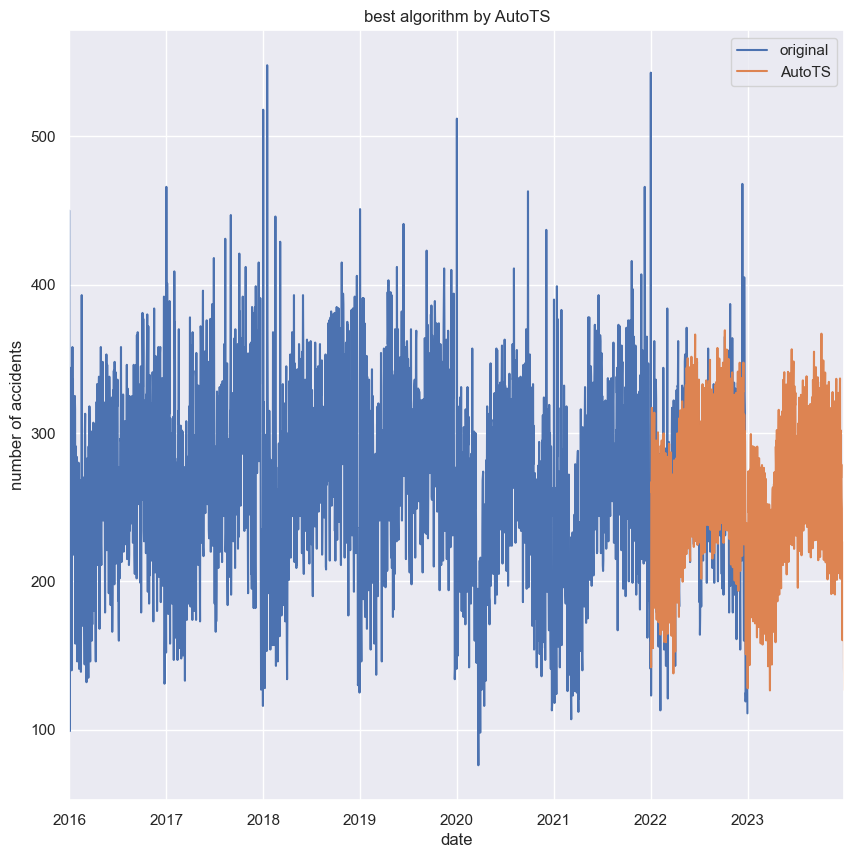

In [107]:
# add results to predict_df
predict_df['AutoTS'] = [np.nan] * len(dataset_train) + list(forecast['predicted'])

# plot the results
predict_df[['original', 'AutoTS']].plot()
plt.title('best algorithm by AutoTS')
plt.xlabel('date')
plt.ylabel('number of accidents')

In [108]:
autots_model.results()

ID               Model  \
0     5e75ed52611fa9266c855f5876eb8720   AverageValueNaive   
1     32c21e08eec3d98d9158c35dfb4410ba   AverageValueNaive   
2     d8bd60351c03557d2b76a1f72be762ff   AverageValueNaive   
3     3c205c901c969cb3f2380ccc43f7a36f  DatepartRegression   
4     68a0c53e76c612a8e64a8b9057930f33  DatepartRegression   
...                                ...                 ...   
1354  107cc3859c34aa38e002403b37bcecc0            Ensemble   
1355  10ca25c9fe6e3727b734a469cf8cecf7            Ensemble   
1356  10ca25c9fe6e3727b734a469cf8cecf7            Ensemble   
1357  029c3f3e902c3b4ad3e1e3f85d8c0dbe            Ensemble   
1358  70b80914af713054190afe3c281f9c64            Ensemble   

                                        ModelParameters  \
0                    {"method": "Mean", "window": null}   
1                    {"method": "Mean", "window": null}   
2                    {"method": "Mean", "window": null}   
3     {"regression_model": {"model": "DecisionTree",...   
4     {"regression_model": {"model": "SVM", "model_p...   
...                                                 ...   
1354  {"model_name": "BestN", "model_count": 5, "mod...   
1355  {"model_name": "Dist", "model_count": 2, "mode...   
1356  {"model_name": "Dist", "model_count": 2, "mode...   
1357  {"model_name": "BestN", "model_count": 3, "mod...   
1358  {"model_name": "BestN", "model_count": 3, "mod...   

                               TransformationParameters  \
0     {"fillna": "fake_date", "transformations": {"0...   
1     {"fillna": "mean", "transformations": {"0": "C...   
2     {"fillna": "rolling_mean_24", "transformations...   
3     {"fillna": "mean", "transformations": {"0": "C...   
4     {"fillna": "zero", "transformations": {"0": "C...   
...                                                 ...   
1354                                                 {}   
1355                                                 {}   
1356                                                 {}   
1357                                                 {}   
1358                                                 {}   

      TransformationRuntime             FitRuntime         PredictRuntime  \
0    0 days 00:00:00.021641        0 days 00:00:00 0 days 00:00:00.000998   
1    0 days 00:00:00.013964        0 days 00:00:00 0 days 00:00:00.000997   
2    0 days 00:00:00.007160        0 days 00:00:00 0 days 00:00:00.000997   
3    0 days 00:00:00.018950        0 days 00:00:00 0 days 00:00:00.854711   
4    0 days 00:00:00.017953        0 days 00:00:00 0 days 00:00:01.052087   
...                     ...                    ...                    ...   
1354        0 days 00:00:00 0 days 00:00:12.726492 0 days 00:00:00.001001   
1355        0 days 00:00:00 0 days 00:00:01.168017        0 days 00:00:00   
1356        0 days 00:00:00 0 days 00:00:01.123127        0 days 00:00:00   
1357        0 days 00:00:00 0 days 00:00:09.393476 0 days 00:00:00.002993   
1358        0 days 00:00:00 0 days 00:00:09.320317 0 days 00:00:00.001993   

               TotalRuntime  Ensemble Exceptions  ...  contour_weighted  \
0    0 days 00:00:00.033639         0        NaN  ...          0.695890   
1    0 days 00:00:00.021943         0        NaN  ...          0.528767   
2    0 days 00:00:00.020851         0        NaN  ...          0.745205   
3    0 days 00:00:00.886626         0        NaN  ...          0.542466   
4    0 days 00:00:01.155219         0        NaN  ...          0.471233   
...                     ...       ...        ...  ...               ...   
1354 0 days 00:00:15.850058         1        NaN  ...          0.761644   
1355 0 days 00:00:01.183976         1        NaN  ...          0.701370   
1356 0 days 00:00:01.138096         1        NaN  ...          0.701370   
1357 0 days 00:00:09.409433         1        NaN  ...          0.756164   
1358 0 days 00:00:09.335240         1        NaN  ...          0.747945   

      maxe_weighted  oda_weighted dwae_weighted

In [111]:
from sklearn.metrics import mean_squared_error

target_values = predict_df.tail(periods_to_predict + periods_to_predict).head(periods_to_predict)['original'].values
rmse_results = {}

for col in predict_df.columns:
    if col not in ['original', 'temp']:
        # Get the predicted values for the current model
        predicted_values = predict_df.tail(periods_to_predict + periods_to_predict).head(periods_to_predict)[col].values

        # Calculate the mean squared error
        mse = mean_squared_error(target_values, predicted_values)

        # Calculate the RMSE by taking the square root of the MSE
        rmse = np.sqrt(mse)

        # Store the RMSE value in the dictionary
        rmse_results[col] = rmse
        
# Convert the dictionary to a DataFrame for easier visualization
rmse_df = pd.DataFrame.from_dict(rmse_results, orient='index', columns=['RMSE'])
rmse_df.sort_values(by='RMSE')

RMSE
AutoTS                      42.410968
prophet                     51.463927
GNN                         55.354938
random forest + grid        55.813691
random forest + randomized  56.999480
random forest + GA          57.174723
lstm                        58.691967
rnn                         61.847105
catboost                    67.423872
svr                         68.188995
arima                       68.675990
xgboost                     69.415562
MLP + GA                    74.593396
MLP + randomized            74.593396
MLP + grid                  74.593396

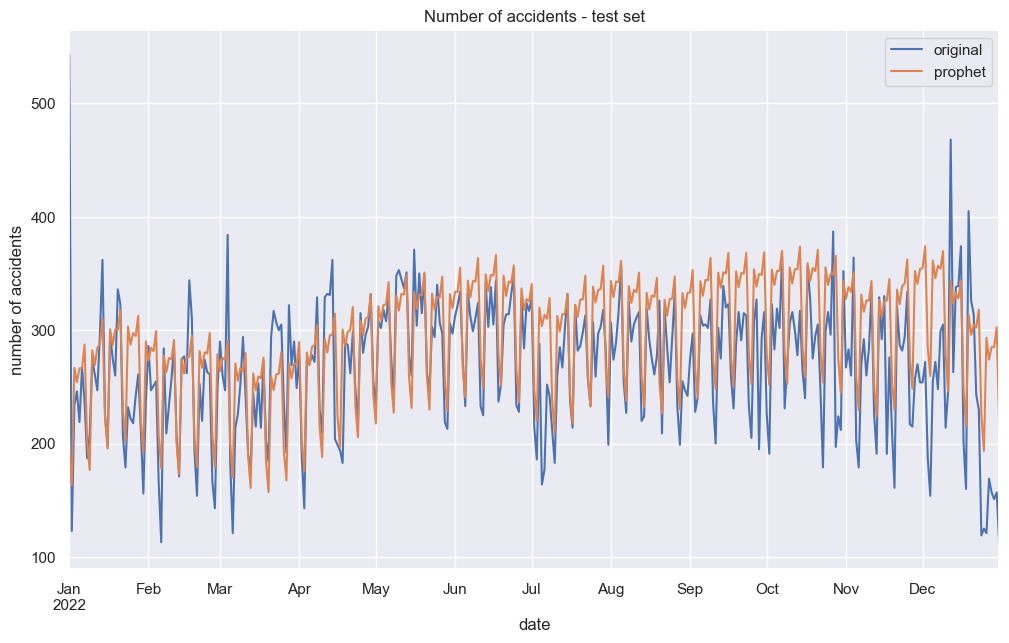

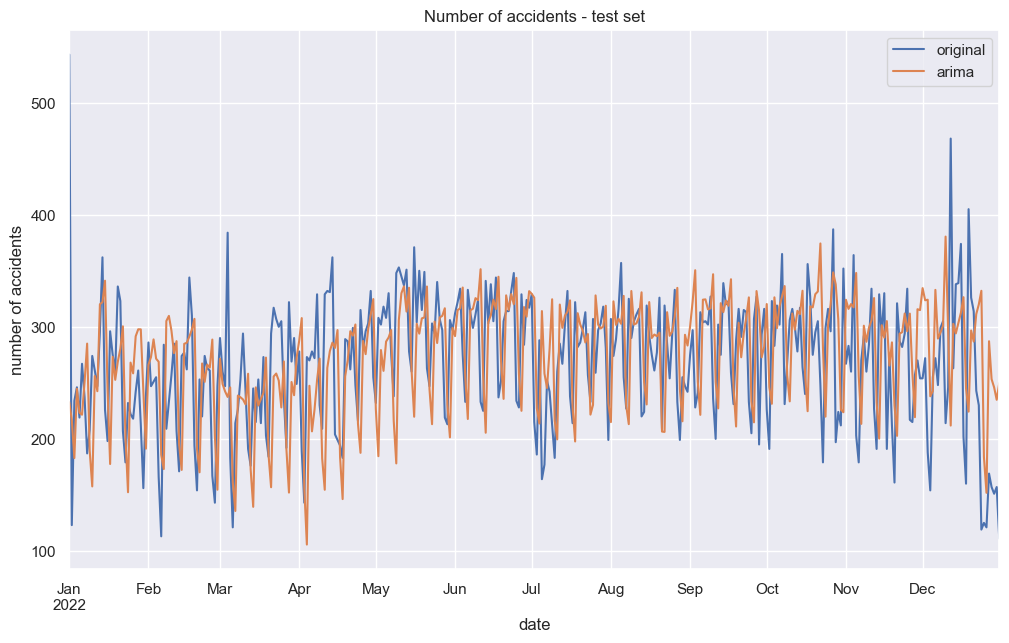

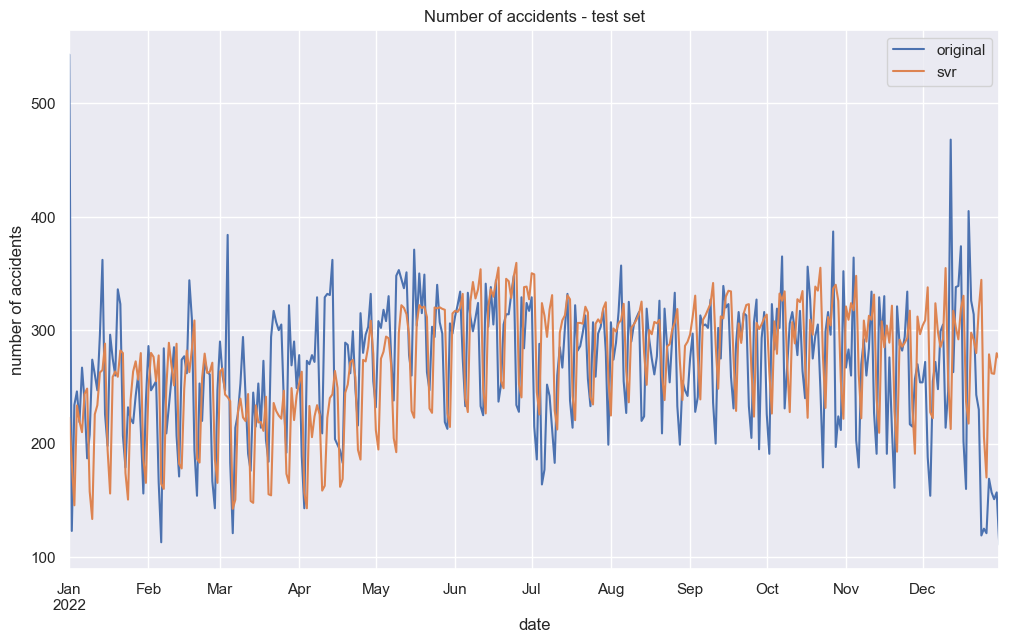

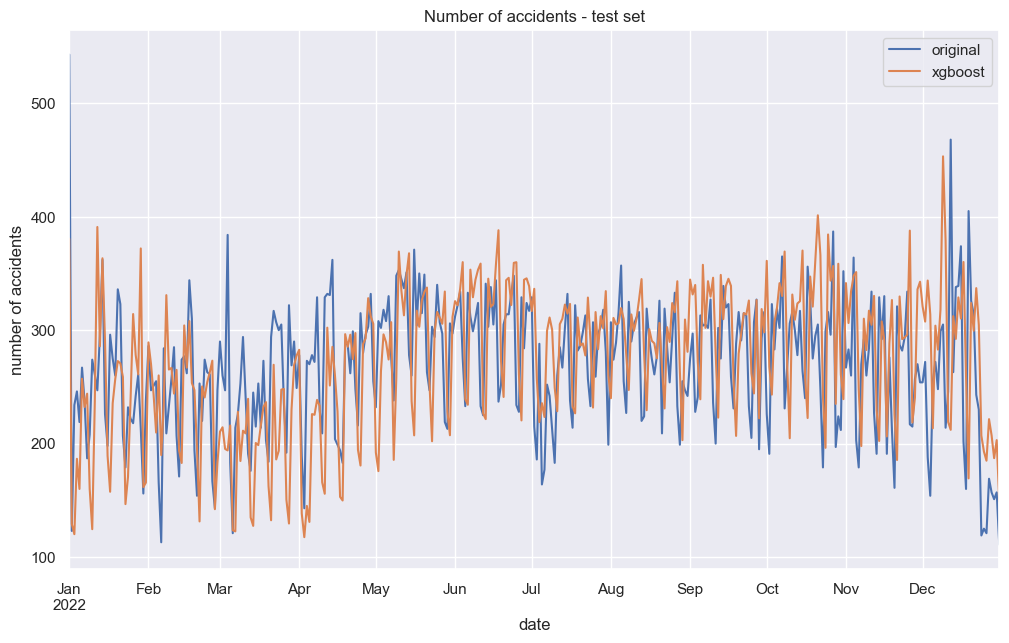

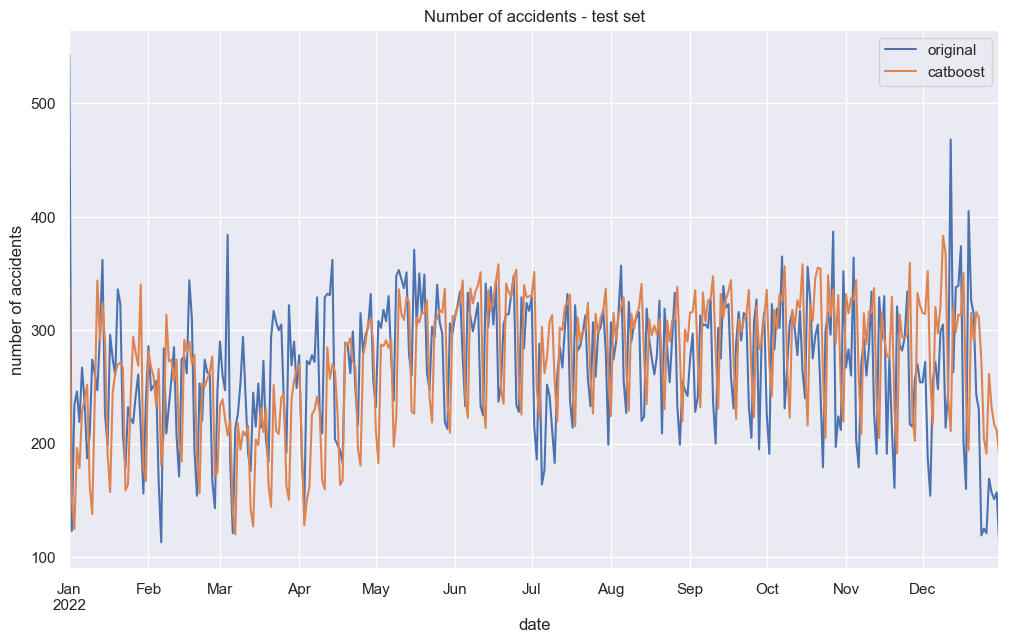

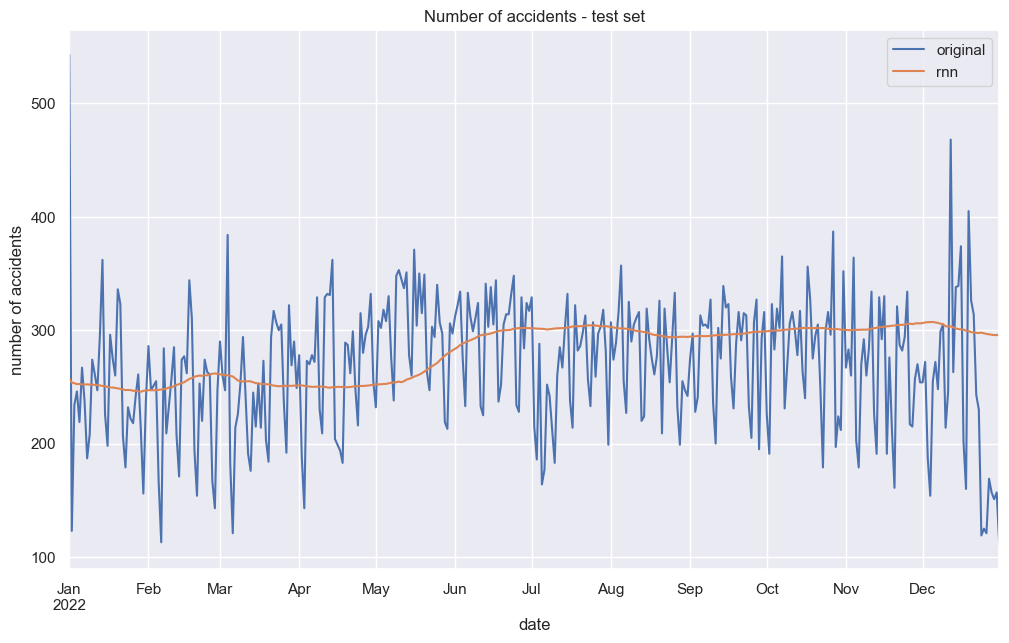

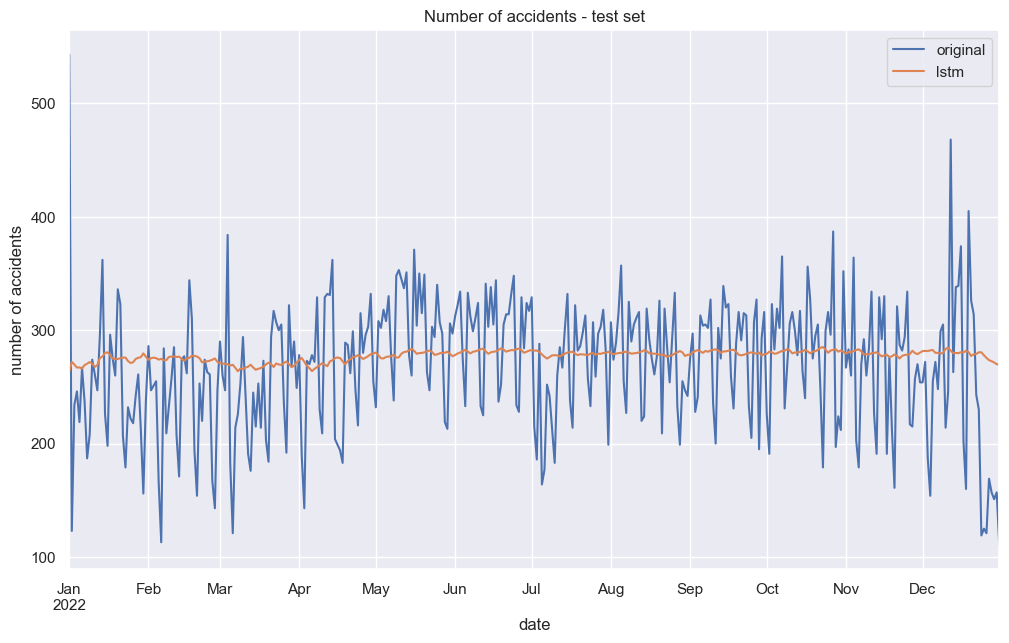

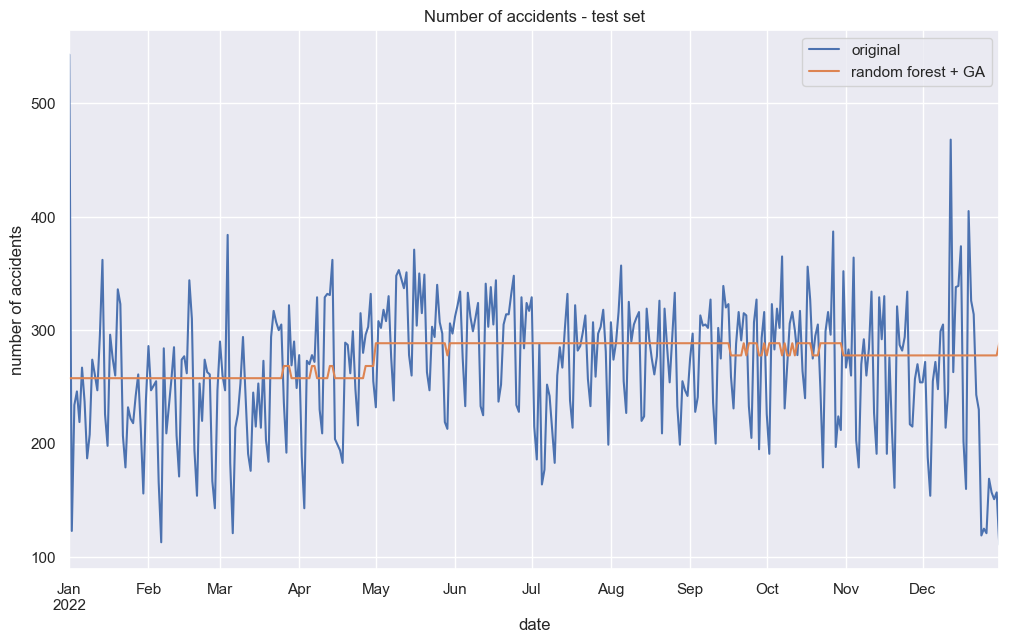

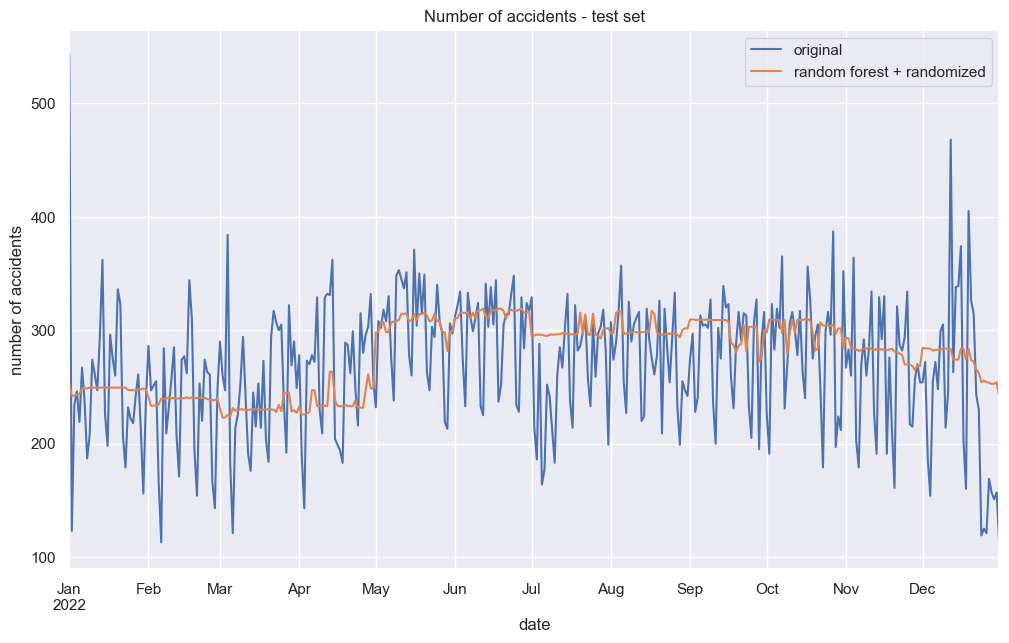

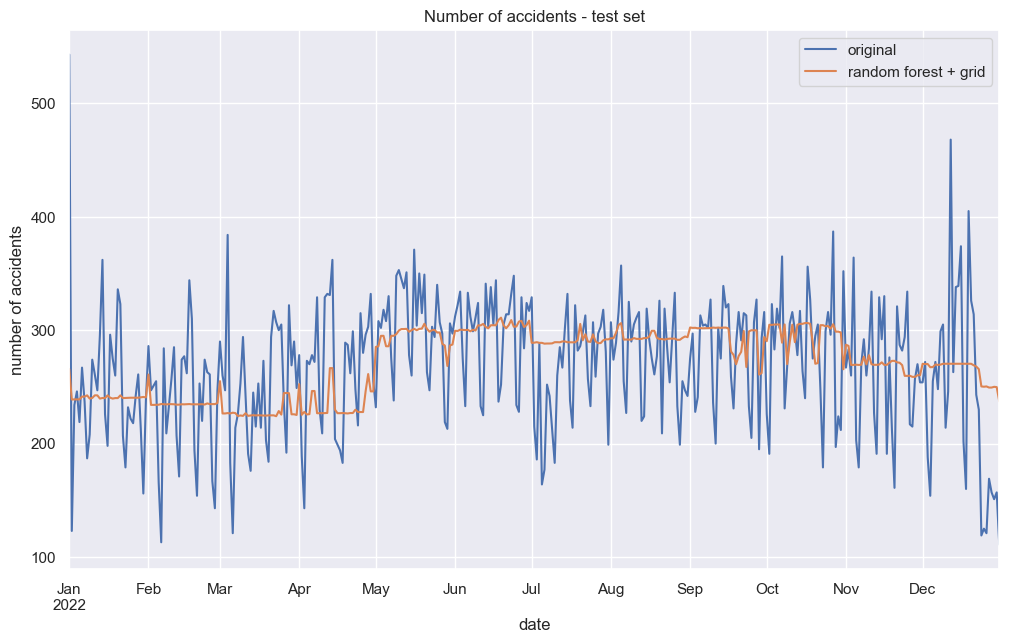

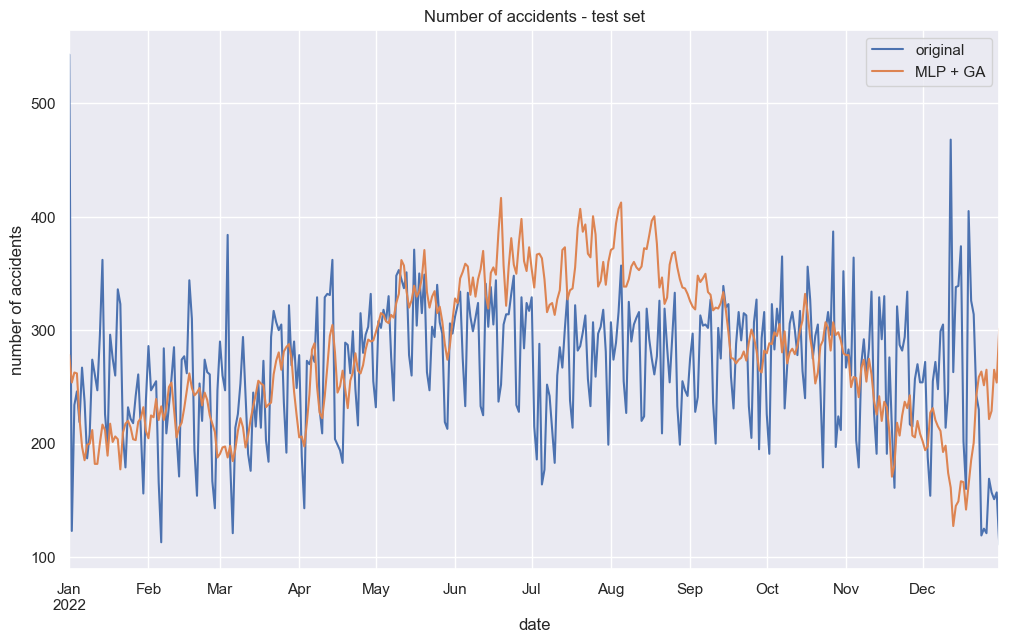

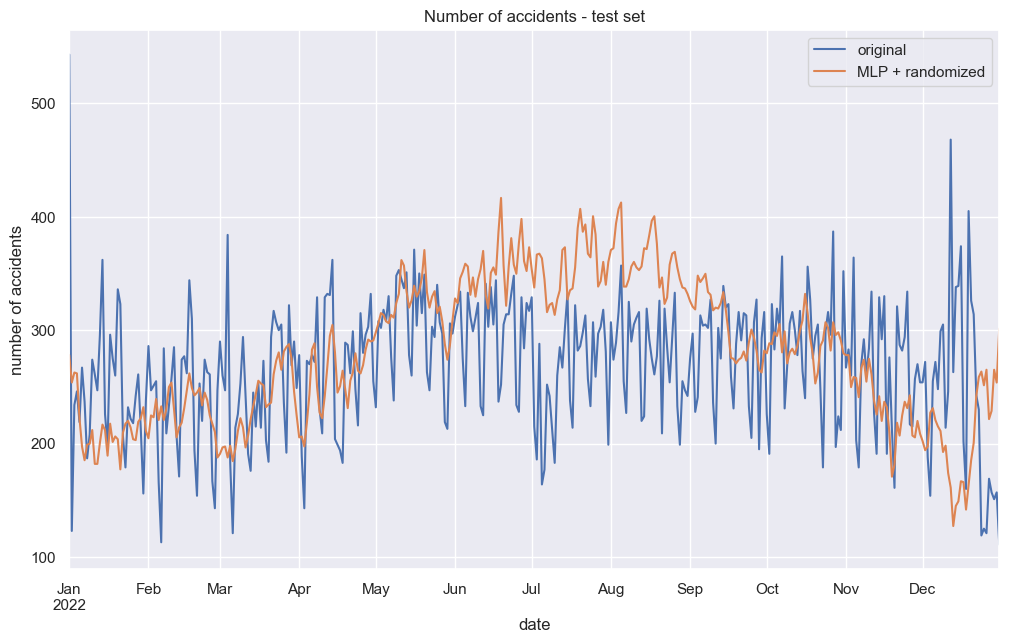

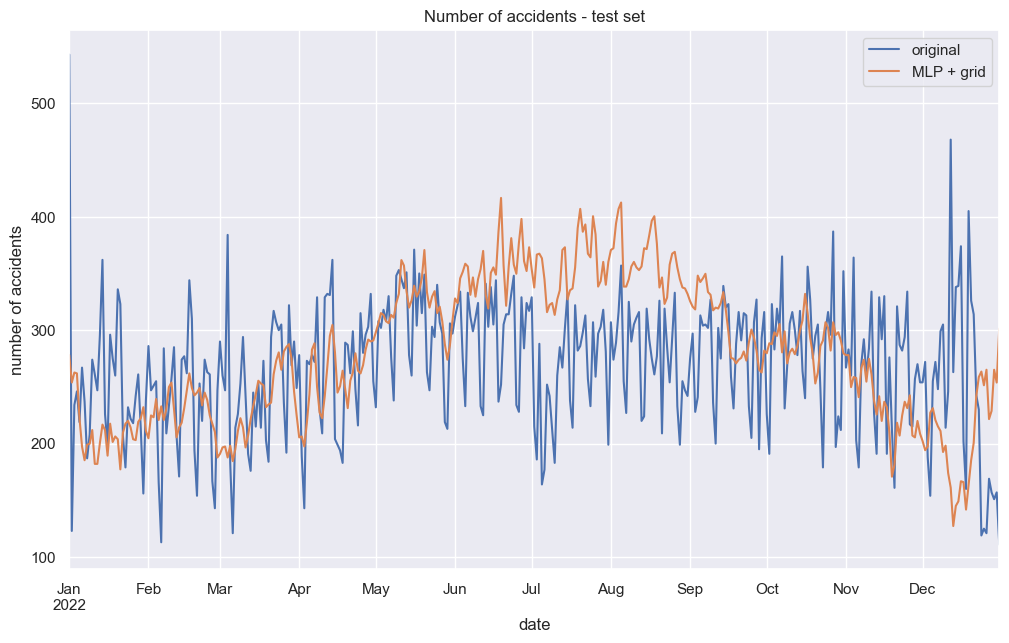

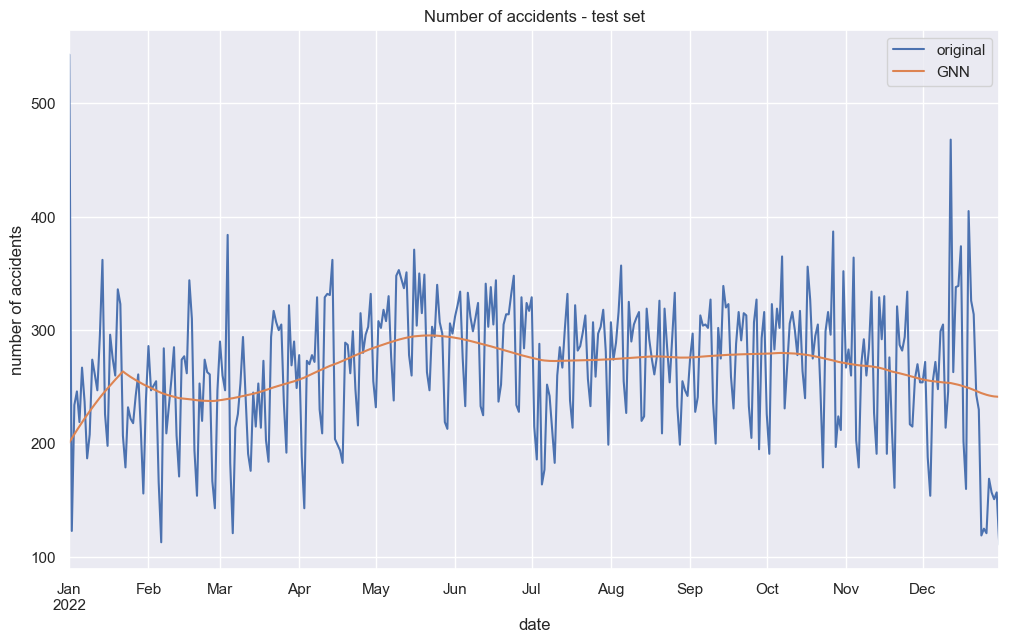

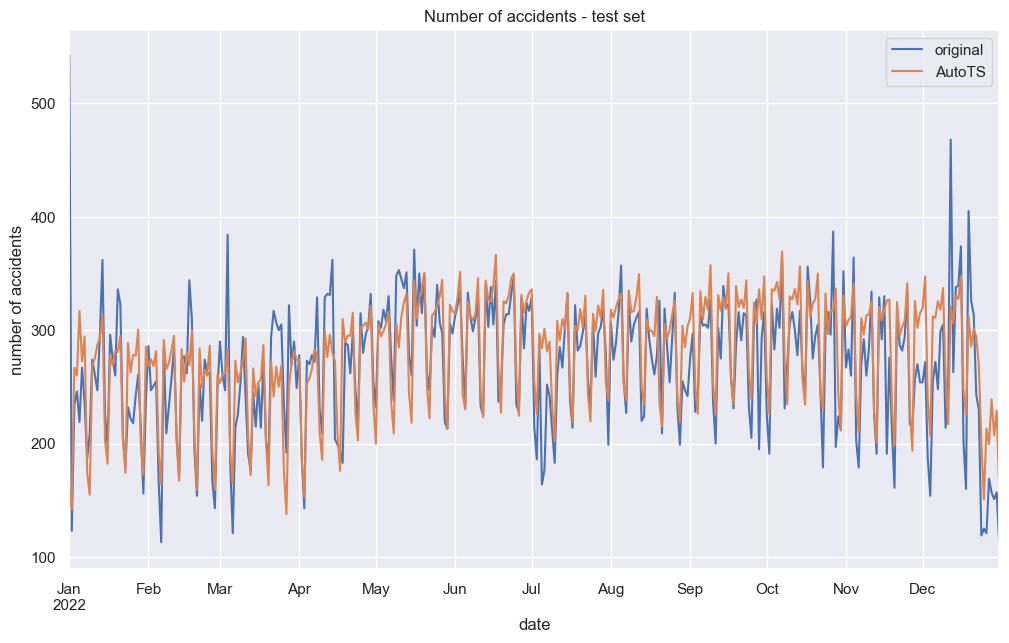

In [112]:
for col in predict_df.columns:
    if col not in ['original', 'temp']:
        plt.rcParams['figure.figsize'] = [12, 7]
        predict_df[['original', col]].tail(periods_to_predict + periods_to_predict).head(periods_to_predict).plot()
        plt.title('Number of accidents - test set')
        plt.xlabel('date')
        plt.ylabel('number of accidents')
        plt.show()

<Axes: xlabel='ds'>

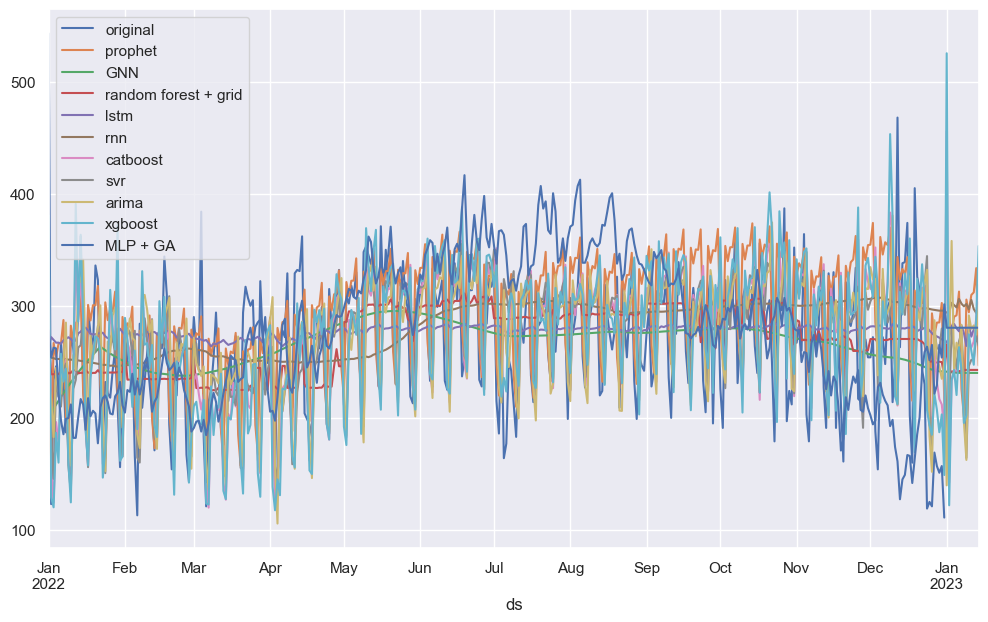

In [118]:
predict_df[['original', 'prophet', 'GNN', 'random forest + grid', 'lstm', 'rnn', 
            'catboost', 'svr', 'arima', 'xgboost', 'MLP + GA']].tail(
    periods_to_predict + periods_to_predict).head(periods_to_predict + min(14, periods_to_predict)).plot()
plt.title('')